In [5]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Validate
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error
import math
from numpy import array

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

READ ME:

You simply run the code and it should work without changing anything

In [2]:
time_step = 168
num_predict_hours = 168

# Import Data

In [6]:
df1=pd.read_csv('btc_1h.csv')

In [7]:
df1_clean = df1.filter(['close'])

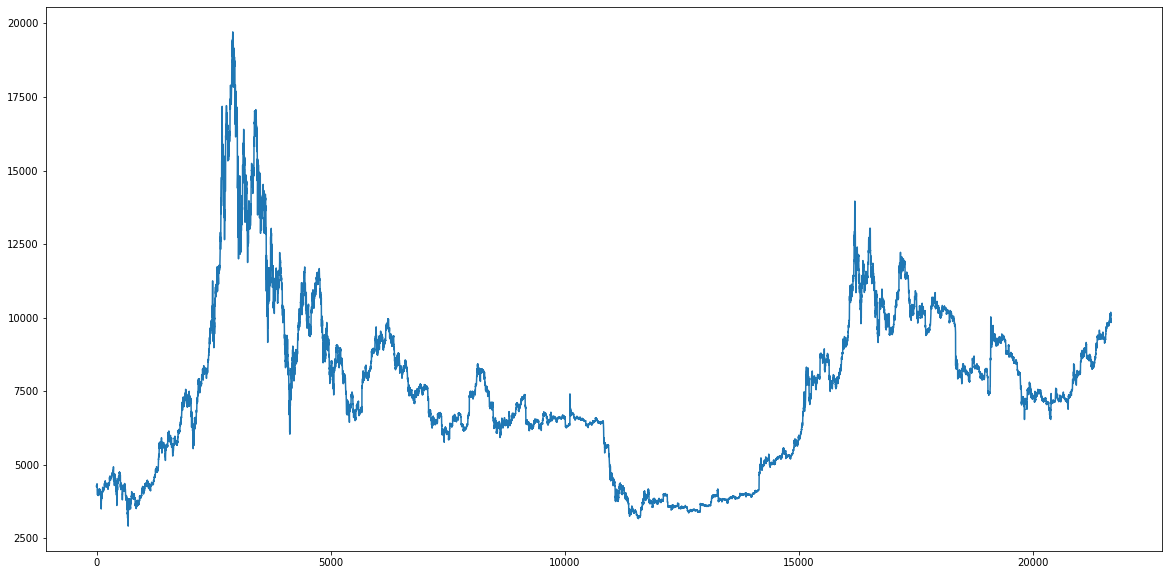

In [8]:
#Visualize data
plt.figure(figsize = (20,10))
plt.plot(df1_clean)

# Normalize data 

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1_clean).reshape(-1,1))

In [10]:
print(df1)

[[0.08144665]
 [0.07888925]
 [0.08031863]
 ...
 [0.41910068]
 [0.41987969]
 [0.41532772]]


# Create train + test data

## Splitting dataset into train and test split

In [11]:
training_size=int(len(df1)*0.8)
test_size=len(df1)-training_size

train_data=df1[int(training_size*0.6):training_size,:]
test_data=df1[training_size:len(df1),:1]
valid_data=train_data[int(len(train_data)*0.7):] 

print(training_size,train_data.shape,valid_data.shape,test_data.shape)

17334 (6934, 1) (2081, 1) (4334, 1)


Creating a small dataset for testing

## Convert an array of values into a X and Y format for: training and test

In [12]:
## X being the input values
## Y being the target

def create_dataset(dataset, time_step=1):
    dataX = []
    dataY = []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

## Convert dataset to trainning and test data

In [13]:
#Convert the train_data + Test data
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
X_valid, y_valid = create_dataset(valid_data, time_step)

In [14]:
print("Train")
print(X_train.shape), print(y_train.shape)
print("Test")
print(X_test.shape), print(y_test.shape), 
print("valid")
print(X_valid.shape), print(y_valid.shape)

Train
(6765, 168)
(6765,)
Test
(4165, 168)
(4165,)
valid
(1912, 168)
(1912,)


(None, None)

In [15]:
# Reshape input to [samples, time steps, features]
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_valid = X_valid.reshape(X_valid.shape[0],X_valid.shape[1] , 1)
print(X_train.shape)

(6765, 168, 1)


# Create LSTM Model/Hyperparameter Tuner
## If you wish to use the hyperparameter tuner just uncomment the following upto you see "here" - run it once then use those hyperparameters to fit in the next section so it saves time

In [16]:
# from kerastuner.engine.hyperparameters import HyperParameters
# from kerastuner.tuners import RandomSearch
# import time
# EXECUTION_PER_TRIAL = 1

# LOG_DIR = f"{int(time.time())}"

# def build_model(hp):
#     model=Sequential()
#     model.add(LSTM(hp.Int("input_units", min_value = 1, max_value= 30, step = 5), return_sequences=True, input_shape= (X_train.shape[1], 1)))
#     model.add(LSTM(hp.Int("input_units", min_value = 1, max_value= 30, step = 5), return_sequences= False))
#     model.add(Dense(168))
#     model.add(Dense(1))
#     model.compile(loss='mean_squared_error',optimizer='adam')
#     return model


# tuner = RandomSearch(build_model, objective ='loss', max_trials=10, executions_per_trial=EXECUTION_PER_TRIAL, directory = LOG_DIR)
# tuner.search(x= X_train, y=y_train, epochs =5 , batch_size =512, validation_data = (X_valid, y_valid))

We get the hyperparameters by looking at the summary

In [17]:
# model.summary()

In [18]:
# test_predict=model.predict(X_test,verbose=1)
# test_predict=scaler.inverse_transform(test_predict)

Check the loss vs val_loss to see if it makes sense

In [19]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model train vs validation loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper right')
# plt.show()
# model.compile(loss='mean_squared_error',optimizer='adam')


# Here

# Using the optimized hyperparamter

We created a seperate model here to further test the model with optimized hyperparemters instead of needing to rerun the whole tuner, as we already know what are the hyperparameter given by the model.summary().

In [20]:
#You change the hyperparameters with the hyperparameters
from tensorflow.keras.layers import Dropout
model=Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(24))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
history=model.fit(X_train, y_train, batch_size=256, epochs=10,validation_data = (X_valid, y_valid),verbose=1)

Epoch 1/10
27/27 [==============================] - 18s 650ms/step - loss: 0.0160 - val_loss: 9.9313e-04
Epoch 2/10
27/27 [==============================] - 16s 580ms/step - loss: 0.0011 - val_loss: 5.0993e-04
Epoch 3/10
27/27 [==============================] - 16s 588ms/step - loss: 7.5384e-04 - val_loss: 2.1235e-04
Epoch 4/10
27/27 [==============================] - 16s 594ms/step - loss: 5.8980e-04 - val_loss: 2.0877e-04
Epoch 5/10
27/27 [==============================] - 16s 608ms/step - loss: 5.7848e-04 - val_loss: 2.1130e-04
Epoch 6/10
27/27 [==============================] - 17s 639ms/step - loss: 4.9750e-04 - val_loss: 2.3484e-04
Epoch 7/10
27/27 [==============================] - 17s 636ms/step - loss: 4.7287e-04 - val_loss: 2.0328e-04
Epoch 8/10
27/27 [==============================] - 20s 739ms/step - loss: 4.3021e-04 - val_loss: 2.0542e-04
Epoch 9/10
27/27 [==============================] - 19s 709ms/step - loss: 4.3473e-04 - val_loss: 2.6079e-04
Epoch 10/10
27/27 [========

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 168, 50)           10400     
_________________________________________________________________
dropout (Dropout)            (None, 168, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                1224      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 31,849
Trainable params: 31,849
Non-trainable params: 0
____________________________________________________

In [22]:
#Predict model
test_predict=model.predict(X_test,verbose=1)

131/131 [==============================] - 6s 47ms/step


# Results

Check val and val_loss to see if is overfitting

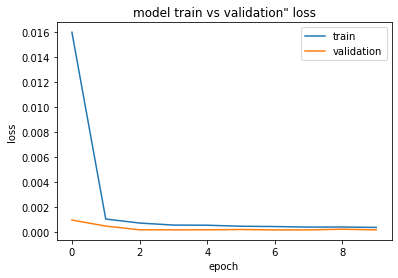

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation" loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
model.compile(loss='mean_squared_error',optimizer='adam')

In [24]:
#Reshape so fits in inverse sacler
y_test=y_test.reshape(-1,1)

#Denormalize output so can calculate results
test_predict=scaler.inverse_transform(test_predict)
y_test=scaler.inverse_transform(y_test)

In [25]:
MAE=median_absolute_error(y_test, test_predict)
mse=mean_squared_error(y_test, test_predict)
rmse=sqrt(mean_squared_error(y_test, test_predict))
rsquare=r2_score(y_test,test_predict)
print(MAE,mse,rmse,rsquare)

83.84214843749942 21208.40058249609 145.63104264715022 0.981743514216141


# Plot

IF YOU CHANGE THE TIME STEP (want to look back further) YOU HAVE TO CHANGE THE +{ NUMBER } AT VALID = df1_clean[training_size+337:]

<ipython-input-26-82e7da22a95d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = test_predict[: :]


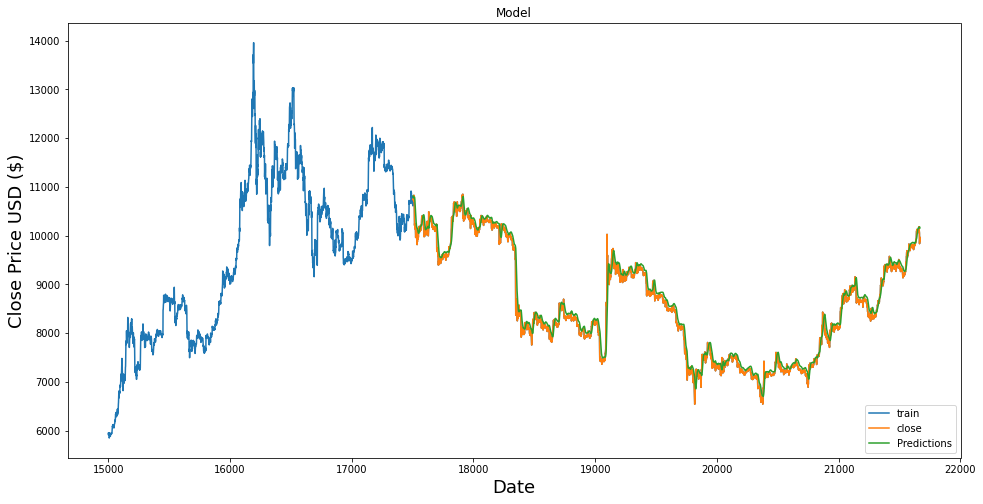

In [26]:
# test_predict2 = pd.DataFrame(test_predict)
# validation['Predictions'] = test_predict2
train=df1_clean[15000:]
valid = df1_clean[training_size+169:]
valid['Predictions'] = test_predict[: :]

# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train[['close']])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['train','close', 'Predictions'], loc='lower right')
plt.show()



# Forecasting
## Split data into 7 time period
Take X amount of time_step and predict Y amount of days forward (instead of one) 
on a span of 7 time period

In [27]:
len(test_data)

4334

In [28]:
#How many period do you want to go back? Timesteps* NUMBER OF PERIOD
# for example: we use 168 days to determine 168 days ahead
# and we have a dataset [0:336]
# the data will use 168->336 to forecast 336->504
# but what if we want to predict go back a period before?
# therefore 168*2(number of period) = 336 and we will use 0->168 to predict 168->336

# futher explanation: 
# we are working backwards
# if we want 7 period, w/10 timestep to predict 10 upcoming days on a dataset of 1:100
# [100,99,...91] will be used predict 10 upcoming days (101->111)
# [90...81] will predict the upcoming days (91...100)) (which will be HIDDEN)
# We do this for X amount of period desired

#creates an array x_input with 168 values from the test_data and stores them based on the desired period
#example: [1...100] timestep =10
#1st period = [100...91]
#2nd period = [90...81]

num_period=[1,2,3,4,5,6,7]
x_input=[]
type(len(test_data))
for i in num_period:
    #4334 (length of test data) - 168 (number of timesteps) = 4284
    # 1st period => append(test_data[4334-1*168 : 4334-0*168] => 4166:4334
    # 2nd period => append(test_data[4334-2*168 : 4334-1*168] => 3998:4166
    #... 7 time
    x_input.append(test_data[len(test_data)-int(i*time_step):len(test_data)-((i-1)*time_step)].reshape(1,-1))
    
len(x_input)    
print(x_input)

[array([[0.38427801, 0.38266639, 0.38080641, 0.38310235, 0.38284268,
        0.38188559, 0.38322921, 0.37824961, 0.37787261, 0.37964146,
        0.38053483, 0.38103094, 0.38111075, 0.37929663, 0.37849081,
        0.37957416, 0.38182841, 0.37860516, 0.38012924, 0.37902087,
        0.37832405, 0.37940145, 0.37853369, 0.37876359, 0.37645097,
        0.3724225 , 0.37234865, 0.37305679, 0.37011465, 0.37157023,
        0.37131175, 0.37446592, 0.37559334, 0.37574819, 0.37381674,
        0.37326881, 0.37435693, 0.37223966, 0.37422828, 0.3739031 ,
        0.37554867, 0.37346118, 0.37568744, 0.37641464, 0.37672196,
        0.37863256, 0.37807093, 0.3785194 , 0.37756648, 0.37733718,
        0.385007  , 0.3870927 , 0.38903964, 0.38890265, 0.38870909,
        0.39105923, 0.39569995, 0.39555225, 0.4013049 , 0.4012382 ,
        0.40224353, 0.40341264, 0.39998809, 0.39862065, 0.39496084,
        0.39995831, 0.39688931, 0.40002978, 0.40057413, 0.40011614,
        0.40082606, 0.39961883, 0.40063727, 0.4

In [29]:
#Reshape
count= 0
for i in x_input:
        x_input[count]=i.reshape(-1)
        count+=1

In [30]:
x_input[0]

array([0.38427801, 0.38266639, 0.38080641, 0.38310235, 0.38284268,
       0.38188559, 0.38322921, 0.37824961, 0.37787261, 0.37964146,
       0.38053483, 0.38103094, 0.38111075, 0.37929663, 0.37849081,
       0.37957416, 0.38182841, 0.37860516, 0.38012924, 0.37902087,
       0.37832405, 0.37940145, 0.37853369, 0.37876359, 0.37645097,
       0.3724225 , 0.37234865, 0.37305679, 0.37011465, 0.37157023,
       0.37131175, 0.37446592, 0.37559334, 0.37574819, 0.37381674,
       0.37326881, 0.37435693, 0.37223966, 0.37422828, 0.3739031 ,
       0.37554867, 0.37346118, 0.37568744, 0.37641464, 0.37672196,
       0.37863256, 0.37807093, 0.3785194 , 0.37756648, 0.37733718,
       0.385007  , 0.3870927 , 0.38903964, 0.38890265, 0.38870909,
       0.39105923, 0.39569995, 0.39555225, 0.4013049 , 0.4012382 ,
       0.40224353, 0.40341264, 0.39998809, 0.39862065, 0.39496084,
       0.39995831, 0.39688931, 0.40002978, 0.40057413, 0.40011614,
       0.40082606, 0.39961883, 0.40063727, 0.40161043, 0.40257

In [31]:
#Create a temp_input
temp_input=[]
for i in x_input:
    temp_input.append(i)

## Creates 168 values of each period (7 times)

In [32]:
# demonstrate prediction for next 7 days (168 hours) * 7 periods
lst_output=[]
n_steps=time_step
i=0
final=[]

#First, goes into the else loop
    #creates the timeinput +1 by predicting first timesteps and adding it
    #therefore temp_input>time_step => enters if loop

#Second, inside if 
    #puts the timesteps(number of days to lookback) + 1 to the array 
    #predicts yhat
    #extends and adds into list (lst_output)
    #removes the first [0] by doing [1:]
    #and transform it back to temp_input>timestep
    #continuously going: into this if loop until over i<num_predict_hours
    
#Outside the loop while, reinitializes lst_output to nothing
    #And redo this again until for loop (7days/Number of period desired) is over

#NOTE: It's skipped at 0 because otherwise it would add an empty [] to the final 

for num_period  in range(7):
    print(num_period)
    i=0
    if num_period !=0:
        final.append(lst_output)
    lst_output=[]
    print(lst_output)
    print("lst_output")

    print(final)
    while(i<num_predict_hours):
        if(len(temp_input[num_period])>time_step):
            print("if statement")
            print(len(temp_input[num_period].reshape(-1)))
            print(len(temp_input[num_period]))
            x_input[num_period]=np.array(temp_input[num_period][1:])
            print("{} day input {}".format(i,x_input[num_period]))
            print(x_input[num_period].shape)
            x_input[num_period] = x_input[num_period].reshape((1, n_steps, 1))
            #print(x_input)
            \
            \
            yhat = model.predict(x_input[num_period], verbose=0)
            print("{} day output {}".format(i,yhat))

            temp_input[num_period]=np.append(temp_input[num_period],yhat)

            temp_input[num_period]=temp_input[num_period][1:]

            lst_output=np.append(lst_output,yhat)
            i=i+1
        else:
            print("else")
            print(len(x_input[num_period].reshape(-1)))
            x_input[num_period] = x_input[num_period].reshape((1, n_steps,1))
            yhat = model.predict(x_input[num_period], verbose=0)
            print("this is the output")
            print(yhat[0])
            print("I added it")
            temp_input[num_period]=np.append(temp_input[num_period],yhat)
            print(temp_input[num_period])
            print(len(temp_input[num_period]))
            lst_output=np.append(lst_output,yhat)

            i=i+1
    print("This is the final output")
    print(lst_output)

0
[]
lst_output
[]
else
168
this is the output
[0.42944697]
I added it
[0.38427801 0.38266639 0.38080641 0.38310235 0.38284268 0.38188559
 0.38322921 0.37824961 0.37787261 0.37964146 0.38053483 0.38103094
 0.38111075 0.37929663 0.37849081 0.37957416 0.38182841 0.37860516
 0.38012924 0.37902087 0.37832405 0.37940145 0.37853369 0.37876359
 0.37645097 0.3724225  0.37234865 0.37305679 0.37011465 0.37157023
 0.37131175 0.37446592 0.37559334 0.37574819 0.37381674 0.37326881
 0.37435693 0.37223966 0.37422828 0.3739031  0.37554867 0.37346118
 0.37568744 0.37641464 0.37672196 0.37863256 0.37807093 0.3785194
 0.37756648 0.37733718 0.385007   0.3870927  0.38903964 0.38890265
 0.38870909 0.39105923 0.39569995 0.39555225 0.4013049  0.4012382
 0.40224353 0.40341264 0.39998809 0.39862065 0.39496084 0.39995831
 0.39688931 0.40002978 0.40057413 0.40011614 0.40082606 0.39961883
 0.40063727 0.40161043 0.40257884 0.40379322 0.41131711 0.40649117
 0.41126232 0.40903368 0.4091385  0.40812185 0.40797951 0.40

4 day output [[0.42834538]]
if statement
169
169
5 day input [0.38188559 0.38322921 0.37824961 0.37787261 0.37964146 0.38053483
 0.38103094 0.38111075 0.37929663 0.37849081 0.37957416 0.38182841
 0.37860516 0.38012924 0.37902087 0.37832405 0.37940145 0.37853369
 0.37876359 0.37645097 0.3724225  0.37234865 0.37305679 0.37011465
 0.37157023 0.37131175 0.37446592 0.37559334 0.37574819 0.37381674
 0.37326881 0.37435693 0.37223966 0.37422828 0.3739031  0.37554867
 0.37346118 0.37568744 0.37641464 0.37672196 0.37863256 0.37807093
 0.3785194  0.37756648 0.37733718 0.385007   0.3870927  0.38903964
 0.38890265 0.38870909 0.39105923 0.39569995 0.39555225 0.4013049
 0.4012382  0.40224353 0.40341264 0.39998809 0.39862065 0.39496084
 0.39995831 0.39688931 0.40002978 0.40057413 0.40011614 0.40082606
 0.39961883 0.40063727 0.40161043 0.40257884 0.40379322 0.41131711
 0.40649117 0.41126232 0.40903368 0.4091385  0.40812185 0.40797951
 0.4066758  0.40882821 0.40684852 0.40342456 0.40814746 0.40928799
 0

10 day output [[0.43059173]]
if statement
169
169
11 day input [0.38103094 0.38111075 0.37929663 0.37849081 0.37957416 0.38182841
 0.37860516 0.38012924 0.37902087 0.37832405 0.37940145 0.37853369
 0.37876359 0.37645097 0.3724225  0.37234865 0.37305679 0.37011465
 0.37157023 0.37131175 0.37446592 0.37559334 0.37574819 0.37381674
 0.37326881 0.37435693 0.37223966 0.37422828 0.3739031  0.37554867
 0.37346118 0.37568744 0.37641464 0.37672196 0.37863256 0.37807093
 0.3785194  0.37756648 0.37733718 0.385007   0.3870927  0.38903964
 0.38890265 0.38870909 0.39105923 0.39569995 0.39555225 0.4013049
 0.4012382  0.40224353 0.40341264 0.39998809 0.39862065 0.39496084
 0.39995831 0.39688931 0.40002978 0.40057413 0.40011614 0.40082606
 0.39961883 0.40063727 0.40161043 0.40257884 0.40379322 0.41131711
 0.40649117 0.41126232 0.40903368 0.4091385  0.40812185 0.40797951
 0.4066758  0.40882821 0.40684852 0.40342456 0.40814746 0.40928799
 0.41029392 0.40981507 0.40861082 0.40934576 0.40723623 0.40860844


16 day output [[0.4336012]]
if statement
169
169
17 day input [0.37860516 0.38012924 0.37902087 0.37832405 0.37940145 0.37853369
 0.37876359 0.37645097 0.3724225  0.37234865 0.37305679 0.37011465
 0.37157023 0.37131175 0.37446592 0.37559334 0.37574819 0.37381674
 0.37326881 0.37435693 0.37223966 0.37422828 0.3739031  0.37554867
 0.37346118 0.37568744 0.37641464 0.37672196 0.37863256 0.37807093
 0.3785194  0.37756648 0.37733718 0.385007   0.3870927  0.38903964
 0.38890265 0.38870909 0.39105923 0.39569995 0.39555225 0.4013049
 0.4012382  0.40224353 0.40341264 0.39998809 0.39862065 0.39496084
 0.39995831 0.39688931 0.40002978 0.40057413 0.40011614 0.40082606
 0.39961883 0.40063727 0.40161043 0.40257884 0.40379322 0.41131711
 0.40649117 0.41126232 0.40903368 0.4091385  0.40812185 0.40797951
 0.4066758  0.40882821 0.40684852 0.40342456 0.40814746 0.40928799
 0.41029392 0.40981507 0.40861082 0.40934576 0.40723623 0.40860844
 0.40992406 0.40821179 0.40942676 0.41080194 0.41037075 0.4071874
 0

22 day output [[0.4365948]]
if statement
169
169
23 day input [0.37876359 0.37645097 0.3724225  0.37234865 0.37305679 0.37011465
 0.37157023 0.37131175 0.37446592 0.37559334 0.37574819 0.37381674
 0.37326881 0.37435693 0.37223966 0.37422828 0.3739031  0.37554867
 0.37346118 0.37568744 0.37641464 0.37672196 0.37863256 0.37807093
 0.3785194  0.37756648 0.37733718 0.385007   0.3870927  0.38903964
 0.38890265 0.38870909 0.39105923 0.39569995 0.39555225 0.4013049
 0.4012382  0.40224353 0.40341264 0.39998809 0.39862065 0.39496084
 0.39995831 0.39688931 0.40002978 0.40057413 0.40011614 0.40082606
 0.39961883 0.40063727 0.40161043 0.40257884 0.40379322 0.41131711
 0.40649117 0.41126232 0.40903368 0.4091385  0.40812185 0.40797951
 0.4066758  0.40882821 0.40684852 0.40342456 0.40814746 0.40928799
 0.41029392 0.40981507 0.40861082 0.40934576 0.40723623 0.40860844
 0.40992406 0.40821179 0.40942676 0.41080194 0.41037075 0.4071874
 0.40874542 0.411198   0.40993538 0.40971919 0.40868527 0.40977636
 0

 0.43708929 0.43758255 0.43807495 0.43856636 0.43905687 0.43954626]
(168,)
29 day output [[0.4400351]]
if statement
169
169
30 day input [0.37131175 0.37446592 0.37559334 0.37574819 0.37381674 0.37326881
 0.37435693 0.37223966 0.37422828 0.3739031  0.37554867 0.37346118
 0.37568744 0.37641464 0.37672196 0.37863256 0.37807093 0.3785194
 0.37756648 0.37733718 0.385007   0.3870927  0.38903964 0.38890265
 0.38870909 0.39105923 0.39569995 0.39555225 0.4013049  0.4012382
 0.40224353 0.40341264 0.39998809 0.39862065 0.39496084 0.39995831
 0.39688931 0.40002978 0.40057413 0.40011614 0.40082606 0.39961883
 0.40063727 0.40161043 0.40257884 0.40379322 0.41131711 0.40649117
 0.41126232 0.40903368 0.4091385  0.40812185 0.40797951 0.4066758
 0.40882821 0.40684852 0.40342456 0.40814746 0.40928799 0.41029392
 0.40981507 0.40861082 0.40934576 0.40723623 0.40860844 0.40992406
 0.40821179 0.40942676 0.41080194 0.41037075 0.4071874  0.40874542
 0.411198   0.40993538 0.40971919 0.40868527 0.40977636 0.4083

169
35 day input [0.37326881 0.37435693 0.37223966 0.37422828 0.3739031  0.37554867
 0.37346118 0.37568744 0.37641464 0.37672196 0.37863256 0.37807093
 0.3785194  0.37756648 0.37733718 0.385007   0.3870927  0.38903964
 0.38890265 0.38870909 0.39105923 0.39569995 0.39555225 0.4013049
 0.4012382  0.40224353 0.40341264 0.39998809 0.39862065 0.39496084
 0.39995831 0.39688931 0.40002978 0.40057413 0.40011614 0.40082606
 0.39961883 0.40063727 0.40161043 0.40257884 0.40379322 0.41131711
 0.40649117 0.41126232 0.40903368 0.4091385  0.40812185 0.40797951
 0.4066758  0.40882821 0.40684852 0.40342456 0.40814746 0.40928799
 0.41029392 0.40981507 0.40861082 0.40934576 0.40723623 0.40860844
 0.40992406 0.40821179 0.40942676 0.41080194 0.41037075 0.4071874
 0.40874542 0.411198   0.40993538 0.40971919 0.40868527 0.40977636
 0.40836128 0.40633037 0.40737322 0.41046306 0.4106328  0.4092195
 0.40900688 0.40559126 0.40469968 0.40726065 0.40749174 0.40760966
 0.40811113 0.41014204 0.41036955 0.40959352 0.4

41 day output [[0.44583765]]
if statement
169
169
42 day input [0.37568744 0.37641464 0.37672196 0.37863256 0.37807093 0.3785194
 0.37756648 0.37733718 0.385007   0.3870927  0.38903964 0.38890265
 0.38870909 0.39105923 0.39569995 0.39555225 0.4013049  0.4012382
 0.40224353 0.40341264 0.39998809 0.39862065 0.39496084 0.39995831
 0.39688931 0.40002978 0.40057413 0.40011614 0.40082606 0.39961883
 0.40063727 0.40161043 0.40257884 0.40379322 0.41131711 0.40649117
 0.41126232 0.40903368 0.4091385  0.40812185 0.40797951 0.4066758
 0.40882821 0.40684852 0.40342456 0.40814746 0.40928799 0.41029392
 0.40981507 0.40861082 0.40934576 0.40723623 0.40860844 0.40992406
 0.40821179 0.40942676 0.41080194 0.41037075 0.4071874  0.40874542
 0.411198   0.40993538 0.40971919 0.40868527 0.40977636 0.40836128
 0.40633037 0.40737322 0.41046306 0.4106328  0.4092195  0.40900688
 0.40559126 0.40469968 0.40726065 0.40749174 0.40760966 0.40811113
 0.41014204 0.41036955 0.40959352 0.41041184 0.41041958 0.40942855
 0

47 day output [[0.44869718]]
if statement
169
169
48 day input [0.37756648 0.37733718 0.385007   0.3870927  0.38903964 0.38890265
 0.38870909 0.39105923 0.39569995 0.39555225 0.4013049  0.4012382
 0.40224353 0.40341264 0.39998809 0.39862065 0.39496084 0.39995831
 0.39688931 0.40002978 0.40057413 0.40011614 0.40082606 0.39961883
 0.40063727 0.40161043 0.40257884 0.40379322 0.41131711 0.40649117
 0.41126232 0.40903368 0.4091385  0.40812185 0.40797951 0.4066758
 0.40882821 0.40684852 0.40342456 0.40814746 0.40928799 0.41029392
 0.40981507 0.40861082 0.40934576 0.40723623 0.40860844 0.40992406
 0.40821179 0.40942676 0.41080194 0.41037075 0.4071874  0.40874542
 0.411198   0.40993538 0.40971919 0.40868527 0.40977636 0.40836128
 0.40633037 0.40737322 0.41046306 0.4106328  0.4092195  0.40900688
 0.40559126 0.40469968 0.40726065 0.40749174 0.40760966 0.40811113
 0.41014204 0.41036955 0.40959352 0.41041184 0.41041958 0.40942855
 0.41225634 0.41157023 0.41329383 0.41351895 0.41230219 0.41354873
 

52 day output [[0.45105857]]
if statement
169
169
53 day input [0.38890265 0.38870909 0.39105923 0.39569995 0.39555225 0.4013049
 0.4012382  0.40224353 0.40341264 0.39998809 0.39862065 0.39496084
 0.39995831 0.39688931 0.40002978 0.40057413 0.40011614 0.40082606
 0.39961883 0.40063727 0.40161043 0.40257884 0.40379322 0.41131711
 0.40649117 0.41126232 0.40903368 0.4091385  0.40812185 0.40797951
 0.4066758  0.40882821 0.40684852 0.40342456 0.40814746 0.40928799
 0.41029392 0.40981507 0.40861082 0.40934576 0.40723623 0.40860844
 0.40992406 0.40821179 0.40942676 0.41080194 0.41037075 0.4071874
 0.40874542 0.411198   0.40993538 0.40971919 0.40868527 0.40977636
 0.40836128 0.40633037 0.40737322 0.41046306 0.4106328  0.4092195
 0.40900688 0.40559126 0.40469968 0.40726065 0.40749174 0.40760966
 0.40811113 0.41014204 0.41036955 0.40959352 0.41041184 0.41041958
 0.40942855 0.41225634 0.41157023 0.41329383 0.41351895 0.41230219
 0.41354873 0.41320211 0.41664453 0.41656056 0.41547601 0.41797147
 0

57 day output [[0.4534]]
if statement
169
169
58 day input [0.4013049  0.4012382  0.40224353 0.40341264 0.39998809 0.39862065
 0.39496084 0.39995831 0.39688931 0.40002978 0.40057413 0.40011614
 0.40082606 0.39961883 0.40063727 0.40161043 0.40257884 0.40379322
 0.41131711 0.40649117 0.41126232 0.40903368 0.4091385  0.40812185
 0.40797951 0.4066758  0.40882821 0.40684852 0.40342456 0.40814746
 0.40928799 0.41029392 0.40981507 0.40861082 0.40934576 0.40723623
 0.40860844 0.40992406 0.40821179 0.40942676 0.41080194 0.41037075
 0.4071874  0.40874542 0.411198   0.40993538 0.40971919 0.40868527
 0.40977636 0.40836128 0.40633037 0.40737322 0.41046306 0.4106328
 0.4092195  0.40900688 0.40559126 0.40469968 0.40726065 0.40749174
 0.40760966 0.40811113 0.41014204 0.41036955 0.40959352 0.41041184
 0.41041958 0.40942855 0.41225634 0.41157023 0.41329383 0.41351895
 0.41230219 0.41354873 0.41320211 0.41664453 0.41656056 0.41547601
 0.41797147 0.41808761 0.42486108 0.42716238 0.42768172 0.42748935
 0.4

63 day output [[0.45618266]]
if statement
169
169
64 day input [0.39496084 0.39995831 0.39688931 0.40002978 0.40057413 0.40011614
 0.40082606 0.39961883 0.40063727 0.40161043 0.40257884 0.40379322
 0.41131711 0.40649117 0.41126232 0.40903368 0.4091385  0.40812185
 0.40797951 0.4066758  0.40882821 0.40684852 0.40342456 0.40814746
 0.40928799 0.41029392 0.40981507 0.40861082 0.40934576 0.40723623
 0.40860844 0.40992406 0.40821179 0.40942676 0.41080194 0.41037075
 0.4071874  0.40874542 0.411198   0.40993538 0.40971919 0.40868527
 0.40977636 0.40836128 0.40633037 0.40737322 0.41046306 0.4106328
 0.4092195  0.40900688 0.40559126 0.40469968 0.40726065 0.40749174
 0.40760966 0.40811113 0.41014204 0.41036955 0.40959352 0.41041184
 0.41041958 0.40942855 0.41225634 0.41157023 0.41329383 0.41351895
 0.41230219 0.41354873 0.41320211 0.41664453 0.41656056 0.41547601
 0.41797147 0.41808761 0.42486108 0.42716238 0.42768172 0.42748935
 0.42934219 0.42833328 0.42619338 0.42896817 0.42824931 0.42926059


68 day output [[0.4584785]]
if statement
169
169
69 day input [0.40011614 0.40082606 0.39961883 0.40063727 0.40161043 0.40257884
 0.40379322 0.41131711 0.40649117 0.41126232 0.40903368 0.4091385
 0.40812185 0.40797951 0.4066758  0.40882821 0.40684852 0.40342456
 0.40814746 0.40928799 0.41029392 0.40981507 0.40861082 0.40934576
 0.40723623 0.40860844 0.40992406 0.40821179 0.40942676 0.41080194
 0.41037075 0.4071874  0.40874542 0.411198   0.40993538 0.40971919
 0.40868527 0.40977636 0.40836128 0.40633037 0.40737322 0.41046306
 0.4106328  0.4092195  0.40900688 0.40559126 0.40469968 0.40726065
 0.40749174 0.40760966 0.40811113 0.41014204 0.41036955 0.40959352
 0.41041184 0.41041958 0.40942855 0.41225634 0.41157023 0.41329383
 0.41351895 0.41230219 0.41354873 0.41320211 0.41664453 0.41656056
 0.41547601 0.41797147 0.41808761 0.42486108 0.42716238 0.42768172
 0.42748935 0.42934219 0.42833328 0.42619338 0.42896817 0.42824931
 0.42926059 0.42758465 0.42675025 0.4275096  0.4283988  0.42711176
 

74 day input [0.40257884 0.40379322 0.41131711 0.40649117 0.41126232 0.40903368
 0.4091385  0.40812185 0.40797951 0.4066758  0.40882821 0.40684852
 0.40342456 0.40814746 0.40928799 0.41029392 0.40981507 0.40861082
 0.40934576 0.40723623 0.40860844 0.40992406 0.40821179 0.40942676
 0.41080194 0.41037075 0.4071874  0.40874542 0.411198   0.40993538
 0.40971919 0.40868527 0.40977636 0.40836128 0.40633037 0.40737322
 0.41046306 0.4106328  0.4092195  0.40900688 0.40559126 0.40469968
 0.40726065 0.40749174 0.40760966 0.40811113 0.41014204 0.41036955
 0.40959352 0.41041184 0.41041958 0.40942855 0.41225634 0.41157023
 0.41329383 0.41351895 0.41230219 0.41354873 0.41320211 0.41664453
 0.41656056 0.41547601 0.41797147 0.41808761 0.42486108 0.42716238
 0.42768172 0.42748935 0.42934219 0.42833328 0.42619338 0.42896817
 0.42824931 0.42926059 0.42758465 0.42675025 0.4275096  0.4283988
 0.42711176 0.42638992 0.42618445 0.42555612 0.42678777 0.42924094
 0.43076442 0.43269647 0.42966678 0.42890861 0.427

79 day output [[0.46345362]]
if statement
169
169
80 day input [0.4091385  0.40812185 0.40797951 0.4066758  0.40882821 0.40684852
 0.40342456 0.40814746 0.40928799 0.41029392 0.40981507 0.40861082
 0.40934576 0.40723623 0.40860844 0.40992406 0.40821179 0.40942676
 0.41080194 0.41037075 0.4071874  0.40874542 0.411198   0.40993538
 0.40971919 0.40868527 0.40977636 0.40836128 0.40633037 0.40737322
 0.41046306 0.4106328  0.4092195  0.40900688 0.40559126 0.40469968
 0.40726065 0.40749174 0.40760966 0.40811113 0.41014204 0.41036955
 0.40959352 0.41041184 0.41041958 0.40942855 0.41225634 0.41157023
 0.41329383 0.41351895 0.41230219 0.41354873 0.41320211 0.41664453
 0.41656056 0.41547601 0.41797147 0.41808761 0.42486108 0.42716238
 0.42768172 0.42748935 0.42934219 0.42833328 0.42619338 0.42896817
 0.42824931 0.42926059 0.42758465 0.42675025 0.4275096  0.4283988
 0.42711176 0.42638992 0.42618445 0.42555612 0.42678777 0.42924094
 0.43076442 0.43269647 0.42966678 0.42890861 0.42711474 0.42505941


85 day output [[0.4661222]]
if statement
169
169
86 day input [0.40342456 0.40814746 0.40928799 0.41029392 0.40981507 0.40861082
 0.40934576 0.40723623 0.40860844 0.40992406 0.40821179 0.40942676
 0.41080194 0.41037075 0.4071874  0.40874542 0.411198   0.40993538
 0.40971919 0.40868527 0.40977636 0.40836128 0.40633037 0.40737322
 0.41046306 0.4106328  0.4092195  0.40900688 0.40559126 0.40469968
 0.40726065 0.40749174 0.40760966 0.40811113 0.41014204 0.41036955
 0.40959352 0.41041184 0.41041958 0.40942855 0.41225634 0.41157023
 0.41329383 0.41351895 0.41230219 0.41354873 0.41320211 0.41664453
 0.41656056 0.41547601 0.41797147 0.41808761 0.42486108 0.42716238
 0.42768172 0.42748935 0.42934219 0.42833328 0.42619338 0.42896817
 0.42824931 0.42926059 0.42758465 0.42675025 0.4275096  0.4283988
 0.42711176 0.42638992 0.42618445 0.42555612 0.42678777 0.42924094
 0.43076442 0.43269647 0.42966678 0.42890861 0.42711474 0.42505941
 0.41194187 0.41910068 0.41987969 0.41532772 0.42944697 0.42879102
 

92 day output [[0.46919438]]
if statement
169
169
93 day input [0.40723623 0.40860844 0.40992406 0.40821179 0.40942676 0.41080194
 0.41037075 0.4071874  0.40874542 0.411198   0.40993538 0.40971919
 0.40868527 0.40977636 0.40836128 0.40633037 0.40737322 0.41046306
 0.4106328  0.4092195  0.40900688 0.40559126 0.40469968 0.40726065
 0.40749174 0.40760966 0.40811113 0.41014204 0.41036955 0.40959352
 0.41041184 0.41041958 0.40942855 0.41225634 0.41157023 0.41329383
 0.41351895 0.41230219 0.41354873 0.41320211 0.41664453 0.41656056
 0.41547601 0.41797147 0.41808761 0.42486108 0.42716238 0.42768172
 0.42748935 0.42934219 0.42833328 0.42619338 0.42896817 0.42824931
 0.42926059 0.42758465 0.42675025 0.4275096  0.4283988  0.42711176
 0.42638992 0.42618445 0.42555612 0.42678777 0.42924094 0.43076442
 0.43269647 0.42966678 0.42890861 0.42711474 0.42505941 0.41194187
 0.41910068 0.41987969 0.41532772 0.42944697 0.42879102 0.42842028
 0.42828843 0.42834538 0.42854506 0.42884859 0.4292253  0.42965186

 0.47006378 0.47049707 0.47092944 0.47136083 0.47179142 0.47222102]
(168,)
100 day output [[0.47264957]]
if statement
169
169
101 day input [0.40874542 0.411198   0.40993538 0.40971919 0.40868527 0.40977636
 0.40836128 0.40633037 0.40737322 0.41046306 0.4106328  0.4092195
 0.40900688 0.40559126 0.40469968 0.40726065 0.40749174 0.40760966
 0.40811113 0.41014204 0.41036955 0.40959352 0.41041184 0.41041958
 0.40942855 0.41225634 0.41157023 0.41329383 0.41351895 0.41230219
 0.41354873 0.41320211 0.41664453 0.41656056 0.41547601 0.41797147
 0.41808761 0.42486108 0.42716238 0.42768172 0.42748935 0.42934219
 0.42833328 0.42619338 0.42896817 0.42824931 0.42926059 0.42758465
 0.42675025 0.4275096  0.4283988  0.42711176 0.42638992 0.42618445
 0.42555612 0.42678777 0.42924094 0.43076442 0.43269647 0.42966678
 0.42890861 0.42711474 0.42505941 0.41194187 0.41910068 0.41987969
 0.41532772 0.42944697 0.42879102 0.42842028 0.42828843 0.42834538
 0.42854506 0.42884859 0.4292253  0.42965186 0.43011132 0

106 day output [[0.4752014]]
if statement
169
169
107 day input [0.40836128 0.40633037 0.40737322 0.41046306 0.4106328  0.4092195
 0.40900688 0.40559126 0.40469968 0.40726065 0.40749174 0.40760966
 0.40811113 0.41014204 0.41036955 0.40959352 0.41041184 0.41041958
 0.40942855 0.41225634 0.41157023 0.41329383 0.41351895 0.41230219
 0.41354873 0.41320211 0.41664453 0.41656056 0.41547601 0.41797147
 0.41808761 0.42486108 0.42716238 0.42768172 0.42748935 0.42934219
 0.42833328 0.42619338 0.42896817 0.42824931 0.42926059 0.42758465
 0.42675025 0.4275096  0.4283988  0.42711176 0.42638992 0.42618445
 0.42555612 0.42678777 0.42924094 0.43076442 0.43269647 0.42966678
 0.42890861 0.42711474 0.42505941 0.41194187 0.41910068 0.41987969
 0.41532772 0.42944697 0.42879102 0.42842028 0.42828843 0.42834538
 0.42854506 0.42884859 0.4292253  0.42965186 0.43011132 0.43059173
 0.4310846  0.43158472 0.43208817 0.43259287 0.43309739 0.4336012
 0.43410361 0.43460456 0.43510419 0.43560243 0.43609926 0.43659481


114 day output [[0.47854978]]
if statement
169
169
115 day input [0.40469968 0.40726065 0.40749174 0.40760966 0.40811113 0.41014204
 0.41036955 0.40959352 0.41041184 0.41041958 0.40942855 0.41225634
 0.41157023 0.41329383 0.41351895 0.41230219 0.41354873 0.41320211
 0.41664453 0.41656056 0.41547601 0.41797147 0.41808761 0.42486108
 0.42716238 0.42768172 0.42748935 0.42934219 0.42833328 0.42619338
 0.42896817 0.42824931 0.42926059 0.42758465 0.42675025 0.4275096
 0.4283988  0.42711176 0.42638992 0.42618445 0.42555612 0.42678777
 0.42924094 0.43076442 0.43269647 0.42966678 0.42890861 0.42711474
 0.42505941 0.41194187 0.41910068 0.41987969 0.41532772 0.42944697
 0.42879102 0.42842028 0.42828843 0.42834538 0.42854506 0.42884859
 0.4292253  0.42965186 0.43011132 0.43059173 0.4310846  0.43158472
 0.43208817 0.43259287 0.43309739 0.4336012  0.43410361 0.43460456
 0.43510419 0.43560243 0.43609926 0.43659481 0.43708929 0.43758255
 0.43807495 0.43856636 0.43905687 0.43954626 0.4400351  0.4405229

120 day output [[0.4810202]]
if statement
169
169
121 day input [0.41036955 0.40959352 0.41041184 0.41041958 0.40942855 0.41225634
 0.41157023 0.41329383 0.41351895 0.41230219 0.41354873 0.41320211
 0.41664453 0.41656056 0.41547601 0.41797147 0.41808761 0.42486108
 0.42716238 0.42768172 0.42748935 0.42934219 0.42833328 0.42619338
 0.42896817 0.42824931 0.42926059 0.42758465 0.42675025 0.4275096
 0.4283988  0.42711176 0.42638992 0.42618445 0.42555612 0.42678777
 0.42924094 0.43076442 0.43269647 0.42966678 0.42890861 0.42711474
 0.42505941 0.41194187 0.41910068 0.41987969 0.41532772 0.42944697
 0.42879102 0.42842028 0.42828843 0.42834538 0.42854506 0.42884859
 0.4292253  0.42965186 0.43011132 0.43059173 0.4310846  0.43158472
 0.43208817 0.43259287 0.43309739 0.4336012  0.43410361 0.43460456
 0.43510419 0.43560243 0.43609926 0.43659481 0.43708929 0.43758255
 0.43807495 0.43856636 0.43905687 0.43954626 0.4400351  0.44052297
 0.44101    0.44149622 0.44198176 0.44246647 0.44295034 0.44343349

169
127 day input [0.41157023 0.41329383 0.41351895 0.41230219 0.41354873 0.41320211
 0.41664453 0.41656056 0.41547601 0.41797147 0.41808761 0.42486108
 0.42716238 0.42768172 0.42748935 0.42934219 0.42833328 0.42619338
 0.42896817 0.42824931 0.42926059 0.42758465 0.42675025 0.4275096
 0.4283988  0.42711176 0.42638992 0.42618445 0.42555612 0.42678777
 0.42924094 0.43076442 0.43269647 0.42966678 0.42890861 0.42711474
 0.42505941 0.41194187 0.41910068 0.41987969 0.41532772 0.42944697
 0.42879102 0.42842028 0.42828843 0.42834538 0.42854506 0.42884859
 0.4292253  0.42965186 0.43011132 0.43059173 0.4310846  0.43158472
 0.43208817 0.43259287 0.43309739 0.4336012  0.43410361 0.43460456
 0.43510419 0.43560243 0.43609926 0.43659481 0.43708929 0.43758255
 0.43807495 0.43856636 0.43905687 0.43954626 0.4400351  0.44052297
 0.44101    0.44149622 0.44198176 0.44246647 0.44295034 0.44343349
 0.44391587 0.44439745 0.44487825 0.44535831 0.44583765 0.44631621
 0.44679394 0.4472709  0.44774705 0.44822255 

133 day output [[0.48624972]]
if statement
169
169
134 day input [0.41656056 0.41547601 0.41797147 0.41808761 0.42486108 0.42716238
 0.42768172 0.42748935 0.42934219 0.42833328 0.42619338 0.42896817
 0.42824931 0.42926059 0.42758465 0.42675025 0.4275096  0.4283988
 0.42711176 0.42638992 0.42618445 0.42555612 0.42678777 0.42924094
 0.43076442 0.43269647 0.42966678 0.42890861 0.42711474 0.42505941
 0.41194187 0.41910068 0.41987969 0.41532772 0.42944697 0.42879102
 0.42842028 0.42828843 0.42834538 0.42854506 0.42884859 0.4292253
 0.42965186 0.43011132 0.43059173 0.4310846  0.43158472 0.43208817
 0.43259287 0.43309739 0.4336012  0.43410361 0.43460456 0.43510419
 0.43560243 0.43609926 0.43659481 0.43708929 0.43758255 0.43807495
 0.43856636 0.43905687 0.43954626 0.4400351  0.44052297 0.44101
 0.44149622 0.44198176 0.44246647 0.44295034 0.44343349 0.44391587
 0.44439745 0.44487825 0.44535831 0.44583765 0.44631621 0.44679394
 0.4472709  0.44774705 0.44822255 0.44869718 0.44917107 0.44964412
 0

139 day output [[0.4886059]]
if statement
169
169
140 day input [0.42768172 0.42748935 0.42934219 0.42833328 0.42619338 0.42896817
 0.42824931 0.42926059 0.42758465 0.42675025 0.4275096  0.4283988
 0.42711176 0.42638992 0.42618445 0.42555612 0.42678777 0.42924094
 0.43076442 0.43269647 0.42966678 0.42890861 0.42711474 0.42505941
 0.41194187 0.41910068 0.41987969 0.41532772 0.42944697 0.42879102
 0.42842028 0.42828843 0.42834538 0.42854506 0.42884859 0.4292253
 0.42965186 0.43011132 0.43059173 0.4310846  0.43158472 0.43208817
 0.43259287 0.43309739 0.4336012  0.43410361 0.43460456 0.43510419
 0.43560243 0.43609926 0.43659481 0.43708929 0.43758255 0.43807495
 0.43856636 0.43905687 0.43954626 0.4400351  0.44052297 0.44101
 0.44149622 0.44198176 0.44246647 0.44295034 0.44343349 0.44391587
 0.44439745 0.44487825 0.44535831 0.44583765 0.44631621 0.44679394
 0.4472709  0.44774705 0.44822255 0.44869718 0.44917107 0.44964412
 0.45011637 0.4505879  0.45105857 0.45152843 0.45199758 0.45246589
 0.

145 day output [[0.4909253]]
if statement
169
169
146 day input [0.42824931 0.42926059 0.42758465 0.42675025 0.4275096  0.4283988
 0.42711176 0.42638992 0.42618445 0.42555612 0.42678777 0.42924094
 0.43076442 0.43269647 0.42966678 0.42890861 0.42711474 0.42505941
 0.41194187 0.41910068 0.41987969 0.41532772 0.42944697 0.42879102
 0.42842028 0.42828843 0.42834538 0.42854506 0.42884859 0.4292253
 0.42965186 0.43011132 0.43059173 0.4310846  0.43158472 0.43208817
 0.43259287 0.43309739 0.4336012  0.43410361 0.43460456 0.43510419
 0.43560243 0.43609926 0.43659481 0.43708929 0.43758255 0.43807495
 0.43856636 0.43905687 0.43954626 0.4400351  0.44052297 0.44101
 0.44149622 0.44198176 0.44246647 0.44295034 0.44343349 0.44391587
 0.44439745 0.44487825 0.44535831 0.44583765 0.44631621 0.44679394
 0.4472709  0.44774705 0.44822255 0.44869718 0.44917107 0.44964412
 0.45011637 0.4505879  0.45105857 0.45152843 0.45199758 0.45246589
 0.45293328 0.45339999 0.45386577 0.45433089 0.45479497 0.45525843
 0.

153 day output [[0.49396038]]
if statement
169
169
154 day input [0.42618445 0.42555612 0.42678777 0.42924094 0.43076442 0.43269647
 0.42966678 0.42890861 0.42711474 0.42505941 0.41194187 0.41910068
 0.41987969 0.41532772 0.42944697 0.42879102 0.42842028 0.42828843
 0.42834538 0.42854506 0.42884859 0.4292253  0.42965186 0.43011132
 0.43059173 0.4310846  0.43158472 0.43208817 0.43259287 0.43309739
 0.4336012  0.43410361 0.43460456 0.43510419 0.43560243 0.43609926
 0.43659481 0.43708929 0.43758255 0.43807495 0.43856636 0.43905687
 0.43954626 0.4400351  0.44052297 0.44101    0.44149622 0.44198176
 0.44246647 0.44295034 0.44343349 0.44391587 0.44439745 0.44487825
 0.44535831 0.44583765 0.44631621 0.44679394 0.4472709  0.44774705
 0.44822255 0.44869718 0.44917107 0.44964412 0.45011637 0.4505879
 0.45105857 0.45152843 0.45199758 0.45246589 0.45293328 0.45339999
 0.45386577 0.45433089 0.45479497 0.45525843 0.45572096 0.45618266
 0.45664349 0.45710355 0.45756269 0.45802099 0.45847851 0.4589351

160 day output [[0.4965617]]
if statement
169
169
161 day input [0.42890861 0.42711474 0.42505941 0.41194187 0.41910068 0.41987969
 0.41532772 0.42944697 0.42879102 0.42842028 0.42828843 0.42834538
 0.42854506 0.42884859 0.4292253  0.42965186 0.43011132 0.43059173
 0.4310846  0.43158472 0.43208817 0.43259287 0.43309739 0.4336012
 0.43410361 0.43460456 0.43510419 0.43560243 0.43609926 0.43659481
 0.43708929 0.43758255 0.43807495 0.43856636 0.43905687 0.43954626
 0.4400351  0.44052297 0.44101    0.44149622 0.44198176 0.44246647
 0.44295034 0.44343349 0.44391587 0.44439745 0.44487825 0.44535831
 0.44583765 0.44631621 0.44679394 0.4472709  0.44774705 0.44822255
 0.44869718 0.44917107 0.44964412 0.45011637 0.4505879  0.45105857
 0.45152843 0.45199758 0.45246589 0.45293328 0.45339999 0.45386577
 0.45433089 0.45479497 0.45525843 0.45572096 0.45618266 0.45664349
 0.45710355 0.45756269 0.45802099 0.45847851 0.45893517 0.45939094
 0.45984572 0.46029988 0.46075305 0.46120533 0.46165675 0.46210733

166 day output [[0.4987509]]
if statement
169
169
167 day input [0.41532772 0.42944697 0.42879102 0.42842028 0.42828843 0.42834538
 0.42854506 0.42884859 0.4292253  0.42965186 0.43011132 0.43059173
 0.4310846  0.43158472 0.43208817 0.43259287 0.43309739 0.4336012
 0.43410361 0.43460456 0.43510419 0.43560243 0.43609926 0.43659481
 0.43708929 0.43758255 0.43807495 0.43856636 0.43905687 0.43954626
 0.4400351  0.44052297 0.44101    0.44149622 0.44198176 0.44246647
 0.44295034 0.44343349 0.44391587 0.44439745 0.44487825 0.44535831
 0.44583765 0.44631621 0.44679394 0.4472709  0.44774705 0.44822255
 0.44869718 0.44917107 0.44964412 0.45011637 0.4505879  0.45105857
 0.45152843 0.45199758 0.45246589 0.45293328 0.45339999 0.45386577
 0.45433089 0.45479497 0.45525843 0.45572096 0.45618266 0.45664349
 0.45710355 0.45756269 0.45802099 0.45847851 0.45893517 0.45939094
 0.45984572 0.46029988 0.46075305 0.46120533 0.46165675 0.46210733
 0.46255699 0.46300572 0.46345362 0.46390066 0.46434683 0.46479201

2 day output [[0.39096567]]
if statement
169
169
3 day input [0.34642625 0.34706888 0.34666031 0.34766505 0.34904678 0.34975135
 0.34829576 0.35520384 0.35812632 0.36137756 0.36007564 0.35635925
 0.35666419 0.36629701 0.37008785 0.36930348 0.36883654 0.36544177
 0.36568893 0.36313987 0.36454662 0.36148417 0.36069027 0.3633108
 0.36706054 0.36509395 0.36731247 0.36418987 0.36363301 0.36033352
 0.36115839 0.36208749 0.36281588 0.36583187 0.36518507 0.37009023
 0.38445609 0.38189155 0.38267115 0.3814127  0.38262708 0.38204878
 0.38331616 0.38198624 0.38390757 0.38522438 0.38197076 0.38646437
 0.38022394 0.37884875 0.38146988 0.38176826 0.37914356 0.38368125
 0.38264554 0.38434353 0.38563354 0.38518567 0.38468122 0.38253715
 0.38012745 0.37874334 0.37981954 0.37717757 0.37886305 0.38179328
 0.38110836 0.38154433 0.38545725 0.38444478 0.38387719 0.38207737
 0.38231202 0.38453769 0.38521604 0.38300348 0.38521068 0.38426074
 0.39007177 0.39190495 0.39235401 0.39643727 0.3958816  0.39574104
 0

10 day output [[0.39439225]]
if statement
169
169
11 day input [0.35812632 0.36137756 0.36007564 0.35635925 0.35666419 0.36629701
 0.37008785 0.36930348 0.36883654 0.36544177 0.36568893 0.36313987
 0.36454662 0.36148417 0.36069027 0.3633108  0.36706054 0.36509395
 0.36731247 0.36418987 0.36363301 0.36033352 0.36115839 0.36208749
 0.36281588 0.36583187 0.36518507 0.37009023 0.38445609 0.38189155
 0.38267115 0.3814127  0.38262708 0.38204878 0.38331616 0.38198624
 0.38390757 0.38522438 0.38197076 0.38646437 0.38022394 0.37884875
 0.38146988 0.38176826 0.37914356 0.38368125 0.38264554 0.38434353
 0.38563354 0.38518567 0.38468122 0.38253715 0.38012745 0.37874334
 0.37981954 0.37717757 0.37886305 0.38179328 0.38110836 0.38154433
 0.38545725 0.38444478 0.38387719 0.38207737 0.38231202 0.38453769
 0.38521604 0.38300348 0.38521068 0.38426074 0.39007177 0.39190495
 0.39235401 0.39643727 0.3958816  0.39574104 0.39273458 0.39039159
 0.39066555 0.38863345 0.38861261 0.38695215 0.38274798 0.38476043

16 day output [[0.39760098]]
if statement
169
169
17 day input [0.37008785 0.36930348 0.36883654 0.36544177 0.36568893 0.36313987
 0.36454662 0.36148417 0.36069027 0.3633108  0.36706054 0.36509395
 0.36731247 0.36418987 0.36363301 0.36033352 0.36115839 0.36208749
 0.36281588 0.36583187 0.36518507 0.37009023 0.38445609 0.38189155
 0.38267115 0.3814127  0.38262708 0.38204878 0.38331616 0.38198624
 0.38390757 0.38522438 0.38197076 0.38646437 0.38022394 0.37884875
 0.38146988 0.38176826 0.37914356 0.38368125 0.38264554 0.38434353
 0.38563354 0.38518567 0.38468122 0.38253715 0.38012745 0.37874334
 0.37981954 0.37717757 0.37886305 0.38179328 0.38110836 0.38154433
 0.38545725 0.38444478 0.38387719 0.38207737 0.38231202 0.38453769
 0.38521604 0.38300348 0.38521068 0.38426074 0.39007177 0.39190495
 0.39235401 0.39643727 0.3958816  0.39574104 0.39273458 0.39039159
 0.39066555 0.38863345 0.38861261 0.38695215 0.38274798 0.38476043
 0.38447694 0.38469968 0.38358655 0.38269081 0.38172836 0.37898395

24 day output [[0.4018541]]
if statement
169
169
25 day input [0.36069027 0.3633108  0.36706054 0.36509395 0.36731247 0.36418987
 0.36363301 0.36033352 0.36115839 0.36208749 0.36281588 0.36583187
 0.36518507 0.37009023 0.38445609 0.38189155 0.38267115 0.3814127
 0.38262708 0.38204878 0.38331616 0.38198624 0.38390757 0.38522438
 0.38197076 0.38646437 0.38022394 0.37884875 0.38146988 0.38176826
 0.37914356 0.38368125 0.38264554 0.38434353 0.38563354 0.38518567
 0.38468122 0.38253715 0.38012745 0.37874334 0.37981954 0.37717757
 0.37886305 0.38179328 0.38110836 0.38154433 0.38545725 0.38444478
 0.38387719 0.38207737 0.38231202 0.38453769 0.38521604 0.38300348
 0.38521068 0.38426074 0.39007177 0.39190495 0.39235401 0.39643727
 0.3958816  0.39574104 0.39273458 0.39039159 0.39066555 0.38863345
 0.38861261 0.38695215 0.38274798 0.38476043 0.38447694 0.38469968
 0.38358655 0.38269081 0.38172836 0.37898395 0.37835979 0.37784342
 0.38237039 0.37930973 0.37899407 0.38114827 0.38019535 0.38128704
 

32 day output [[0.40607056]]
if statement
169
169
33 day input [0.36115839 0.36208749 0.36281588 0.36583187 0.36518507 0.37009023
 0.38445609 0.38189155 0.38267115 0.3814127  0.38262708 0.38204878
 0.38331616 0.38198624 0.38390757 0.38522438 0.38197076 0.38646437
 0.38022394 0.37884875 0.38146988 0.38176826 0.37914356 0.38368125
 0.38264554 0.38434353 0.38563354 0.38518567 0.38468122 0.38253715
 0.38012745 0.37874334 0.37981954 0.37717757 0.37886305 0.38179328
 0.38110836 0.38154433 0.38545725 0.38444478 0.38387719 0.38207737
 0.38231202 0.38453769 0.38521604 0.38300348 0.38521068 0.38426074
 0.39007177 0.39190495 0.39235401 0.39643727 0.3958816  0.39574104
 0.39273458 0.39039159 0.39066555 0.38863345 0.38861261 0.38695215
 0.38274798 0.38476043 0.38447694 0.38469968 0.38358655 0.38269081
 0.38172836 0.37898395 0.37835979 0.37784342 0.38237039 0.37930973
 0.37899407 0.38114827 0.38019535 0.38128704 0.38398142 0.38613621
 0.38318633 0.38498377 0.38777047 0.38848635 0.38791757 0.38607665

38 day output [[0.40921396]]
if statement
169
169
39 day input [0.38445609 0.38189155 0.38267115 0.3814127  0.38262708 0.38204878
 0.38331616 0.38198624 0.38390757 0.38522438 0.38197076 0.38646437
 0.38022394 0.37884875 0.38146988 0.38176826 0.37914356 0.38368125
 0.38264554 0.38434353 0.38563354 0.38518567 0.38468122 0.38253715
 0.38012745 0.37874334 0.37981954 0.37717757 0.37886305 0.38179328
 0.38110836 0.38154433 0.38545725 0.38444478 0.38387719 0.38207737
 0.38231202 0.38453769 0.38521604 0.38300348 0.38521068 0.38426074
 0.39007177 0.39190495 0.39235401 0.39643727 0.3958816  0.39574104
 0.39273458 0.39039159 0.39066555 0.38863345 0.38861261 0.38695215
 0.38274798 0.38476043 0.38447694 0.38469968 0.38358655 0.38269081
 0.38172836 0.37898395 0.37835979 0.37784342 0.38237039 0.37930973
 0.37899407 0.38114827 0.38019535 0.38128704 0.38398142 0.38613621
 0.38318633 0.38498377 0.38777047 0.38848635 0.38791757 0.38607665
 0.38486763 0.38587356 0.3873625  0.38507608 0.38526965 0.38477413

44 day output [[0.4123415]]
if statement
169
169
45 day input [0.38331616 0.38198624 0.38390757 0.38522438 0.38197076 0.38646437
 0.38022394 0.37884875 0.38146988 0.38176826 0.37914356 0.38368125
 0.38264554 0.38434353 0.38563354 0.38518567 0.38468122 0.38253715
 0.38012745 0.37874334 0.37981954 0.37717757 0.37886305 0.38179328
 0.38110836 0.38154433 0.38545725 0.38444478 0.38387719 0.38207737
 0.38231202 0.38453769 0.38521604 0.38300348 0.38521068 0.38426074
 0.39007177 0.39190495 0.39235401 0.39643727 0.3958816  0.39574104
 0.39273458 0.39039159 0.39066555 0.38863345 0.38861261 0.38695215
 0.38274798 0.38476043 0.38447694 0.38469968 0.38358655 0.38269081
 0.38172836 0.37898395 0.37835979 0.37784342 0.38237039 0.37930973
 0.37899407 0.38114827 0.38019535 0.38128704 0.38398142 0.38613621
 0.38318633 0.38498377 0.38777047 0.38848635 0.38791757 0.38607665
 0.38486763 0.38587356 0.3873625  0.38507608 0.38526965 0.38477413
 0.38329174 0.38075459 0.38273726 0.38301897 0.38205592 0.38633751


50 day output [[0.4154523]]
if statement
169
169
51 day input [0.38022394 0.37884875 0.38146988 0.38176826 0.37914356 0.38368125
 0.38264554 0.38434353 0.38563354 0.38518567 0.38468122 0.38253715
 0.38012745 0.37874334 0.37981954 0.37717757 0.37886305 0.38179328
 0.38110836 0.38154433 0.38545725 0.38444478 0.38387719 0.38207737
 0.38231202 0.38453769 0.38521604 0.38300348 0.38521068 0.38426074
 0.39007177 0.39190495 0.39235401 0.39643727 0.3958816  0.39574104
 0.39273458 0.39039159 0.39066555 0.38863345 0.38861261 0.38695215
 0.38274798 0.38476043 0.38447694 0.38469968 0.38358655 0.38269081
 0.38172836 0.37898395 0.37835979 0.37784342 0.38237039 0.37930973
 0.37899407 0.38114827 0.38019535 0.38128704 0.38398142 0.38613621
 0.38318633 0.38498377 0.38777047 0.38848635 0.38791757 0.38607665
 0.38486763 0.38587356 0.3873625  0.38507608 0.38526965 0.38477413
 0.38329174 0.38075459 0.38273726 0.38301897 0.38205592 0.38633751
 0.38488907 0.38541437 0.38403204 0.3848861  0.38480033 0.38467407


56 day output [[0.41854542]]
if statement
169
169
57 day input [0.38264554 0.38434353 0.38563354 0.38518567 0.38468122 0.38253715
 0.38012745 0.37874334 0.37981954 0.37717757 0.37886305 0.38179328
 0.38110836 0.38154433 0.38545725 0.38444478 0.38387719 0.38207737
 0.38231202 0.38453769 0.38521604 0.38300348 0.38521068 0.38426074
 0.39007177 0.39190495 0.39235401 0.39643727 0.3958816  0.39574104
 0.39273458 0.39039159 0.39066555 0.38863345 0.38861261 0.38695215
 0.38274798 0.38476043 0.38447694 0.38469968 0.38358655 0.38269081
 0.38172836 0.37898395 0.37835979 0.37784342 0.38237039 0.37930973
 0.37899407 0.38114827 0.38019535 0.38128704 0.38398142 0.38613621
 0.38318633 0.38498377 0.38777047 0.38848635 0.38791757 0.38607665
 0.38486763 0.38587356 0.3873625  0.38507608 0.38526965 0.38477413
 0.38329174 0.38075459 0.38273726 0.38301897 0.38205592 0.38633751
 0.38488907 0.38541437 0.38403204 0.3848861  0.38480033 0.38467407
 0.38507549 0.38173312 0.38220601 0.37812037 0.37806081 0.38136625

 0.41905913 0.41957238 0.42008504 0.42059726 0.42110881 0.42161995]
(168,)
63 day output [[0.42213053]]
if statement
169
169
64 day input [0.37874334 0.37981954 0.37717757 0.37886305 0.38179328 0.38110836
 0.38154433 0.38545725 0.38444478 0.38387719 0.38207737 0.38231202
 0.38453769 0.38521604 0.38300348 0.38521068 0.38426074 0.39007177
 0.39190495 0.39235401 0.39643727 0.3958816  0.39574104 0.39273458
 0.39039159 0.39066555 0.38863345 0.38861261 0.38695215 0.38274798
 0.38476043 0.38447694 0.38469968 0.38358655 0.38269081 0.38172836
 0.37898395 0.37835979 0.37784342 0.38237039 0.37930973 0.37899407
 0.38114827 0.38019535 0.38128704 0.38398142 0.38613621 0.38318633
 0.38498377 0.38777047 0.38848635 0.38791757 0.38607665 0.38486763
 0.38587356 0.3873625  0.38507608 0.38526965 0.38477413 0.38329174
 0.38075459 0.38273726 0.38301897 0.38205592 0.38633751 0.38488907
 0.38541437 0.38403204 0.3848861  0.38480033 0.38467407 0.38507549
 0.38173312 0.38220601 0.37812037 0.37806081 0.38136625 0.

68 day output [[0.4246749]]
if statement
169
169
69 day input [0.38110836 0.38154433 0.38545725 0.38444478 0.38387719 0.38207737
 0.38231202 0.38453769 0.38521604 0.38300348 0.38521068 0.38426074
 0.39007177 0.39190495 0.39235401 0.39643727 0.3958816  0.39574104
 0.39273458 0.39039159 0.39066555 0.38863345 0.38861261 0.38695215
 0.38274798 0.38476043 0.38447694 0.38469968 0.38358655 0.38269081
 0.38172836 0.37898395 0.37835979 0.37784342 0.38237039 0.37930973
 0.37899407 0.38114827 0.38019535 0.38128704 0.38398142 0.38613621
 0.38318633 0.38498377 0.38777047 0.38848635 0.38791757 0.38607665
 0.38486763 0.38587356 0.3873625  0.38507608 0.38526965 0.38477413
 0.38329174 0.38075459 0.38273726 0.38301897 0.38205592 0.38633751
 0.38488907 0.38541437 0.38403204 0.3848861  0.38480033 0.38467407
 0.38507549 0.38173312 0.38220601 0.37812037 0.37806081 0.38136625
 0.38071707 0.3836747  0.38423692 0.38408981 0.38483666 0.38738275
 0.38810875 0.38729043 0.38730175 0.38878294 0.38877758 0.3876448
 

73 day output [[0.4272049]]
if statement
169
169
74 day input [0.38207737 0.38231202 0.38453769 0.38521604 0.38300348 0.38521068
 0.38426074 0.39007177 0.39190495 0.39235401 0.39643727 0.3958816
 0.39574104 0.39273458 0.39039159 0.39066555 0.38863345 0.38861261
 0.38695215 0.38274798 0.38476043 0.38447694 0.38469968 0.38358655
 0.38269081 0.38172836 0.37898395 0.37835979 0.37784342 0.38237039
 0.37930973 0.37899407 0.38114827 0.38019535 0.38128704 0.38398142
 0.38613621 0.38318633 0.38498377 0.38777047 0.38848635 0.38791757
 0.38607665 0.38486763 0.38587356 0.3873625  0.38507608 0.38526965
 0.38477413 0.38329174 0.38075459 0.38273726 0.38301897 0.38205592
 0.38633751 0.38488907 0.38541437 0.38403204 0.3848861  0.38480033
 0.38467407 0.38507549 0.38173312 0.38220601 0.37812037 0.37806081
 0.38136625 0.38071707 0.3836747  0.38423692 0.38408981 0.38483666
 0.38738275 0.38810875 0.38729043 0.38730175 0.38878294 0.38877758
 0.3876448  0.38782228 0.38853816 0.38826003 0.38822846 0.38846371
 

79 day output [[0.4302212]]
if statement
169
169
80 day input [0.38426074 0.39007177 0.39190495 0.39235401 0.39643727 0.3958816
 0.39574104 0.39273458 0.39039159 0.39066555 0.38863345 0.38861261
 0.38695215 0.38274798 0.38476043 0.38447694 0.38469968 0.38358655
 0.38269081 0.38172836 0.37898395 0.37835979 0.37784342 0.38237039
 0.37930973 0.37899407 0.38114827 0.38019535 0.38128704 0.38398142
 0.38613621 0.38318633 0.38498377 0.38777047 0.38848635 0.38791757
 0.38607665 0.38486763 0.38587356 0.3873625  0.38507608 0.38526965
 0.38477413 0.38329174 0.38075459 0.38273726 0.38301897 0.38205592
 0.38633751 0.38488907 0.38541437 0.38403204 0.3848861  0.38480033
 0.38467407 0.38507549 0.38173312 0.38220601 0.37812037 0.37806081
 0.38136625 0.38071707 0.3836747  0.38423692 0.38408981 0.38483666
 0.38738275 0.38810875 0.38729043 0.38730175 0.38878294 0.38877758
 0.3876448  0.38782228 0.38853816 0.38826003 0.38822846 0.38846371
 0.38480093 0.38191299 0.38665257 0.39258867 0.38458057 0.38513386
 

85 day output [[0.43321517]]
if statement
169
169
86 day input [0.39574104 0.39273458 0.39039159 0.39066555 0.38863345 0.38861261
 0.38695215 0.38274798 0.38476043 0.38447694 0.38469968 0.38358655
 0.38269081 0.38172836 0.37898395 0.37835979 0.37784342 0.38237039
 0.37930973 0.37899407 0.38114827 0.38019535 0.38128704 0.38398142
 0.38613621 0.38318633 0.38498377 0.38777047 0.38848635 0.38791757
 0.38607665 0.38486763 0.38587356 0.3873625  0.38507608 0.38526965
 0.38477413 0.38329174 0.38075459 0.38273726 0.38301897 0.38205592
 0.38633751 0.38488907 0.38541437 0.38403204 0.3848861  0.38480033
 0.38467407 0.38507549 0.38173312 0.38220601 0.37812037 0.37806081
 0.38136625 0.38071707 0.3836747  0.38423692 0.38408981 0.38483666
 0.38738275 0.38810875 0.38729043 0.38730175 0.38878294 0.38877758
 0.3876448  0.38782228 0.38853816 0.38826003 0.38822846 0.38846371
 0.38480093 0.38191299 0.38665257 0.39258867 0.38458057 0.38513386
 0.38556982 0.38609928 0.38571454 0.38409577 0.39087686 0.39084902

91 day output [[0.4361857]]
if statement
169
169
92 day input [0.38695215 0.38274798 0.38476043 0.38447694 0.38469968 0.38358655
 0.38269081 0.38172836 0.37898395 0.37835979 0.37784342 0.38237039
 0.37930973 0.37899407 0.38114827 0.38019535 0.38128704 0.38398142
 0.38613621 0.38318633 0.38498377 0.38777047 0.38848635 0.38791757
 0.38607665 0.38486763 0.38587356 0.3873625  0.38507608 0.38526965
 0.38477413 0.38329174 0.38075459 0.38273726 0.38301897 0.38205592
 0.38633751 0.38488907 0.38541437 0.38403204 0.3848861  0.38480033
 0.38467407 0.38507549 0.38173312 0.38220601 0.37812037 0.37806081
 0.38136625 0.38071707 0.3836747  0.38423692 0.38408981 0.38483666
 0.38738275 0.38810875 0.38729043 0.38730175 0.38878294 0.38877758
 0.3876448  0.38782228 0.38853816 0.38826003 0.38822846 0.38846371
 0.38480093 0.38191299 0.38665257 0.39258867 0.38458057 0.38513386
 0.38556982 0.38609928 0.38571454 0.38409577 0.39087686 0.39084902
 0.39096567 0.39120072 0.39152771 0.39192328 0.39236814 0.39284703


98 day output [[0.4396205]]
if statement
169
169
99 day input [0.38172836 0.37898395 0.37835979 0.37784342 0.38237039 0.37930973
 0.37899407 0.38114827 0.38019535 0.38128704 0.38398142 0.38613621
 0.38318633 0.38498377 0.38777047 0.38848635 0.38791757 0.38607665
 0.38486763 0.38587356 0.3873625  0.38507608 0.38526965 0.38477413
 0.38329174 0.38075459 0.38273726 0.38301897 0.38205592 0.38633751
 0.38488907 0.38541437 0.38403204 0.3848861  0.38480033 0.38467407
 0.38507549 0.38173312 0.38220601 0.37812037 0.37806081 0.38136625
 0.38071707 0.3836747  0.38423692 0.38408981 0.38483666 0.38738275
 0.38810875 0.38729043 0.38730175 0.38878294 0.38877758 0.3876448
 0.38782228 0.38853816 0.38826003 0.38822846 0.38846371 0.38480093
 0.38191299 0.38665257 0.39258867 0.38458057 0.38513386 0.38556982
 0.38609928 0.38571454 0.38409577 0.39087686 0.39084902 0.39096567
 0.39120072 0.39152771 0.39192328 0.39236814 0.39284703 0.39334914
 0.39386612 0.39439225 0.39492399 0.39545852 0.39599428 0.39653024
 

105 day output [[0.44302082]]
if statement
169
169
106 day input [0.38114827 0.38019535 0.38128704 0.38398142 0.38613621 0.38318633
 0.38498377 0.38777047 0.38848635 0.38791757 0.38607665 0.38486763
 0.38587356 0.3873625  0.38507608 0.38526965 0.38477413 0.38329174
 0.38075459 0.38273726 0.38301897 0.38205592 0.38633751 0.38488907
 0.38541437 0.38403204 0.3848861  0.38480033 0.38467407 0.38507549
 0.38173312 0.38220601 0.37812037 0.37806081 0.38136625 0.38071707
 0.3836747  0.38423692 0.38408981 0.38483666 0.38738275 0.38810875
 0.38729043 0.38730175 0.38878294 0.38877758 0.3876448  0.38782228
 0.38853816 0.38826003 0.38822846 0.38846371 0.38480093 0.38191299
 0.38665257 0.39258867 0.38458057 0.38513386 0.38556982 0.38609928
 0.38571454 0.38409577 0.39087686 0.39084902 0.39096567 0.39120072
 0.39152771 0.39192328 0.39236814 0.39284703 0.39334914 0.39386612
 0.39439225 0.39492399 0.39545852 0.39599428 0.39653024 0.397066
 0.39760098 0.39813524 0.39866871 0.39920139 0.39973328 0.40026441

111 day output [[0.44590673]]
if statement
169
169
112 day input [0.38498377 0.38777047 0.38848635 0.38791757 0.38607665 0.38486763
 0.38587356 0.3873625  0.38507608 0.38526965 0.38477413 0.38329174
 0.38075459 0.38273726 0.38301897 0.38205592 0.38633751 0.38488907
 0.38541437 0.38403204 0.3848861  0.38480033 0.38467407 0.38507549
 0.38173312 0.38220601 0.37812037 0.37806081 0.38136625 0.38071707
 0.3836747  0.38423692 0.38408981 0.38483666 0.38738275 0.38810875
 0.38729043 0.38730175 0.38878294 0.38877758 0.3876448  0.38782228
 0.38853816 0.38826003 0.38822846 0.38846371 0.38480093 0.38191299
 0.38665257 0.39258867 0.38458057 0.38513386 0.38556982 0.38609928
 0.38571454 0.38409577 0.39087686 0.39084902 0.39096567 0.39120072
 0.39152771 0.39192328 0.39236814 0.39284703 0.39334914 0.39386612
 0.39439225 0.39492399 0.39545852 0.39599428 0.39653024 0.397066
 0.39760098 0.39813524 0.39866871 0.39920139 0.39973328 0.40026441
 0.40079492 0.40132481 0.4018541  0.40238282 0.4029111  0.40343878

117 day output [[0.44876543]]
if statement
169
169
118 day input [0.38587356 0.3873625  0.38507608 0.38526965 0.38477413 0.38329174
 0.38075459 0.38273726 0.38301897 0.38205592 0.38633751 0.38488907
 0.38541437 0.38403204 0.3848861  0.38480033 0.38467407 0.38507549
 0.38173312 0.38220601 0.37812037 0.37806081 0.38136625 0.38071707
 0.3836747  0.38423692 0.38408981 0.38483666 0.38738275 0.38810875
 0.38729043 0.38730175 0.38878294 0.38877758 0.3876448  0.38782228
 0.38853816 0.38826003 0.38822846 0.38846371 0.38480093 0.38191299
 0.38665257 0.39258867 0.38458057 0.38513386 0.38556982 0.38609928
 0.38571454 0.38409577 0.39087686 0.39084902 0.39096567 0.39120072
 0.39152771 0.39192328 0.39236814 0.39284703 0.39334914 0.39386612
 0.39439225 0.39492399 0.39545852 0.39599428 0.39653024 0.397066
 0.39760098 0.39813524 0.39866871 0.39920139 0.39973328 0.40026441
 0.40079492 0.40132481 0.4018541  0.40238282 0.4029111  0.40343878
 0.40396607 0.40449286 0.40501919 0.40554506 0.40607056 0.40659556

123 day output [[0.45159596]]
if statement
169
169
124 day input [0.38075459 0.38273726 0.38301897 0.38205592 0.38633751 0.38488907
 0.38541437 0.38403204 0.3848861  0.38480033 0.38467407 0.38507549
 0.38173312 0.38220601 0.37812037 0.37806081 0.38136625 0.38071707
 0.3836747  0.38423692 0.38408981 0.38483666 0.38738275 0.38810875
 0.38729043 0.38730175 0.38878294 0.38877758 0.3876448  0.38782228
 0.38853816 0.38826003 0.38822846 0.38846371 0.38480093 0.38191299
 0.38665257 0.39258867 0.38458057 0.38513386 0.38556982 0.38609928
 0.38571454 0.38409577 0.39087686 0.39084902 0.39096567 0.39120072
 0.39152771 0.39192328 0.39236814 0.39284703 0.39334914 0.39386612
 0.39439225 0.39492399 0.39545852 0.39599428 0.39653024 0.397066
 0.39760098 0.39813524 0.39866871 0.39920139 0.39973328 0.40026441
 0.40079492 0.40132481 0.4018541  0.40238282 0.4029111  0.40343878
 0.40396607 0.40449286 0.40501919 0.40554506 0.40607056 0.40659556
 0.40712011 0.40764421 0.40816787 0.4086912  0.40921396 0.40973637

129 day output [[0.4543977]]
if statement
169
169
130 day input [0.38541437 0.38403204 0.3848861  0.38480033 0.38467407 0.38507549
 0.38173312 0.38220601 0.37812037 0.37806081 0.38136625 0.38071707
 0.3836747  0.38423692 0.38408981 0.38483666 0.38738275 0.38810875
 0.38729043 0.38730175 0.38878294 0.38877758 0.3876448  0.38782228
 0.38853816 0.38826003 0.38822846 0.38846371 0.38480093 0.38191299
 0.38665257 0.39258867 0.38458057 0.38513386 0.38556982 0.38609928
 0.38571454 0.38409577 0.39087686 0.39084902 0.39096567 0.39120072
 0.39152771 0.39192328 0.39236814 0.39284703 0.39334914 0.39386612
 0.39439225 0.39492399 0.39545852 0.39599428 0.39653024 0.397066
 0.39760098 0.39813524 0.39866871 0.39920139 0.39973328 0.40026441
 0.40079492 0.40132481 0.4018541  0.40238282 0.4029111  0.40343878
 0.40396607 0.40449286 0.40501919 0.40554506 0.40607056 0.40659556
 0.40712011 0.40764421 0.40816787 0.4086912  0.40921396 0.40973637
 0.41025832 0.41077974 0.41130078 0.41182134 0.41234151 0.41286114


135 day output [[0.45716968]]
if statement
169
169
136 day input [0.38173312 0.38220601 0.37812037 0.37806081 0.38136625 0.38071707
 0.3836747  0.38423692 0.38408981 0.38483666 0.38738275 0.38810875
 0.38729043 0.38730175 0.38878294 0.38877758 0.3876448  0.38782228
 0.38853816 0.38826003 0.38822846 0.38846371 0.38480093 0.38191299
 0.38665257 0.39258867 0.38458057 0.38513386 0.38556982 0.38609928
 0.38571454 0.38409577 0.39087686 0.39084902 0.39096567 0.39120072
 0.39152771 0.39192328 0.39236814 0.39284703 0.39334914 0.39386612
 0.39439225 0.39492399 0.39545852 0.39599428 0.39653024 0.397066
 0.39760098 0.39813524 0.39866871 0.39920139 0.39973328 0.40026441
 0.40079492 0.40132481 0.4018541  0.40238282 0.4029111  0.40343878
 0.40396607 0.40449286 0.40501919 0.40554506 0.40607056 0.40659556
 0.40712011 0.40764421 0.40816787 0.4086912  0.40921396 0.40973637
 0.41025832 0.41077974 0.41130078 0.41182134 0.41234151 0.41286114
 0.4133803  0.41389897 0.41441724 0.41493496 0.4154523  0.41596901

141 day output [[0.4599113]]
if statement
169
169
142 day input [0.3836747  0.38423692 0.38408981 0.38483666 0.38738275 0.38810875
 0.38729043 0.38730175 0.38878294 0.38877758 0.3876448  0.38782228
 0.38853816 0.38826003 0.38822846 0.38846371 0.38480093 0.38191299
 0.38665257 0.39258867 0.38458057 0.38513386 0.38556982 0.38609928
 0.38571454 0.38409577 0.39087686 0.39084902 0.39096567 0.39120072
 0.39152771 0.39192328 0.39236814 0.39284703 0.39334914 0.39386612
 0.39439225 0.39492399 0.39545852 0.39599428 0.39653024 0.397066
 0.39760098 0.39813524 0.39866871 0.39920139 0.39973328 0.40026441
 0.40079492 0.40132481 0.4018541  0.40238282 0.4029111  0.40343878
 0.40396607 0.40449286 0.40501919 0.40554506 0.40607056 0.40659556
 0.40712011 0.40764421 0.40816787 0.4086912  0.40921396 0.40973637
 0.41025832 0.41077974 0.41130078 0.41182134 0.41234151 0.41286114
 0.4133803  0.41389897 0.41441724 0.41493496 0.4154523  0.41596901
 0.41648531 0.4170011  0.41751635 0.41803116 0.41854542 0.41905913


 0.46036518 0.46081817 0.46127036 0.46172175 0.46217209 0.46262166]
(168,)
148 day output [[0.46307027]]
if statement
169
169
149 day input [0.38730175 0.38878294 0.38877758 0.3876448  0.38782228 0.38853816
 0.38826003 0.38822846 0.38846371 0.38480093 0.38191299 0.38665257
 0.39258867 0.38458057 0.38513386 0.38556982 0.38609928 0.38571454
 0.38409577 0.39087686 0.39084902 0.39096567 0.39120072 0.39152771
 0.39192328 0.39236814 0.39284703 0.39334914 0.39386612 0.39439225
 0.39492399 0.39545852 0.39599428 0.39653024 0.397066   0.39760098
 0.39813524 0.39866871 0.39920139 0.39973328 0.40026441 0.40079492
 0.40132481 0.4018541  0.40238282 0.4029111  0.40343878 0.40396607
 0.40449286 0.40501919 0.40554506 0.40607056 0.40659556 0.40712011
 0.40764421 0.40816787 0.4086912  0.40921396 0.40973637 0.41025832
 0.41077974 0.41130078 0.41182134 0.41234151 0.41286114 0.4133803
 0.41389897 0.41441724 0.41493496 0.4154523  0.41596901 0.41648531
 0.4170011  0.41751635 0.41803116 0.41854542 0.41905913 0

154 day output [[0.46574348]]
if statement
169
169
155 day input [0.38826003 0.38822846 0.38846371 0.38480093 0.38191299 0.38665257
 0.39258867 0.38458057 0.38513386 0.38556982 0.38609928 0.38571454
 0.38409577 0.39087686 0.39084902 0.39096567 0.39120072 0.39152771
 0.39192328 0.39236814 0.39284703 0.39334914 0.39386612 0.39439225
 0.39492399 0.39545852 0.39599428 0.39653024 0.397066   0.39760098
 0.39813524 0.39866871 0.39920139 0.39973328 0.40026441 0.40079492
 0.40132481 0.4018541  0.40238282 0.4029111  0.40343878 0.40396607
 0.40449286 0.40501919 0.40554506 0.40607056 0.40659556 0.40712011
 0.40764421 0.40816787 0.4086912  0.40921396 0.40973637 0.41025832
 0.41077974 0.41130078 0.41182134 0.41234151 0.41286114 0.4133803
 0.41389897 0.41441724 0.41493496 0.4154523  0.41596901 0.41648531
 0.4170011  0.41751635 0.41803116 0.41854542 0.41905913 0.41957238
 0.42008504 0.42059726 0.42110881 0.42161995 0.42213053 0.42264047
 0.42314991 0.42365882 0.42416707 0.4246749  0.42518201 0.4256886

160 day output [[0.46838415]]
if statement
169
169
161 day input [0.39258867 0.38458057 0.38513386 0.38556982 0.38609928 0.38571454
 0.38409577 0.39087686 0.39084902 0.39096567 0.39120072 0.39152771
 0.39192328 0.39236814 0.39284703 0.39334914 0.39386612 0.39439225
 0.39492399 0.39545852 0.39599428 0.39653024 0.397066   0.39760098
 0.39813524 0.39866871 0.39920139 0.39973328 0.40026441 0.40079492
 0.40132481 0.4018541  0.40238282 0.4029111  0.40343878 0.40396607
 0.40449286 0.40501919 0.40554506 0.40607056 0.40659556 0.40712011
 0.40764421 0.40816787 0.4086912  0.40921396 0.40973637 0.41025832
 0.41077974 0.41130078 0.41182134 0.41234151 0.41286114 0.4133803
 0.41389897 0.41441724 0.41493496 0.4154523  0.41596901 0.41648531
 0.4170011  0.41751635 0.41803116 0.41854542 0.41905913 0.41957238
 0.42008504 0.42059726 0.42110881 0.42161995 0.42213053 0.42264047
 0.42314991 0.42365882 0.42416707 0.4246749  0.42518201 0.42568865
 0.42619464 0.42670012 0.42720491 0.42770913 0.42821285 0.4287158

166 day output [[0.47099167]]
if statement
169
169
167 day input [0.38409577 0.39087686 0.39084902 0.39096567 0.39120072 0.39152771
 0.39192328 0.39236814 0.39284703 0.39334914 0.39386612 0.39439225
 0.39492399 0.39545852 0.39599428 0.39653024 0.397066   0.39760098
 0.39813524 0.39866871 0.39920139 0.39973328 0.40026441 0.40079492
 0.40132481 0.4018541  0.40238282 0.4029111  0.40343878 0.40396607
 0.40449286 0.40501919 0.40554506 0.40607056 0.40659556 0.40712011
 0.40764421 0.40816787 0.4086912  0.40921396 0.40973637 0.41025832
 0.41077974 0.41130078 0.41182134 0.41234151 0.41286114 0.4133803
 0.41389897 0.41441724 0.41493496 0.4154523  0.41596901 0.41648531
 0.4170011  0.41751635 0.41803116 0.41854542 0.41905913 0.41957238
 0.42008504 0.42059726 0.42110881 0.42161995 0.42213053 0.42264047
 0.42314991 0.42365882 0.42416707 0.4246749  0.42518201 0.42568865
 0.42619464 0.42670012 0.42720491 0.42770913 0.42821285 0.42871585
 0.42921832 0.42972007 0.4302212  0.43072185 0.43122178 0.4317210

 0.34118341 0.3415205  0.34225723 0.34180102 0.34402353 0.34455708]
(168,)
2 day output [[0.34508303]]
if statement
169
169
3 day input [0.33925434 0.33733897 0.33873976 0.34195289 0.34283553 0.34242637
 0.34083559 0.3422078  0.34273369 0.34287663 0.34387064 0.34161282
 0.34086835 0.34099759 0.34169262 0.34225663 0.3427593  0.34256455
 0.3419249  0.34128466 0.34041273 0.34183556 0.34014532 0.34187368
 0.34172657 0.34198148 0.3420595  0.34161341 0.34102975 0.34099521
 0.34123463 0.34037402 0.33428784 0.34541616 0.34608737 0.34603556
 0.34644769 0.34662458 0.34601531 0.34547333 0.34524106 0.34668414
 0.34544058 0.34752152 0.34670022 0.34303267 0.34348471 0.34211965
 0.3419118  0.34218755 0.34102618 0.34157649 0.34164379 0.34349364
 0.34386707 0.34248891 0.34253834 0.34229594 0.3419791  0.34175992
 0.34325124 0.3420732  0.33834371 0.33897918 0.33818111 0.33780828
 0.33613531 0.33448438 0.33725916 0.33304547 0.32886692 0.32911468
 0.32780441 0.32765433 0.32345672 0.32423096 0.32401775 0.32

 0.34613159 0.34665844 0.34718782 0.34771967 0.34825355 0.34878924]
(168,)
10 day output [[0.34932634]]
if statement
169
169
11 day input [0.34273369 0.34287663 0.34387064 0.34161282 0.34086835 0.34099759
 0.34169262 0.34225663 0.3427593  0.34256455 0.3419249  0.34128466
 0.34041273 0.34183556 0.34014532 0.34187368 0.34172657 0.34198148
 0.3420595  0.34161341 0.34102975 0.34099521 0.34123463 0.34037402
 0.33428784 0.34541616 0.34608737 0.34603556 0.34644769 0.34662458
 0.34601531 0.34547333 0.34524106 0.34668414 0.34544058 0.34752152
 0.34670022 0.34303267 0.34348471 0.34211965 0.3419118  0.34218755
 0.34102618 0.34157649 0.34164379 0.34349364 0.34386707 0.34248891
 0.34253834 0.34229594 0.3419791  0.34175992 0.34325124 0.3420732
 0.33834371 0.33897918 0.33818111 0.33780828 0.33613531 0.33448438
 0.33725916 0.33304547 0.32886692 0.32911468 0.32780441 0.32765433
 0.32345672 0.32423096 0.32401775 0.32373723 0.32201245 0.32282898
 0.32470623 0.32479021 0.32615288 0.32659778 0.32670379 0.3

15 day output [[0.35202432]]
if statement
169
169
16 day input [0.34099759 0.34169262 0.34225663 0.3427593  0.34256455 0.3419249
 0.34128466 0.34041273 0.34183556 0.34014532 0.34187368 0.34172657
 0.34198148 0.3420595  0.34161341 0.34102975 0.34099521 0.34123463
 0.34037402 0.33428784 0.34541616 0.34608737 0.34603556 0.34644769
 0.34662458 0.34601531 0.34547333 0.34524106 0.34668414 0.34544058
 0.34752152 0.34670022 0.34303267 0.34348471 0.34211965 0.3419118
 0.34218755 0.34102618 0.34157649 0.34164379 0.34349364 0.34386707
 0.34248891 0.34253834 0.34229594 0.3419791  0.34175992 0.34325124
 0.3420732  0.33834371 0.33897918 0.33818111 0.33780828 0.33613531
 0.33448438 0.33725916 0.33304547 0.32886692 0.32911468 0.32780441
 0.32765433 0.32345672 0.32423096 0.32401775 0.32373723 0.32201245
 0.32282898 0.32470623 0.32479021 0.32615288 0.32659778 0.32670379
 0.32697061 0.32405586 0.32052411 0.32170394 0.32088026 0.32178077
 0.32319824 0.32286114 0.32241506 0.31811024 0.31723117 0.32719514
 

22 day output [[0.35581386]]
if statement
169
169
23 day input [0.34041273 0.34183556 0.34014532 0.34187368 0.34172657 0.34198148
 0.3420595  0.34161341 0.34102975 0.34099521 0.34123463 0.34037402
 0.33428784 0.34541616 0.34608737 0.34603556 0.34644769 0.34662458
 0.34601531 0.34547333 0.34524106 0.34668414 0.34544058 0.34752152
 0.34670022 0.34303267 0.34348471 0.34211965 0.3419118  0.34218755
 0.34102618 0.34157649 0.34164379 0.34349364 0.34386707 0.34248891
 0.34253834 0.34229594 0.3419791  0.34175992 0.34325124 0.3420732
 0.33834371 0.33897918 0.33818111 0.33780828 0.33613531 0.33448438
 0.33725916 0.33304547 0.32886692 0.32911468 0.32780441 0.32765433
 0.32345672 0.32423096 0.32401775 0.32373723 0.32201245 0.32282898
 0.32470623 0.32479021 0.32615288 0.32659778 0.32670379 0.32697061
 0.32405586 0.32052411 0.32170394 0.32088026 0.32178077 0.32319824
 0.32286114 0.32241506 0.31811024 0.31723117 0.32719514 0.32876329
 0.33038147 0.33049879 0.33277389 0.32995444 0.33074715 0.33154165


if statement
169
169
29 day input [0.3420595  0.34161341 0.34102975 0.34099521 0.34123463 0.34037402
 0.33428784 0.34541616 0.34608737 0.34603556 0.34644769 0.34662458
 0.34601531 0.34547333 0.34524106 0.34668414 0.34544058 0.34752152
 0.34670022 0.34303267 0.34348471 0.34211965 0.3419118  0.34218755
 0.34102618 0.34157649 0.34164379 0.34349364 0.34386707 0.34248891
 0.34253834 0.34229594 0.3419791  0.34175992 0.34325124 0.3420732
 0.33834371 0.33897918 0.33818111 0.33780828 0.33613531 0.33448438
 0.33725916 0.33304547 0.32886692 0.32911468 0.32780441 0.32765433
 0.32345672 0.32423096 0.32401775 0.32373723 0.32201245 0.32282898
 0.32470623 0.32479021 0.32615288 0.32659778 0.32670379 0.32697061
 0.32405586 0.32052411 0.32170394 0.32088026 0.32178077 0.32319824
 0.32286114 0.32241506 0.31811024 0.31723117 0.32719514 0.32876329
 0.33038147 0.33049879 0.33277389 0.32995444 0.33074715 0.33154165
 0.33231649 0.33159406 0.3329478  0.33042435 0.32875733 0.32104464
 0.31966231 0.3219779  0.3203

35 day output [[0.36285877]]
if statement
169
169
36 day input [0.34541616 0.34608737 0.34603556 0.34644769 0.34662458 0.34601531
 0.34547333 0.34524106 0.34668414 0.34544058 0.34752152 0.34670022
 0.34303267 0.34348471 0.34211965 0.3419118  0.34218755 0.34102618
 0.34157649 0.34164379 0.34349364 0.34386707 0.34248891 0.34253834
 0.34229594 0.3419791  0.34175992 0.34325124 0.3420732  0.33834371
 0.33897918 0.33818111 0.33780828 0.33613531 0.33448438 0.33725916
 0.33304547 0.32886692 0.32911468 0.32780441 0.32765433 0.32345672
 0.32423096 0.32401775 0.32373723 0.32201245 0.32282898 0.32470623
 0.32479021 0.32615288 0.32659778 0.32670379 0.32697061 0.32405586
 0.32052411 0.32170394 0.32088026 0.32178077 0.32319824 0.32286114
 0.32241506 0.31811024 0.31723117 0.32719514 0.32876329 0.33038147
 0.33049879 0.33277389 0.32995444 0.33074715 0.33154165 0.33231649
 0.33159406 0.3329478  0.33042435 0.32875733 0.32104464 0.31966231
 0.3219779  0.3203371  0.32157351 0.32226616 0.32226497 0.32144367

41 day output [[0.36610976]]
if statement
169
169
42 day input [0.34547333 0.34524106 0.34668414 0.34544058 0.34752152 0.34670022
 0.34303267 0.34348471 0.34211965 0.3419118  0.34218755 0.34102618
 0.34157649 0.34164379 0.34349364 0.34386707 0.34248891 0.34253834
 0.34229594 0.3419791  0.34175992 0.34325124 0.3420732  0.33834371
 0.33897918 0.33818111 0.33780828 0.33613531 0.33448438 0.33725916
 0.33304547 0.32886692 0.32911468 0.32780441 0.32765433 0.32345672
 0.32423096 0.32401775 0.32373723 0.32201245 0.32282898 0.32470623
 0.32479021 0.32615288 0.32659778 0.32670379 0.32697061 0.32405586
 0.32052411 0.32170394 0.32088026 0.32178077 0.32319824 0.32286114
 0.32241506 0.31811024 0.31723117 0.32719514 0.32876329 0.33038147
 0.33049879 0.33277389 0.32995444 0.33074715 0.33154165 0.33231649
 0.33159406 0.3329478  0.33042435 0.32875733 0.32104464 0.31966231
 0.3219779  0.3203371  0.32157351 0.32226616 0.32226497 0.32144367
 0.3241988  0.32337631 0.3222614  0.32145797 0.32002085 0.32192371

47 day output [[0.36935893]]
if statement
169
169
48 day input [0.34303267 0.34348471 0.34211965 0.3419118  0.34218755 0.34102618
 0.34157649 0.34164379 0.34349364 0.34386707 0.34248891 0.34253834
 0.34229594 0.3419791  0.34175992 0.34325124 0.3420732  0.33834371
 0.33897918 0.33818111 0.33780828 0.33613531 0.33448438 0.33725916
 0.33304547 0.32886692 0.32911468 0.32780441 0.32765433 0.32345672
 0.32423096 0.32401775 0.32373723 0.32201245 0.32282898 0.32470623
 0.32479021 0.32615288 0.32659778 0.32670379 0.32697061 0.32405586
 0.32052411 0.32170394 0.32088026 0.32178077 0.32319824 0.32286114
 0.32241506 0.31811024 0.31723117 0.32719514 0.32876329 0.33038147
 0.33049879 0.33277389 0.32995444 0.33074715 0.33154165 0.33231649
 0.33159406 0.3329478  0.33042435 0.32875733 0.32104464 0.31966231
 0.3219779  0.3203371  0.32157351 0.32226616 0.32226497 0.32144367
 0.3241988  0.32337631 0.3222614  0.32145797 0.32002085 0.32192371
 0.32147345 0.32257169 0.32343587 0.32285161 0.32292249 0.3242256


54 day output [[0.37314618]]
if statement
169
169
55 day input [0.34164379 0.34349364 0.34386707 0.34248891 0.34253834 0.34229594
 0.3419791  0.34175992 0.34325124 0.3420732  0.33834371 0.33897918
 0.33818111 0.33780828 0.33613531 0.33448438 0.33725916 0.33304547
 0.32886692 0.32911468 0.32780441 0.32765433 0.32345672 0.32423096
 0.32401775 0.32373723 0.32201245 0.32282898 0.32470623 0.32479021
 0.32615288 0.32659778 0.32670379 0.32697061 0.32405586 0.32052411
 0.32170394 0.32088026 0.32178077 0.32319824 0.32286114 0.32241506
 0.31811024 0.31723117 0.32719514 0.32876329 0.33038147 0.33049879
 0.33277389 0.32995444 0.33074715 0.33154165 0.33231649 0.33159406
 0.3329478  0.33042435 0.32875733 0.32104464 0.31966231 0.3219779
 0.3203371  0.32157351 0.32226616 0.32226497 0.32144367 0.3241988
 0.32337631 0.3222614  0.32145797 0.32002085 0.32192371 0.32147345
 0.32257169 0.32343587 0.32285161 0.32292249 0.3242256  0.32454364
 0.32589857 0.32403978 0.32289569 0.32202436 0.32309222 0.32194932
 

 0.37368682 0.37422734 0.37476769 0.37530798 0.37584811 0.3763881 ]
(168,)
61 day output [[0.37692794]]
if statement
169
169
62 day input [0.34175992 0.34325124 0.3420732  0.33834371 0.33897918 0.33818111
 0.33780828 0.33613531 0.33448438 0.33725916 0.33304547 0.32886692
 0.32911468 0.32780441 0.32765433 0.32345672 0.32423096 0.32401775
 0.32373723 0.32201245 0.32282898 0.32470623 0.32479021 0.32615288
 0.32659778 0.32670379 0.32697061 0.32405586 0.32052411 0.32170394
 0.32088026 0.32178077 0.32319824 0.32286114 0.32241506 0.31811024
 0.31723117 0.32719514 0.32876329 0.33038147 0.33049879 0.33277389
 0.32995444 0.33074715 0.33154165 0.33231649 0.33159406 0.3329478
 0.33042435 0.32875733 0.32104464 0.31966231 0.3219779  0.3203371
 0.32157351 0.32226616 0.32226497 0.32144367 0.3241988  0.32337631
 0.3222614  0.32145797 0.32002085 0.32192371 0.32147345 0.32257169
 0.32343587 0.32285161 0.32292249 0.3242256  0.32454364 0.32589857
 0.32403978 0.32289569 0.32202436 0.32309222 0.32194932 0.32

66 day output [[0.3796252]]
if statement
169
169
67 day input [0.33818111 0.33780828 0.33613531 0.33448438 0.33725916 0.33304547
 0.32886692 0.32911468 0.32780441 0.32765433 0.32345672 0.32423096
 0.32401775 0.32373723 0.32201245 0.32282898 0.32470623 0.32479021
 0.32615288 0.32659778 0.32670379 0.32697061 0.32405586 0.32052411
 0.32170394 0.32088026 0.32178077 0.32319824 0.32286114 0.32241506
 0.31811024 0.31723117 0.32719514 0.32876329 0.33038147 0.33049879
 0.33277389 0.32995444 0.33074715 0.33154165 0.33231649 0.33159406
 0.3329478  0.33042435 0.32875733 0.32104464 0.31966231 0.3219779
 0.3203371  0.32157351 0.32226616 0.32226497 0.32144367 0.3241988
 0.32337631 0.3222614  0.32145797 0.32002085 0.32192371 0.32147345
 0.32257169 0.32343587 0.32285161 0.32292249 0.3242256  0.32454364
 0.32589857 0.32403978 0.32289569 0.32202436 0.32309222 0.32194932
 0.32457759 0.32447932 0.32508144 0.32373545 0.32555135 0.32750484
 0.32762395 0.32920699 0.33114857 0.32984545 0.3296632  0.32967928
 0

72 day output [[0.38285637]]
if statement
169
169
73 day input [0.32886692 0.32911468 0.32780441 0.32765433 0.32345672 0.32423096
 0.32401775 0.32373723 0.32201245 0.32282898 0.32470623 0.32479021
 0.32615288 0.32659778 0.32670379 0.32697061 0.32405586 0.32052411
 0.32170394 0.32088026 0.32178077 0.32319824 0.32286114 0.32241506
 0.31811024 0.31723117 0.32719514 0.32876329 0.33038147 0.33049879
 0.33277389 0.32995444 0.33074715 0.33154165 0.33231649 0.33159406
 0.3329478  0.33042435 0.32875733 0.32104464 0.31966231 0.3219779
 0.3203371  0.32157351 0.32226616 0.32226497 0.32144367 0.3241988
 0.32337631 0.3222614  0.32145797 0.32002085 0.32192371 0.32147345
 0.32257169 0.32343587 0.32285161 0.32292249 0.3242256  0.32454364
 0.32589857 0.32403978 0.32289569 0.32202436 0.32309222 0.32194932
 0.32457759 0.32447932 0.32508144 0.32373545 0.32555135 0.32750484
 0.32762395 0.32920699 0.33114857 0.32984545 0.3296632  0.32967928
 0.32998839 0.33256901 0.33708704 0.33715673 0.33650576 0.33645395
 

79 day output [[0.38661727]]
if statement
169
169
80 day input [0.32373723 0.32201245 0.32282898 0.32470623 0.32479021 0.32615288
 0.32659778 0.32670379 0.32697061 0.32405586 0.32052411 0.32170394
 0.32088026 0.32178077 0.32319824 0.32286114 0.32241506 0.31811024
 0.31723117 0.32719514 0.32876329 0.33038147 0.33049879 0.33277389
 0.32995444 0.33074715 0.33154165 0.33231649 0.33159406 0.3329478
 0.33042435 0.32875733 0.32104464 0.31966231 0.3219779  0.3203371
 0.32157351 0.32226616 0.32226497 0.32144367 0.3241988  0.32337631
 0.3222614  0.32145797 0.32002085 0.32192371 0.32147345 0.32257169
 0.32343587 0.32285161 0.32292249 0.3242256  0.32454364 0.32589857
 0.32403978 0.32289569 0.32202436 0.32309222 0.32194932 0.32457759
 0.32447932 0.32508144 0.32373545 0.32555135 0.32750484 0.32762395
 0.32920699 0.33114857 0.32984545 0.3296632  0.32967928 0.32998839
 0.33256901 0.33708704 0.33715673 0.33650576 0.33645395 0.33839612
 0.33701617 0.33923945 0.34235371 0.34200292 0.34165093 0.34252107
 

86 day output [[0.3903671]]
if statement
169
169
87 day input [0.32670379 0.32697061 0.32405586 0.32052411 0.32170394 0.32088026
 0.32178077 0.32319824 0.32286114 0.32241506 0.31811024 0.31723117
 0.32719514 0.32876329 0.33038147 0.33049879 0.33277389 0.32995444
 0.33074715 0.33154165 0.33231649 0.33159406 0.3329478  0.33042435
 0.32875733 0.32104464 0.31966231 0.3219779  0.3203371  0.32157351
 0.32226616 0.32226497 0.32144367 0.3241988  0.32337631 0.3222614
 0.32145797 0.32002085 0.32192371 0.32147345 0.32257169 0.32343587
 0.32285161 0.32292249 0.3242256  0.32454364 0.32589857 0.32403978
 0.32289569 0.32202436 0.32309222 0.32194932 0.32457759 0.32447932
 0.32508144 0.32373545 0.32555135 0.32750484 0.32762395 0.32920699
 0.33114857 0.32984545 0.3296632  0.32967928 0.32998839 0.33256901
 0.33708704 0.33715673 0.33650576 0.33645395 0.33839612 0.33701617
 0.33923945 0.34235371 0.34200292 0.34165093 0.34252107 0.34118341
 0.3415205  0.34225723 0.34180102 0.34402353 0.34455708 0.34508303
 

92 day output [[0.39357123]]
if statement
169
169
93 day input [0.32178077 0.32319824 0.32286114 0.32241506 0.31811024 0.31723117
 0.32719514 0.32876329 0.33038147 0.33049879 0.33277389 0.32995444
 0.33074715 0.33154165 0.33231649 0.33159406 0.3329478  0.33042435
 0.32875733 0.32104464 0.31966231 0.3219779  0.3203371  0.32157351
 0.32226616 0.32226497 0.32144367 0.3241988  0.32337631 0.3222614
 0.32145797 0.32002085 0.32192371 0.32147345 0.32257169 0.32343587
 0.32285161 0.32292249 0.3242256  0.32454364 0.32589857 0.32403978
 0.32289569 0.32202436 0.32309222 0.32194932 0.32457759 0.32447932
 0.32508144 0.32373545 0.32555135 0.32750484 0.32762395 0.32920699
 0.33114857 0.32984545 0.3296632  0.32967928 0.32998839 0.33256901
 0.33708704 0.33715673 0.33650576 0.33645395 0.33839612 0.33701617
 0.33923945 0.34235371 0.34200292 0.34165093 0.34252107 0.34118341
 0.3415205  0.34225723 0.34180102 0.34402353 0.34455708 0.34508303
 0.34560695 0.34613159 0.34665844 0.34718782 0.34771967 0.34825355


98 day output [[0.39676505]]
if statement
169
169
99 day input [0.32719514 0.32876329 0.33038147 0.33049879 0.33277389 0.32995444
 0.33074715 0.33154165 0.33231649 0.33159406 0.3329478  0.33042435
 0.32875733 0.32104464 0.31966231 0.3219779  0.3203371  0.32157351
 0.32226616 0.32226497 0.32144367 0.3241988  0.32337631 0.3222614
 0.32145797 0.32002085 0.32192371 0.32147345 0.32257169 0.32343587
 0.32285161 0.32292249 0.3242256  0.32454364 0.32589857 0.32403978
 0.32289569 0.32202436 0.32309222 0.32194932 0.32457759 0.32447932
 0.32508144 0.32373545 0.32555135 0.32750484 0.32762395 0.32920699
 0.33114857 0.32984545 0.3296632  0.32967928 0.32998839 0.33256901
 0.33708704 0.33715673 0.33650576 0.33645395 0.33839612 0.33701617
 0.33923945 0.34235371 0.34200292 0.34165093 0.34252107 0.34118341
 0.3415205  0.34225723 0.34180102 0.34402353 0.34455708 0.34508303
 0.34560695 0.34613159 0.34665844 0.34718782 0.34771967 0.34825355
 0.34878924 0.34932634 0.34986463 0.3504037  0.35094342 0.3514837
 

105 day output [[0.40047663]]
if statement
169
169
106 day input [0.33154165 0.33231649 0.33159406 0.3329478  0.33042435 0.32875733
 0.32104464 0.31966231 0.3219779  0.3203371  0.32157351 0.32226616
 0.32226497 0.32144367 0.3241988  0.32337631 0.3222614  0.32145797
 0.32002085 0.32192371 0.32147345 0.32257169 0.32343587 0.32285161
 0.32292249 0.3242256  0.32454364 0.32589857 0.32403978 0.32289569
 0.32202436 0.32309222 0.32194932 0.32457759 0.32447932 0.32508144
 0.32373545 0.32555135 0.32750484 0.32762395 0.32920699 0.33114857
 0.32984545 0.3296632  0.32967928 0.32998839 0.33256901 0.33708704
 0.33715673 0.33650576 0.33645395 0.33839612 0.33701617 0.33923945
 0.34235371 0.34200292 0.34165093 0.34252107 0.34118341 0.3415205
 0.34225723 0.34180102 0.34402353 0.34455708 0.34508303 0.34560695
 0.34613159 0.34665844 0.34718782 0.34771967 0.34825355 0.34878924
 0.34932634 0.34986463 0.3504037  0.35094342 0.3514837  0.35202432
 0.3525652  0.35310629 0.35364759 0.35418898 0.35473052 0.3552721

111 day output [[0.4036444]]
if statement
169
169
112 day input [0.32104464 0.31966231 0.3219779  0.3203371  0.32157351 0.32226616
 0.32226497 0.32144367 0.3241988  0.32337631 0.3222614  0.32145797
 0.32002085 0.32192371 0.32147345 0.32257169 0.32343587 0.32285161
 0.32292249 0.3242256  0.32454364 0.32589857 0.32403978 0.32289569
 0.32202436 0.32309222 0.32194932 0.32457759 0.32447932 0.32508144
 0.32373545 0.32555135 0.32750484 0.32762395 0.32920699 0.33114857
 0.32984545 0.3296632  0.32967928 0.32998839 0.33256901 0.33708704
 0.33715673 0.33650576 0.33645395 0.33839612 0.33701617 0.33923945
 0.34235371 0.34200292 0.34165093 0.34252107 0.34118341 0.3415205
 0.34225723 0.34180102 0.34402353 0.34455708 0.34508303 0.34560695
 0.34613159 0.34665844 0.34718782 0.34771967 0.34825355 0.34878924
 0.34932634 0.34986463 0.3504037  0.35094342 0.3514837  0.35202432
 0.3525652  0.35310629 0.35364759 0.35418898 0.35473052 0.35527217
 0.35581386 0.35635561 0.35689744 0.35743928 0.35798118 0.35852316

if statement
169
169
118 day input [0.32226497 0.32144367 0.3241988  0.32337631 0.3222614  0.32145797
 0.32002085 0.32192371 0.32147345 0.32257169 0.32343587 0.32285161
 0.32292249 0.3242256  0.32454364 0.32589857 0.32403978 0.32289569
 0.32202436 0.32309222 0.32194932 0.32457759 0.32447932 0.32508144
 0.32373545 0.32555135 0.32750484 0.32762395 0.32920699 0.33114857
 0.32984545 0.3296632  0.32967928 0.32998839 0.33256901 0.33708704
 0.33715673 0.33650576 0.33645395 0.33839612 0.33701617 0.33923945
 0.34235371 0.34200292 0.34165093 0.34252107 0.34118341 0.3415205
 0.34225723 0.34180102 0.34402353 0.34455708 0.34508303 0.34560695
 0.34613159 0.34665844 0.34718782 0.34771967 0.34825355 0.34878924
 0.34932634 0.34986463 0.3504037  0.35094342 0.3514837  0.35202432
 0.3525652  0.35310629 0.35364759 0.35418898 0.35473052 0.35527217
 0.35581386 0.35635561 0.35689744 0.35743928 0.35798118 0.35852316
 0.35906509 0.35960701 0.360149   0.36069101 0.36123294 0.36177489
 0.36231685 0.36285877 0.363

124 day output [[0.41045952]]
if statement
169
169
125 day input [0.32192371 0.32147345 0.32257169 0.32343587 0.32285161 0.32292249
 0.3242256  0.32454364 0.32589857 0.32403978 0.32289569 0.32202436
 0.32309222 0.32194932 0.32457759 0.32447932 0.32508144 0.32373545
 0.32555135 0.32750484 0.32762395 0.32920699 0.33114857 0.32984545
 0.3296632  0.32967928 0.32998839 0.33256901 0.33708704 0.33715673
 0.33650576 0.33645395 0.33839612 0.33701617 0.33923945 0.34235371
 0.34200292 0.34165093 0.34252107 0.34118341 0.3415205  0.34225723
 0.34180102 0.34402353 0.34455708 0.34508303 0.34560695 0.34613159
 0.34665844 0.34718782 0.34771967 0.34825355 0.34878924 0.34932634
 0.34986463 0.3504037  0.35094342 0.3514837  0.35202432 0.3525652
 0.35310629 0.35364759 0.35418898 0.35473052 0.35527217 0.35581386
 0.35635561 0.35689744 0.35743928 0.35798118 0.35852316 0.35906509
 0.35960701 0.360149   0.36069101 0.36123294 0.36177489 0.36231685
 0.36285877 0.36340067 0.36394253 0.36448443 0.36502624 0.3655679

132 day output [[0.414617]]
if statement
169
169
133 day input [0.32589857 0.32403978 0.32289569 0.32202436 0.32309222 0.32194932
 0.32457759 0.32447932 0.32508144 0.32373545 0.32555135 0.32750484
 0.32762395 0.32920699 0.33114857 0.32984545 0.3296632  0.32967928
 0.32998839 0.33256901 0.33708704 0.33715673 0.33650576 0.33645395
 0.33839612 0.33701617 0.33923945 0.34235371 0.34200292 0.34165093
 0.34252107 0.34118341 0.3415205  0.34225723 0.34180102 0.34402353
 0.34455708 0.34508303 0.34560695 0.34613159 0.34665844 0.34718782
 0.34771967 0.34825355 0.34878924 0.34932634 0.34986463 0.3504037
 0.35094342 0.3514837  0.35202432 0.3525652  0.35310629 0.35364759
 0.35418898 0.35473052 0.35527217 0.35581386 0.35635561 0.35689744
 0.35743928 0.35798118 0.35852316 0.35906509 0.35960701 0.360149
 0.36069101 0.36123294 0.36177489 0.36231685 0.36285877 0.36340067
 0.36394253 0.36448443 0.36502624 0.36556798 0.36610976 0.36665139
 0.36719307 0.36773464 0.36827615 0.3688176  0.36935893 0.36990026
 0

138 day output [[0.41771498]]
if statement
169
169
139 day input [0.32457759 0.32447932 0.32508144 0.32373545 0.32555135 0.32750484
 0.32762395 0.32920699 0.33114857 0.32984545 0.3296632  0.32967928
 0.32998839 0.33256901 0.33708704 0.33715673 0.33650576 0.33645395
 0.33839612 0.33701617 0.33923945 0.34235371 0.34200292 0.34165093
 0.34252107 0.34118341 0.3415205  0.34225723 0.34180102 0.34402353
 0.34455708 0.34508303 0.34560695 0.34613159 0.34665844 0.34718782
 0.34771967 0.34825355 0.34878924 0.34932634 0.34986463 0.3504037
 0.35094342 0.3514837  0.35202432 0.3525652  0.35310629 0.35364759
 0.35418898 0.35473052 0.35527217 0.35581386 0.35635561 0.35689744
 0.35743928 0.35798118 0.35852316 0.35906509 0.35960701 0.360149
 0.36069101 0.36123294 0.36177489 0.36231685 0.36285877 0.36340067
 0.36394253 0.36448443 0.36502624 0.36556798 0.36610976 0.36665139
 0.36719307 0.36773464 0.36827615 0.3688176  0.36935893 0.36990026
 0.37044141 0.37098256 0.37152359 0.37206456 0.37260544 0.37314618


145 day output [[0.4213061]]
if statement
169
169
146 day input [0.32920699 0.33114857 0.32984545 0.3296632  0.32967928 0.32998839
 0.33256901 0.33708704 0.33715673 0.33650576 0.33645395 0.33839612
 0.33701617 0.33923945 0.34235371 0.34200292 0.34165093 0.34252107
 0.34118341 0.3415205  0.34225723 0.34180102 0.34402353 0.34455708
 0.34508303 0.34560695 0.34613159 0.34665844 0.34718782 0.34771967
 0.34825355 0.34878924 0.34932634 0.34986463 0.3504037  0.35094342
 0.3514837  0.35202432 0.3525652  0.35310629 0.35364759 0.35418898
 0.35473052 0.35527217 0.35581386 0.35635561 0.35689744 0.35743928
 0.35798118 0.35852316 0.35906509 0.35960701 0.360149   0.36069101
 0.36123294 0.36177489 0.36231685 0.36285877 0.36340067 0.36394253
 0.36448443 0.36502624 0.36556798 0.36610976 0.36665139 0.36719307
 0.36773464 0.36827615 0.3688176  0.36935893 0.36990026 0.37044141
 0.37098256 0.37152359 0.37206456 0.37260544 0.37314618 0.37368682
 0.37422734 0.37476769 0.37530798 0.37584811 0.3763881  0.3769279

153 day output [[0.4253776]]
if statement
169
169
154 day input [0.33715673 0.33650576 0.33645395 0.33839612 0.33701617 0.33923945
 0.34235371 0.34200292 0.34165093 0.34252107 0.34118341 0.3415205
 0.34225723 0.34180102 0.34402353 0.34455708 0.34508303 0.34560695
 0.34613159 0.34665844 0.34718782 0.34771967 0.34825355 0.34878924
 0.34932634 0.34986463 0.3504037  0.35094342 0.3514837  0.35202432
 0.3525652  0.35310629 0.35364759 0.35418898 0.35473052 0.35527217
 0.35581386 0.35635561 0.35689744 0.35743928 0.35798118 0.35852316
 0.35906509 0.35960701 0.360149   0.36069101 0.36123294 0.36177489
 0.36231685 0.36285877 0.36340067 0.36394253 0.36448443 0.36502624
 0.36556798 0.36610976 0.36665139 0.36719307 0.36773464 0.36827615
 0.3688176  0.36935893 0.36990026 0.37044141 0.37098256 0.37152359
 0.37206456 0.37260544 0.37314618 0.37368682 0.37422734 0.37476769
 0.37530798 0.37584811 0.3763881  0.37692794 0.37746775 0.37800732
 0.37854677 0.37908611 0.3796252  0.38016418 0.38070294 0.38124159

159 day output [[0.42840698]]
if statement
169
169
160 day input [0.34235371 0.34200292 0.34165093 0.34252107 0.34118341 0.3415205
 0.34225723 0.34180102 0.34402353 0.34455708 0.34508303 0.34560695
 0.34613159 0.34665844 0.34718782 0.34771967 0.34825355 0.34878924
 0.34932634 0.34986463 0.3504037  0.35094342 0.3514837  0.35202432
 0.3525652  0.35310629 0.35364759 0.35418898 0.35473052 0.35527217
 0.35581386 0.35635561 0.35689744 0.35743928 0.35798118 0.35852316
 0.35906509 0.35960701 0.360149   0.36069101 0.36123294 0.36177489
 0.36231685 0.36285877 0.36340067 0.36394253 0.36448443 0.36502624
 0.36556798 0.36610976 0.36665139 0.36719307 0.36773464 0.36827615
 0.3688176  0.36935893 0.36990026 0.37044141 0.37098256 0.37152359
 0.37206456 0.37260544 0.37314618 0.37368682 0.37422734 0.37476769
 0.37530798 0.37584811 0.3763881  0.37692794 0.37746775 0.37800732
 0.37854677 0.37908611 0.3796252  0.38016418 0.38070294 0.38124159
 0.38178    0.38231829 0.38285637 0.38339427 0.38393191 0.3844694

 0.42941195 0.42991349 0.4304145  0.43091485 0.43141443 0.43191355]
(168,)
167 day output [[0.43241197]]
This is the final output
[0.34402353 0.34455708 0.34508303 0.34560695 0.34613159 0.34665844
 0.34718782 0.34771967 0.34825355 0.34878924 0.34932634 0.34986463
 0.3504037  0.35094342 0.3514837  0.35202432 0.3525652  0.35310629
 0.35364759 0.35418898 0.35473052 0.35527217 0.35581386 0.35635561
 0.35689744 0.35743928 0.35798118 0.35852316 0.35906509 0.35960701
 0.360149   0.36069101 0.36123294 0.36177489 0.36231685 0.36285877
 0.36340067 0.36394253 0.36448443 0.36502624 0.36556798 0.36610976
 0.36665139 0.36719307 0.36773464 0.36827615 0.3688176  0.36935893
 0.36990026 0.37044141 0.37098256 0.37152359 0.37206456 0.37260544
 0.37314618 0.37368682 0.37422734 0.37476769 0.37530798 0.37584811
 0.3763881  0.37692794 0.37746775 0.37800732 0.37854677 0.37908611
 0.3796252  0.38016418 0.38070294 0.38124159 0.38178    0.38231829
 0.38285637 0.38339427 0.38393191 0.38446942 0.38500673 0.38554379

1 day output [[0.3465353]]
if statement
169
169
2 day input [0.31009738 0.307079   0.30814151 0.30777999 0.30797177 0.30766743
 0.30916054 0.30846133 0.30903964 0.30927191 0.31195259 0.31071141
 0.30956315 0.30918317 0.31869212 0.32833031 0.32828921 0.33011763
 0.33381972 0.33104255 0.33295852 0.33298532 0.33309252 0.33267205
 0.33346952 0.33399065 0.33238974 0.33759566 0.34370626 0.34284149
 0.34293499 0.34867038 0.34843215 0.34832554 0.34359846 0.34638218
 0.34643816 0.35085376 0.3486412  0.34894673 0.35108127 0.34594622
 0.33819779 0.33907805 0.34314523 0.33996188 0.34063071 0.34757988
 0.35019446 0.34608856 0.34815282 0.35561538 0.35360293 0.34803847
 0.34898782 0.35007891 0.34709211 0.34796879 0.3511039  0.35208779
 0.35383163 0.35153271 0.34793604 0.34218338 0.34132396 0.34072898
 0.34142938 0.34433459 0.34556565 0.34311069 0.34283911 0.34105059
 0.34180042 0.34578541 0.34549299 0.34402132 0.34347875 0.3448986
 0.34193085 0.34299932 0.34336023 0.34459962 0.34692237 0.34377475
 0.

9 day output [[0.35002345]]
if statement
169
169
10 day input [0.30903964 0.30927191 0.31195259 0.31071141 0.30956315 0.30918317
 0.31869212 0.32833031 0.32828921 0.33011763 0.33381972 0.33104255
 0.33295852 0.33298532 0.33309252 0.33267205 0.33346952 0.33399065
 0.33238974 0.33759566 0.34370626 0.34284149 0.34293499 0.34867038
 0.34843215 0.34832554 0.34359846 0.34638218 0.34643816 0.35085376
 0.3486412  0.34894673 0.35108127 0.34594622 0.33819779 0.33907805
 0.34314523 0.33996188 0.34063071 0.34757988 0.35019446 0.34608856
 0.34815282 0.35561538 0.35360293 0.34803847 0.34898782 0.35007891
 0.34709211 0.34796879 0.3511039  0.35208779 0.35383163 0.35153271
 0.34793604 0.34218338 0.34132396 0.34072898 0.34142938 0.34433459
 0.34556565 0.34311069 0.34283911 0.34105059 0.34180042 0.34578541
 0.34549299 0.34402132 0.34347875 0.3448986  0.34193085 0.34299932
 0.34336023 0.34459962 0.34692237 0.34377475 0.34551562 0.34549358
 0.34372473 0.3465954  0.34770019 0.34944939 0.35116822 0.35569221


16 day output [[0.3538571]]
if statement
169
169
17 day input [0.32833031 0.32828921 0.33011763 0.33381972 0.33104255 0.33295852
 0.33298532 0.33309252 0.33267205 0.33346952 0.33399065 0.33238974
 0.33759566 0.34370626 0.34284149 0.34293499 0.34867038 0.34843215
 0.34832554 0.34359846 0.34638218 0.34643816 0.35085376 0.3486412
 0.34894673 0.35108127 0.34594622 0.33819779 0.33907805 0.34314523
 0.33996188 0.34063071 0.34757988 0.35019446 0.34608856 0.34815282
 0.35561538 0.35360293 0.34803847 0.34898782 0.35007891 0.34709211
 0.34796879 0.3511039  0.35208779 0.35383163 0.35153271 0.34793604
 0.34218338 0.34132396 0.34072898 0.34142938 0.34433459 0.34556565
 0.34311069 0.34283911 0.34105059 0.34180042 0.34578541 0.34549299
 0.34402132 0.34347875 0.3448986  0.34193085 0.34299932 0.34336023
 0.34459962 0.34692237 0.34377475 0.34551562 0.34549358 0.34372473
 0.3465954  0.34770019 0.34944939 0.35116822 0.35569221 0.35399184
 0.35823531 0.35793157 0.3603228  0.35841696 0.35641881 0.35094488
 

24 day output [[0.35821292]]
if statement
169
169
25 day input [0.33267205 0.33346952 0.33399065 0.33238974 0.33759566 0.34370626
 0.34284149 0.34293499 0.34867038 0.34843215 0.34832554 0.34359846
 0.34638218 0.34643816 0.35085376 0.3486412  0.34894673 0.35108127
 0.34594622 0.33819779 0.33907805 0.34314523 0.33996188 0.34063071
 0.34757988 0.35019446 0.34608856 0.34815282 0.35561538 0.35360293
 0.34803847 0.34898782 0.35007891 0.34709211 0.34796879 0.3511039
 0.35208779 0.35383163 0.35153271 0.34793604 0.34218338 0.34132396
 0.34072898 0.34142938 0.34433459 0.34556565 0.34311069 0.34283911
 0.34105059 0.34180042 0.34578541 0.34549299 0.34402132 0.34347875
 0.3448986  0.34193085 0.34299932 0.34336023 0.34459962 0.34692237
 0.34377475 0.34551562 0.34549358 0.34372473 0.3465954  0.34770019
 0.34944939 0.35116822 0.35569221 0.35399184 0.35823531 0.35793157
 0.3603228  0.35841696 0.35641881 0.35094488 0.35329442 0.34898842
 0.35328489 0.35478157 0.35567553 0.35741163 0.35500491 0.35500074


31 day output [[0.36201066]]
if statement
169
169
32 day input [0.34293499 0.34867038 0.34843215 0.34832554 0.34359846 0.34638218
 0.34643816 0.35085376 0.3486412  0.34894673 0.35108127 0.34594622
 0.33819779 0.33907805 0.34314523 0.33996188 0.34063071 0.34757988
 0.35019446 0.34608856 0.34815282 0.35561538 0.35360293 0.34803847
 0.34898782 0.35007891 0.34709211 0.34796879 0.3511039  0.35208779
 0.35383163 0.35153271 0.34793604 0.34218338 0.34132396 0.34072898
 0.34142938 0.34433459 0.34556565 0.34311069 0.34283911 0.34105059
 0.34180042 0.34578541 0.34549299 0.34402132 0.34347875 0.3448986
 0.34193085 0.34299932 0.34336023 0.34459962 0.34692237 0.34377475
 0.34551562 0.34549358 0.34372473 0.3465954  0.34770019 0.34944939
 0.35116822 0.35569221 0.35399184 0.35823531 0.35793157 0.3603228
 0.35841696 0.35641881 0.35094488 0.35329442 0.34898842 0.35328489
 0.35478157 0.35567553 0.35741163 0.35500491 0.35500074 0.35754385
 0.35857122 0.35700426 0.36091599 0.35867485 0.35747655 0.35776123
 

39 day output [[0.36634624]]
if statement
169
169
40 day input [0.3486412  0.34894673 0.35108127 0.34594622 0.33819779 0.33907805
 0.34314523 0.33996188 0.34063071 0.34757988 0.35019446 0.34608856
 0.34815282 0.35561538 0.35360293 0.34803847 0.34898782 0.35007891
 0.34709211 0.34796879 0.3511039  0.35208779 0.35383163 0.35153271
 0.34793604 0.34218338 0.34132396 0.34072898 0.34142938 0.34433459
 0.34556565 0.34311069 0.34283911 0.34105059 0.34180042 0.34578541
 0.34549299 0.34402132 0.34347875 0.3448986  0.34193085 0.34299932
 0.34336023 0.34459962 0.34692237 0.34377475 0.34551562 0.34549358
 0.34372473 0.3465954  0.34770019 0.34944939 0.35116822 0.35569221
 0.35399184 0.35823531 0.35793157 0.3603228  0.35841696 0.35641881
 0.35094488 0.35329442 0.34898842 0.35328489 0.35478157 0.35567553
 0.35741163 0.35500491 0.35500074 0.35754385 0.35857122 0.35700426
 0.36091599 0.35867485 0.35747655 0.35776123 0.3528674  0.35294899
 0.35411215 0.35285608 0.35361842 0.35482445 0.35544445 0.35500968

47 day output [[0.37067774]]
if statement
169
169
48 day input [0.34063071 0.34757988 0.35019446 0.34608856 0.34815282 0.35561538
 0.35360293 0.34803847 0.34898782 0.35007891 0.34709211 0.34796879
 0.3511039  0.35208779 0.35383163 0.35153271 0.34793604 0.34218338
 0.34132396 0.34072898 0.34142938 0.34433459 0.34556565 0.34311069
 0.34283911 0.34105059 0.34180042 0.34578541 0.34549299 0.34402132
 0.34347875 0.3448986  0.34193085 0.34299932 0.34336023 0.34459962
 0.34692237 0.34377475 0.34551562 0.34549358 0.34372473 0.3465954
 0.34770019 0.34944939 0.35116822 0.35569221 0.35399184 0.35823531
 0.35793157 0.3603228  0.35841696 0.35641881 0.35094488 0.35329442
 0.34898842 0.35328489 0.35478157 0.35567553 0.35741163 0.35500491
 0.35500074 0.35754385 0.35857122 0.35700426 0.36091599 0.35867485
 0.35747655 0.35776123 0.3528674  0.35294899 0.35411215 0.35285608
 0.35361842 0.35482445 0.35544445 0.35500968 0.35676007 0.3574027
 0.35755874 0.35640749 0.35521634 0.35650874 0.35542658 0.35668563
 

54 day output [[0.3744631]]
if statement
169
169
55 day input [0.34803847 0.34898782 0.35007891 0.34709211 0.34796879 0.3511039
 0.35208779 0.35383163 0.35153271 0.34793604 0.34218338 0.34132396
 0.34072898 0.34142938 0.34433459 0.34556565 0.34311069 0.34283911
 0.34105059 0.34180042 0.34578541 0.34549299 0.34402132 0.34347875
 0.3448986  0.34193085 0.34299932 0.34336023 0.34459962 0.34692237
 0.34377475 0.34551562 0.34549358 0.34372473 0.3465954  0.34770019
 0.34944939 0.35116822 0.35569221 0.35399184 0.35823531 0.35793157
 0.3603228  0.35841696 0.35641881 0.35094488 0.35329442 0.34898842
 0.35328489 0.35478157 0.35567553 0.35741163 0.35500491 0.35500074
 0.35754385 0.35857122 0.35700426 0.36091599 0.35867485 0.35747655
 0.35776123 0.3528674  0.35294899 0.35411215 0.35285608 0.35361842
 0.35482445 0.35544445 0.35500968 0.35676007 0.3574027  0.35755874
 0.35640749 0.35521634 0.35650874 0.35542658 0.35668563 0.35666478
 0.35742057 0.35944492 0.35716387 0.36054793 0.37086567 0.37149221
 

60 day output [[0.37770325]]
if statement
169
169
61 day input [0.35208779 0.35383163 0.35153271 0.34793604 0.34218338 0.34132396
 0.34072898 0.34142938 0.34433459 0.34556565 0.34311069 0.34283911
 0.34105059 0.34180042 0.34578541 0.34549299 0.34402132 0.34347875
 0.3448986  0.34193085 0.34299932 0.34336023 0.34459962 0.34692237
 0.34377475 0.34551562 0.34549358 0.34372473 0.3465954  0.34770019
 0.34944939 0.35116822 0.35569221 0.35399184 0.35823531 0.35793157
 0.3603228  0.35841696 0.35641881 0.35094488 0.35329442 0.34898842
 0.35328489 0.35478157 0.35567553 0.35741163 0.35500491 0.35500074
 0.35754385 0.35857122 0.35700426 0.36091599 0.35867485 0.35747655
 0.35776123 0.3528674  0.35294899 0.35411215 0.35285608 0.35361842
 0.35482445 0.35544445 0.35500968 0.35676007 0.3574027  0.35755874
 0.35640749 0.35521634 0.35650874 0.35542658 0.35668563 0.35666478
 0.35742057 0.35944492 0.35716387 0.36054793 0.37086567 0.37149221
 0.37155594 0.37104315 0.36997945 0.36652393 0.36719335 0.36831363

67 day output [[0.38147658]]
if statement
169
169
68 day input [0.34142938 0.34433459 0.34556565 0.34311069 0.34283911 0.34105059
 0.34180042 0.34578541 0.34549299 0.34402132 0.34347875 0.3448986
 0.34193085 0.34299932 0.34336023 0.34459962 0.34692237 0.34377475
 0.34551562 0.34549358 0.34372473 0.3465954  0.34770019 0.34944939
 0.35116822 0.35569221 0.35399184 0.35823531 0.35793157 0.3603228
 0.35841696 0.35641881 0.35094488 0.35329442 0.34898842 0.35328489
 0.35478157 0.35567553 0.35741163 0.35500491 0.35500074 0.35754385
 0.35857122 0.35700426 0.36091599 0.35867485 0.35747655 0.35776123
 0.3528674  0.35294899 0.35411215 0.35285608 0.35361842 0.35482445
 0.35544445 0.35500968 0.35676007 0.3574027  0.35755874 0.35640749
 0.35521634 0.35650874 0.35542658 0.35668563 0.35666478 0.35742057
 0.35944492 0.35716387 0.36054793 0.37086567 0.37149221 0.37155594
 0.37104315 0.36997945 0.36652393 0.36719335 0.36831363 0.36580388
 0.36447336 0.34319645 0.34001489 0.34007326 0.33936452 0.34024895
 

73 day output [[0.3847039]]
if statement
169
169
74 day input [0.34180042 0.34578541 0.34549299 0.34402132 0.34347875 0.3448986
 0.34193085 0.34299932 0.34336023 0.34459962 0.34692237 0.34377475
 0.34551562 0.34549358 0.34372473 0.3465954  0.34770019 0.34944939
 0.35116822 0.35569221 0.35399184 0.35823531 0.35793157 0.3603228
 0.35841696 0.35641881 0.35094488 0.35329442 0.34898842 0.35328489
 0.35478157 0.35567553 0.35741163 0.35500491 0.35500074 0.35754385
 0.35857122 0.35700426 0.36091599 0.35867485 0.35747655 0.35776123
 0.3528674  0.35294899 0.35411215 0.35285608 0.35361842 0.35482445
 0.35544445 0.35500968 0.35676007 0.3574027  0.35755874 0.35640749
 0.35521634 0.35650874 0.35542658 0.35668563 0.35666478 0.35742057
 0.35944492 0.35716387 0.36054793 0.37086567 0.37149221 0.37155594
 0.37104315 0.36997945 0.36652393 0.36719335 0.36831363 0.36580388
 0.36447336 0.34319645 0.34001489 0.34007326 0.33936452 0.34024895
 0.34101665 0.3418445  0.3413728  0.34106012 0.34118281 0.34561984
 0

81 day output [[0.38899523]]
if statement
169
169
82 day input [0.34336023 0.34459962 0.34692237 0.34377475 0.34551562 0.34549358
 0.34372473 0.3465954  0.34770019 0.34944939 0.35116822 0.35569221
 0.35399184 0.35823531 0.35793157 0.3603228  0.35841696 0.35641881
 0.35094488 0.35329442 0.34898842 0.35328489 0.35478157 0.35567553
 0.35741163 0.35500491 0.35500074 0.35754385 0.35857122 0.35700426
 0.36091599 0.35867485 0.35747655 0.35776123 0.3528674  0.35294899
 0.35411215 0.35285608 0.35361842 0.35482445 0.35544445 0.35500968
 0.35676007 0.3574027  0.35755874 0.35640749 0.35521634 0.35650874
 0.35542658 0.35668563 0.35666478 0.35742057 0.35944492 0.35716387
 0.36054793 0.37086567 0.37149221 0.37155594 0.37104315 0.36997945
 0.36652393 0.36719335 0.36831363 0.36580388 0.36447336 0.34319645
 0.34001489 0.34007326 0.33936452 0.34024895 0.34101665 0.3418445
 0.3413728  0.34106012 0.34118281 0.34561984 0.34093505 0.34440309
 0.34222983 0.34135315 0.34181412 0.34236979 0.34081296 0.34276585


88 day output [[0.3927372]]
if statement
169
169
89 day input [0.3465954  0.34770019 0.34944939 0.35116822 0.35569221 0.35399184
 0.35823531 0.35793157 0.3603228  0.35841696 0.35641881 0.35094488
 0.35329442 0.34898842 0.35328489 0.35478157 0.35567553 0.35741163
 0.35500491 0.35500074 0.35754385 0.35857122 0.35700426 0.36091599
 0.35867485 0.35747655 0.35776123 0.3528674  0.35294899 0.35411215
 0.35285608 0.35361842 0.35482445 0.35544445 0.35500968 0.35676007
 0.3574027  0.35755874 0.35640749 0.35521634 0.35650874 0.35542658
 0.35668563 0.35666478 0.35742057 0.35944492 0.35716387 0.36054793
 0.37086567 0.37149221 0.37155594 0.37104315 0.36997945 0.36652393
 0.36719335 0.36831363 0.36580388 0.36447336 0.34319645 0.34001489
 0.34007326 0.33936452 0.34024895 0.34101665 0.3418445  0.3413728
 0.34106012 0.34118281 0.34561984 0.34093505 0.34440309 0.34222983
 0.34135315 0.34181412 0.34236979 0.34081296 0.34276585 0.34335309
 0.34222566 0.34643072 0.3465353  0.34676591 0.34709454 0.34749609
 

94 day output [[0.39593384]]
if statement
169
169
95 day input [0.35823531 0.35793157 0.3603228  0.35841696 0.35641881 0.35094488
 0.35329442 0.34898842 0.35328489 0.35478157 0.35567553 0.35741163
 0.35500491 0.35500074 0.35754385 0.35857122 0.35700426 0.36091599
 0.35867485 0.35747655 0.35776123 0.3528674  0.35294899 0.35411215
 0.35285608 0.35361842 0.35482445 0.35544445 0.35500968 0.35676007
 0.3574027  0.35755874 0.35640749 0.35521634 0.35650874 0.35542658
 0.35668563 0.35666478 0.35742057 0.35944492 0.35716387 0.36054793
 0.37086567 0.37149221 0.37155594 0.37104315 0.36997945 0.36652393
 0.36719335 0.36831363 0.36580388 0.36447336 0.34319645 0.34001489
 0.34007326 0.33936452 0.34024895 0.34101665 0.3418445  0.3413728
 0.34106012 0.34118281 0.34561984 0.34093505 0.34440309 0.34222983
 0.34135315 0.34181412 0.34236979 0.34081296 0.34276585 0.34335309
 0.34222566 0.34643072 0.3465353  0.34676591 0.34709454 0.34749609
 0.34794989 0.34843996 0.34895423 0.34948412 0.35002345 0.35056826


99 day output [[0.39858916]]
if statement
169
169
100 day input [0.35094488 0.35329442 0.34898842 0.35328489 0.35478157 0.35567553
 0.35741163 0.35500491 0.35500074 0.35754385 0.35857122 0.35700426
 0.36091599 0.35867485 0.35747655 0.35776123 0.3528674  0.35294899
 0.35411215 0.35285608 0.35361842 0.35482445 0.35544445 0.35500968
 0.35676007 0.3574027  0.35755874 0.35640749 0.35521634 0.35650874
 0.35542658 0.35668563 0.35666478 0.35742057 0.35944492 0.35716387
 0.36054793 0.37086567 0.37149221 0.37155594 0.37104315 0.36997945
 0.36652393 0.36719335 0.36831363 0.36580388 0.36447336 0.34319645
 0.34001489 0.34007326 0.33936452 0.34024895 0.34101665 0.3418445
 0.3413728  0.34106012 0.34118281 0.34561984 0.34093505 0.34440309
 0.34222983 0.34135315 0.34181412 0.34236979 0.34081296 0.34276585
 0.34335309 0.34222566 0.34643072 0.3465353  0.34676591 0.34709454
 0.34749609 0.34794989 0.34843996 0.34895423 0.34948412 0.35002345
 0.35056826 0.35111594 0.35166475 0.35221362 0.35276216 0.35331002

105 day output [[0.4017645]]
if statement
169
169
106 day input [0.35741163 0.35500491 0.35500074 0.35754385 0.35857122 0.35700426
 0.36091599 0.35867485 0.35747655 0.35776123 0.3528674  0.35294899
 0.35411215 0.35285608 0.35361842 0.35482445 0.35544445 0.35500968
 0.35676007 0.3574027  0.35755874 0.35640749 0.35521634 0.35650874
 0.35542658 0.35668563 0.35666478 0.35742057 0.35944492 0.35716387
 0.36054793 0.37086567 0.37149221 0.37155594 0.37104315 0.36997945
 0.36652393 0.36719335 0.36831363 0.36580388 0.36447336 0.34319645
 0.34001489 0.34007326 0.33936452 0.34024895 0.34101665 0.3418445
 0.3413728  0.34106012 0.34118281 0.34561984 0.34093505 0.34440309
 0.34222983 0.34135315 0.34181412 0.34236979 0.34081296 0.34276585
 0.34335309 0.34222566 0.34643072 0.3465353  0.34676591 0.34709454
 0.34749609 0.34794989 0.34843996 0.34895423 0.34948412 0.35002345
 0.35056826 0.35111594 0.35166475 0.35221362 0.35276216 0.35331002
 0.3538571  0.35440344 0.35494918 0.35549411 0.35603863 0.35658276

112 day output [[0.40545258]]
if statement
169
169
113 day input [0.35867485 0.35747655 0.35776123 0.3528674  0.35294899 0.35411215
 0.35285608 0.35361842 0.35482445 0.35544445 0.35500968 0.35676007
 0.3574027  0.35755874 0.35640749 0.35521634 0.35650874 0.35542658
 0.35668563 0.35666478 0.35742057 0.35944492 0.35716387 0.36054793
 0.37086567 0.37149221 0.37155594 0.37104315 0.36997945 0.36652393
 0.36719335 0.36831363 0.36580388 0.36447336 0.34319645 0.34001489
 0.34007326 0.33936452 0.34024895 0.34101665 0.3418445  0.3413728
 0.34106012 0.34118281 0.34561984 0.34093505 0.34440309 0.34222983
 0.34135315 0.34181412 0.34236979 0.34081296 0.34276585 0.34335309
 0.34222566 0.34643072 0.3465353  0.34676591 0.34709454 0.34749609
 0.34794989 0.34843996 0.34895423 0.34948412 0.35002345 0.35056826
 0.35111594 0.35166475 0.35221362 0.35276216 0.35331002 0.3538571
 0.35440344 0.35494918 0.35549411 0.35603863 0.35658276 0.35712638
 0.35766977 0.35821292 0.35875586 0.35929859 0.35984123 0.36038369

119 day output [[0.40912125]]
if statement
169
169
120 day input [0.35361842 0.35482445 0.35544445 0.35500968 0.35676007 0.3574027
 0.35755874 0.35640749 0.35521634 0.35650874 0.35542658 0.35668563
 0.35666478 0.35742057 0.35944492 0.35716387 0.36054793 0.37086567
 0.37149221 0.37155594 0.37104315 0.36997945 0.36652393 0.36719335
 0.36831363 0.36580388 0.36447336 0.34319645 0.34001489 0.34007326
 0.33936452 0.34024895 0.34101665 0.3418445  0.3413728  0.34106012
 0.34118281 0.34561984 0.34093505 0.34440309 0.34222983 0.34135315
 0.34181412 0.34236979 0.34081296 0.34276585 0.34335309 0.34222566
 0.34643072 0.3465353  0.34676591 0.34709454 0.34749609 0.34794989
 0.34843996 0.34895423 0.34948412 0.35002345 0.35056826 0.35111594
 0.35166475 0.35221362 0.35276216 0.35331002 0.3538571  0.35440344
 0.35494918 0.35549411 0.35603863 0.35658276 0.35712638 0.35766977
 0.35821292 0.35875586 0.35929859 0.35984123 0.36038369 0.36092609
 0.36146837 0.36201066 0.36255276 0.3630949  0.36363691 0.3641789

 0.40964359 0.41016561 0.41068712 0.41120818 0.41172886 0.412249  ]
(168,)
126 day output [[0.4127687]]
if statement
169
169
127 day input [0.35640749 0.35521634 0.35650874 0.35542658 0.35668563 0.35666478
 0.35742057 0.35944492 0.35716387 0.36054793 0.37086567 0.37149221
 0.37155594 0.37104315 0.36997945 0.36652393 0.36719335 0.36831363
 0.36580388 0.36447336 0.34319645 0.34001489 0.34007326 0.33936452
 0.34024895 0.34101665 0.3418445  0.3413728  0.34106012 0.34118281
 0.34561984 0.34093505 0.34440309 0.34222983 0.34135315 0.34181412
 0.34236979 0.34081296 0.34276585 0.34335309 0.34222566 0.34643072
 0.3465353  0.34676591 0.34709454 0.34749609 0.34794989 0.34843996
 0.34895423 0.34948412 0.35002345 0.35056826 0.35111594 0.35166475
 0.35221362 0.35276216 0.35331002 0.3538571  0.35440344 0.35494918
 0.35549411 0.35603863 0.35658276 0.35712638 0.35766977 0.35821292
 0.35875586 0.35929859 0.35984123 0.36038369 0.36092609 0.36146837
 0.36201066 0.36255276 0.3630949  0.36363691 0.36417893 0

131 day output [[0.41536027]]
if statement
169
169
132 day input [0.35666478 0.35742057 0.35944492 0.35716387 0.36054793 0.37086567
 0.37149221 0.37155594 0.37104315 0.36997945 0.36652393 0.36719335
 0.36831363 0.36580388 0.36447336 0.34319645 0.34001489 0.34007326
 0.33936452 0.34024895 0.34101665 0.3418445  0.3413728  0.34106012
 0.34118281 0.34561984 0.34093505 0.34440309 0.34222983 0.34135315
 0.34181412 0.34236979 0.34081296 0.34276585 0.34335309 0.34222566
 0.34643072 0.3465353  0.34676591 0.34709454 0.34749609 0.34794989
 0.34843996 0.34895423 0.34948412 0.35002345 0.35056826 0.35111594
 0.35166475 0.35221362 0.35276216 0.35331002 0.3538571  0.35440344
 0.35494918 0.35549411 0.35603863 0.35658276 0.35712638 0.35766977
 0.35821292 0.35875586 0.35929859 0.35984123 0.36038369 0.36092609
 0.36146837 0.36201066 0.36255276 0.3630949  0.36363691 0.36417893
 0.36472079 0.36526266 0.36580452 0.36634624 0.3668879  0.36742947
 0.36797109 0.36851257 0.36905396 0.36959526 0.37013653 0.370677

137 day output [[0.41845396]]
if statement
169
169
138 day input [0.37149221 0.37155594 0.37104315 0.36997945 0.36652393 0.36719335
 0.36831363 0.36580388 0.36447336 0.34319645 0.34001489 0.34007326
 0.33936452 0.34024895 0.34101665 0.3418445  0.3413728  0.34106012
 0.34118281 0.34561984 0.34093505 0.34440309 0.34222983 0.34135315
 0.34181412 0.34236979 0.34081296 0.34276585 0.34335309 0.34222566
 0.34643072 0.3465353  0.34676591 0.34709454 0.34749609 0.34794989
 0.34843996 0.34895423 0.34948412 0.35002345 0.35056826 0.35111594
 0.35166475 0.35221362 0.35276216 0.35331002 0.3538571  0.35440344
 0.35494918 0.35549411 0.35603863 0.35658276 0.35712638 0.35766977
 0.35821292 0.35875586 0.35929859 0.35984123 0.36038369 0.36092609
 0.36146837 0.36201066 0.36255276 0.3630949  0.36363691 0.36417893
 0.36472079 0.36526266 0.36580452 0.36634624 0.3668879  0.36742947
 0.36797109 0.36851257 0.36905396 0.36959526 0.37013653 0.37067774
 0.37121883 0.37175974 0.37230065 0.37284148 0.37338218 0.373922

144 day input [0.36831363 0.36580388 0.36447336 0.34319645 0.34001489 0.34007326
 0.33936452 0.34024895 0.34101665 0.3418445  0.3413728  0.34106012
 0.34118281 0.34561984 0.34093505 0.34440309 0.34222983 0.34135315
 0.34181412 0.34236979 0.34081296 0.34276585 0.34335309 0.34222566
 0.34643072 0.3465353  0.34676591 0.34709454 0.34749609 0.34794989
 0.34843996 0.34895423 0.34948412 0.35002345 0.35056826 0.35111594
 0.35166475 0.35221362 0.35276216 0.35331002 0.3538571  0.35440344
 0.35494918 0.35549411 0.35603863 0.35658276 0.35712638 0.35766977
 0.35821292 0.35875586 0.35929859 0.35984123 0.36038369 0.36092609
 0.36146837 0.36201066 0.36255276 0.3630949  0.36363691 0.36417893
 0.36472079 0.36526266 0.36580452 0.36634624 0.3668879  0.36742947
 0.36797109 0.36851257 0.36905396 0.36959526 0.37013653 0.37067774
 0.37121883 0.37175974 0.37230065 0.37284148 0.37338218 0.37392277
 0.37446311 0.37500346 0.37554368 0.37608385 0.37662375 0.37716356
 0.37770325 0.37824279 0.37878218 0.37932134 0.3

150 day output [[0.42509183]]
if statement
169
169
151 day input [0.34024895 0.34101665 0.3418445  0.3413728  0.34106012 0.34118281
 0.34561984 0.34093505 0.34440309 0.34222983 0.34135315 0.34181412
 0.34236979 0.34081296 0.34276585 0.34335309 0.34222566 0.34643072
 0.3465353  0.34676591 0.34709454 0.34749609 0.34794989 0.34843996
 0.34895423 0.34948412 0.35002345 0.35056826 0.35111594 0.35166475
 0.35221362 0.35276216 0.35331002 0.3538571  0.35440344 0.35494918
 0.35549411 0.35603863 0.35658276 0.35712638 0.35766977 0.35821292
 0.35875586 0.35929859 0.35984123 0.36038369 0.36092609 0.36146837
 0.36201066 0.36255276 0.3630949  0.36363691 0.36417893 0.36472079
 0.36526266 0.36580452 0.36634624 0.3668879  0.36742947 0.36797109
 0.36851257 0.36905396 0.36959526 0.37013653 0.37067774 0.37121883
 0.37175974 0.37230065 0.37284148 0.37338218 0.37392277 0.37446311
 0.37500346 0.37554368 0.37608385 0.37662375 0.37716356 0.37770325
 0.37824279 0.37878218 0.37932134 0.3798604  0.38039935 0.380938

 0.42559856 0.42610472 0.42661029 0.4271152  0.42761952 0.4281233 ]
(168,)
157 day output [[0.4286264]]
if statement
169
169
158 day input [0.34093505 0.34440309 0.34222983 0.34135315 0.34181412 0.34236979
 0.34081296 0.34276585 0.34335309 0.34222566 0.34643072 0.3465353
 0.34676591 0.34709454 0.34749609 0.34794989 0.34843996 0.34895423
 0.34948412 0.35002345 0.35056826 0.35111594 0.35166475 0.35221362
 0.35276216 0.35331002 0.3538571  0.35440344 0.35494918 0.35549411
 0.35603863 0.35658276 0.35712638 0.35766977 0.35821292 0.35875586
 0.35929859 0.35984123 0.36038369 0.36092609 0.36146837 0.36201066
 0.36255276 0.3630949  0.36363691 0.36417893 0.36472079 0.36526266
 0.36580452 0.36634624 0.3668879  0.36742947 0.36797109 0.36851257
 0.36905396 0.36959526 0.37013653 0.37067774 0.37121883 0.37175974
 0.37230065 0.37284148 0.37338218 0.37392277 0.37446311 0.37500346
 0.37554368 0.37608385 0.37662375 0.37716356 0.37770325 0.37824279
 0.37878218 0.37932134 0.3798604  0.38039935 0.38093805 0.

169
169
164 day input [0.34081296 0.34276585 0.34335309 0.34222566 0.34643072 0.3465353
 0.34676591 0.34709454 0.34749609 0.34794989 0.34843996 0.34895423
 0.34948412 0.35002345 0.35056826 0.35111594 0.35166475 0.35221362
 0.35276216 0.35331002 0.3538571  0.35440344 0.35494918 0.35549411
 0.35603863 0.35658276 0.35712638 0.35766977 0.35821292 0.35875586
 0.35929859 0.35984123 0.36038369 0.36092609 0.36146837 0.36201066
 0.36255276 0.3630949  0.36363691 0.36417893 0.36472079 0.36526266
 0.36580452 0.36634624 0.3668879  0.36742947 0.36797109 0.36851257
 0.36905396 0.36959526 0.37013653 0.37067774 0.37121883 0.37175974
 0.37230065 0.37284148 0.37338218 0.37392277 0.37446311 0.37500346
 0.37554368 0.37608385 0.37662375 0.37716356 0.37770325 0.37824279
 0.37878218 0.37932134 0.3798604  0.38039935 0.38093805 0.38147658
 0.38201496 0.38255316 0.38309115 0.38362896 0.38416657 0.3847039
 0.38524115 0.38577813 0.38631484 0.38685134 0.38738775 0.38792378
 0.38845965 0.38899523 0.38953057 0.390065

2 day output [[0.31432053]]
if statement
169
169
3 day input [0.27549626 0.27625264 0.27453858 0.27568744 0.27402341 0.27457431
 0.27631577 0.27479825 0.2752092  0.27588517 0.27750335 0.28549656
 0.28819868 0.29596617 0.29699354 0.29642953 0.2963521  0.29313183
 0.29482922 0.29504243 0.29566541 0.29570114 0.2940508  0.29601501
 0.2963664  0.29481254 0.29355826 0.29301093 0.28859117 0.29738126
 0.29893869 0.30485632 0.30700039 0.31229922 0.30359072 0.30556267
 0.31126411 0.32832971 0.32470266 0.31920372 0.32049909 0.32313689
 0.32254966 0.32280933 0.32031565 0.32119591 0.32031268 0.3220857
 0.32241267 0.31965457 0.32554063 0.32113278 0.3208344  0.30946071
 0.30723802 0.30580983 0.30042881 0.30535303 0.30356809 0.30714571
 0.30594562 0.30002382 0.30289747 0.30158423 0.29991483 0.30063727
 0.29914714 0.29716089 0.29962419 0.2986272  0.29500908 0.29644025
 0.29537893 0.29671004 0.29650814 0.29579226 0.29707573 0.29178107
 0.29061672 0.29133379 0.29770049 0.29179    0.29010214 0.29137369
 0

8 day output [[0.31654093]]
if statement
169
169
9 day input [0.27631577 0.27479825 0.2752092  0.27588517 0.27750335 0.28549656
 0.28819868 0.29596617 0.29699354 0.29642953 0.2963521  0.29313183
 0.29482922 0.29504243 0.29566541 0.29570114 0.2940508  0.29601501
 0.2963664  0.29481254 0.29355826 0.29301093 0.28859117 0.29738126
 0.29893869 0.30485632 0.30700039 0.31229922 0.30359072 0.30556267
 0.31126411 0.32832971 0.32470266 0.31920372 0.32049909 0.32313689
 0.32254966 0.32280933 0.32031565 0.32119591 0.32031268 0.3220857
 0.32241267 0.31965457 0.32554063 0.32113278 0.3208344  0.30946071
 0.30723802 0.30580983 0.30042881 0.30535303 0.30356809 0.30714571
 0.30594562 0.30002382 0.30289747 0.30158423 0.29991483 0.30063727
 0.29914714 0.29716089 0.29962419 0.2986272  0.29500908 0.29644025
 0.29537893 0.29671004 0.29650814 0.29579226 0.29707573 0.29178107
 0.29061672 0.29133379 0.29770049 0.29179    0.29010214 0.29137369
 0.29175784 0.29189184 0.29099729 0.29091927 0.29177332 0.29042018
 0

15 day output [[0.32023942]]
if statement
169
169
16 day input [0.29596617 0.29699354 0.29642953 0.2963521  0.29313183 0.29482922
 0.29504243 0.29566541 0.29570114 0.2940508  0.29601501 0.2963664
 0.29481254 0.29355826 0.29301093 0.28859117 0.29738126 0.29893869
 0.30485632 0.30700039 0.31229922 0.30359072 0.30556267 0.31126411
 0.32832971 0.32470266 0.31920372 0.32049909 0.32313689 0.32254966
 0.32280933 0.32031565 0.32119591 0.32031268 0.3220857  0.32241267
 0.31965457 0.32554063 0.32113278 0.3208344  0.30946071 0.30723802
 0.30580983 0.30042881 0.30535303 0.30356809 0.30714571 0.30594562
 0.30002382 0.30289747 0.30158423 0.29991483 0.30063727 0.29914714
 0.29716089 0.29962419 0.2986272  0.29500908 0.29644025 0.29537893
 0.29671004 0.29650814 0.29579226 0.29707573 0.29178107 0.29061672
 0.29133379 0.29770049 0.29179    0.29010214 0.29137369 0.29175784
 0.29189184 0.29099729 0.29091927 0.29177332 0.29042018 0.28765433
 0.28764123 0.28789971 0.28513326 0.28572526 0.28902475 0.29318305


21 day output [[0.32345256]]
if statement
169
169
22 day input [0.29504243 0.29566541 0.29570114 0.2940508  0.29601501 0.2963664
 0.29481254 0.29355826 0.29301093 0.28859117 0.29738126 0.29893869
 0.30485632 0.30700039 0.31229922 0.30359072 0.30556267 0.31126411
 0.32832971 0.32470266 0.31920372 0.32049909 0.32313689 0.32254966
 0.32280933 0.32031565 0.32119591 0.32031268 0.3220857  0.32241267
 0.31965457 0.32554063 0.32113278 0.3208344  0.30946071 0.30723802
 0.30580983 0.30042881 0.30535303 0.30356809 0.30714571 0.30594562
 0.30002382 0.30289747 0.30158423 0.29991483 0.30063727 0.29914714
 0.29716089 0.29962419 0.2986272  0.29500908 0.29644025 0.29537893
 0.29671004 0.29650814 0.29579226 0.29707573 0.29178107 0.29061672
 0.29133379 0.29770049 0.29179    0.29010214 0.29137369 0.29175784
 0.29189184 0.29099729 0.29091927 0.29177332 0.29042018 0.28765433
 0.28764123 0.28789971 0.28513326 0.28572526 0.28902475 0.29318305
 0.29629731 0.29489295 0.30134004 0.30657812 0.29979155 0.30060451


28 day output [[0.32719722]]
if statement
169
169
29 day input [0.29355826 0.29301093 0.28859117 0.29738126 0.29893869 0.30485632
 0.30700039 0.31229922 0.30359072 0.30556267 0.31126411 0.32832971
 0.32470266 0.31920372 0.32049909 0.32313689 0.32254966 0.32280933
 0.32031565 0.32119591 0.32031268 0.3220857  0.32241267 0.31965457
 0.32554063 0.32113278 0.3208344  0.30946071 0.30723802 0.30580983
 0.30042881 0.30535303 0.30356809 0.30714571 0.30594562 0.30002382
 0.30289747 0.30158423 0.29991483 0.30063727 0.29914714 0.29716089
 0.29962419 0.2986272  0.29500908 0.29644025 0.29537893 0.29671004
 0.29650814 0.29579226 0.29707573 0.29178107 0.29061672 0.29133379
 0.29770049 0.29179    0.29010214 0.29137369 0.29175784 0.29189184
 0.29099729 0.29091927 0.29177332 0.29042018 0.28765433 0.28764123
 0.28789971 0.28513326 0.28572526 0.28902475 0.29318305 0.29629731
 0.29489295 0.30134004 0.30657812 0.29979155 0.30060451 0.30393139
 0.30615467 0.30696882 0.30558887 0.30797951 0.31434561 0.31267205

35 day output [[0.3309479]]
if statement
169
169
36 day input [0.31229922 0.30359072 0.30556267 0.31126411 0.32832971 0.32470266
 0.31920372 0.32049909 0.32313689 0.32254966 0.32280933 0.32031565
 0.32119591 0.32031268 0.3220857  0.32241267 0.31965457 0.32554063
 0.32113278 0.3208344  0.30946071 0.30723802 0.30580983 0.30042881
 0.30535303 0.30356809 0.30714571 0.30594562 0.30002382 0.30289747
 0.30158423 0.29991483 0.30063727 0.29914714 0.29716089 0.29962419
 0.2986272  0.29500908 0.29644025 0.29537893 0.29671004 0.29650814
 0.29579226 0.29707573 0.29178107 0.29061672 0.29133379 0.29770049
 0.29179    0.29010214 0.29137369 0.29175784 0.29189184 0.29099729
 0.29091927 0.29177332 0.29042018 0.28765433 0.28764123 0.28789971
 0.28513326 0.28572526 0.28902475 0.29318305 0.29629731 0.29489295
 0.30134004 0.30657812 0.29979155 0.30060451 0.30393139 0.30615467
 0.30696882 0.30558887 0.30797951 0.31434561 0.31267205 0.31481254
 0.31489175 0.31205086 0.30962866 0.30757929 0.31005569 0.30702957


41 day output [[0.3341698]]
if statement
169
169
42 day input [0.31920372 0.32049909 0.32313689 0.32254966 0.32280933 0.32031565
 0.32119591 0.32031268 0.3220857  0.32241267 0.31965457 0.32554063
 0.32113278 0.3208344  0.30946071 0.30723802 0.30580983 0.30042881
 0.30535303 0.30356809 0.30714571 0.30594562 0.30002382 0.30289747
 0.30158423 0.29991483 0.30063727 0.29914714 0.29716089 0.29962419
 0.2986272  0.29500908 0.29644025 0.29537893 0.29671004 0.29650814
 0.29579226 0.29707573 0.29178107 0.29061672 0.29133379 0.29770049
 0.29179    0.29010214 0.29137369 0.29175784 0.29189184 0.29099729
 0.29091927 0.29177332 0.29042018 0.28765433 0.28764123 0.28789971
 0.28513326 0.28572526 0.28902475 0.29318305 0.29629731 0.29489295
 0.30134004 0.30657812 0.29979155 0.30060451 0.30393139 0.30615467
 0.30696882 0.30558887 0.30797951 0.31434561 0.31267205 0.31481254
 0.31489175 0.31205086 0.30962866 0.30757929 0.31005569 0.30702957
 0.30576576 0.30941425 0.30582949 0.30534826 0.30630118 0.30797296


47 day output [[0.3373981]]
if statement
169
169
48 day input [0.32119591 0.32031268 0.3220857  0.32241267 0.31965457 0.32554063
 0.32113278 0.3208344  0.30946071 0.30723802 0.30580983 0.30042881
 0.30535303 0.30356809 0.30714571 0.30594562 0.30002382 0.30289747
 0.30158423 0.29991483 0.30063727 0.29914714 0.29716089 0.29962419
 0.2986272  0.29500908 0.29644025 0.29537893 0.29671004 0.29650814
 0.29579226 0.29707573 0.29178107 0.29061672 0.29133379 0.29770049
 0.29179    0.29010214 0.29137369 0.29175784 0.29189184 0.29099729
 0.29091927 0.29177332 0.29042018 0.28765433 0.28764123 0.28789971
 0.28513326 0.28572526 0.28902475 0.29318305 0.29629731 0.29489295
 0.30134004 0.30657812 0.29979155 0.30060451 0.30393139 0.30615467
 0.30696882 0.30558887 0.30797951 0.31434561 0.31267205 0.31481254
 0.31489175 0.31205086 0.30962866 0.30757929 0.31005569 0.30702957
 0.30576576 0.30941425 0.30582949 0.30534826 0.30630118 0.30797296
 0.30581281 0.30855126 0.31270421 0.31217415 0.31268515 0.31165123


53 day output [[0.34063205]]
if statement
169
169
54 day input [0.32113278 0.3208344  0.30946071 0.30723802 0.30580983 0.30042881
 0.30535303 0.30356809 0.30714571 0.30594562 0.30002382 0.30289747
 0.30158423 0.29991483 0.30063727 0.29914714 0.29716089 0.29962419
 0.2986272  0.29500908 0.29644025 0.29537893 0.29671004 0.29650814
 0.29579226 0.29707573 0.29178107 0.29061672 0.29133379 0.29770049
 0.29179    0.29010214 0.29137369 0.29175784 0.29189184 0.29099729
 0.29091927 0.29177332 0.29042018 0.28765433 0.28764123 0.28789971
 0.28513326 0.28572526 0.28902475 0.29318305 0.29629731 0.29489295
 0.30134004 0.30657812 0.29979155 0.30060451 0.30393139 0.30615467
 0.30696882 0.30558887 0.30797951 0.31434561 0.31267205 0.31481254
 0.31489175 0.31205086 0.30962866 0.30757929 0.31005569 0.30702957
 0.30576576 0.30941425 0.30582949 0.30534826 0.30630118 0.30797296
 0.30581281 0.30855126 0.31270421 0.31217415 0.31268515 0.31165123
 0.31224859 0.30886513 0.30752926 0.30380334 0.30623805 0.3065144


59 day output [[0.34387112]]
if statement
169
169
60 day input [0.30535303 0.30356809 0.30714571 0.30594562 0.30002382 0.30289747
 0.30158423 0.29991483 0.30063727 0.29914714 0.29716089 0.29962419
 0.2986272  0.29500908 0.29644025 0.29537893 0.29671004 0.29650814
 0.29579226 0.29707573 0.29178107 0.29061672 0.29133379 0.29770049
 0.29179    0.29010214 0.29137369 0.29175784 0.29189184 0.29099729
 0.29091927 0.29177332 0.29042018 0.28765433 0.28764123 0.28789971
 0.28513326 0.28572526 0.28902475 0.29318305 0.29629731 0.29489295
 0.30134004 0.30657812 0.29979155 0.30060451 0.30393139 0.30615467
 0.30696882 0.30558887 0.30797951 0.31434561 0.31267205 0.31481254
 0.31489175 0.31205086 0.30962866 0.30757929 0.31005569 0.30702957
 0.30576576 0.30941425 0.30582949 0.30534826 0.30630118 0.30797296
 0.30581281 0.30855126 0.31270421 0.31217415 0.31268515 0.31165123
 0.31224859 0.30886513 0.30752926 0.30380334 0.30623805 0.3065144
 0.30826956 0.30805098 0.30700634 0.30892767 0.3076049  0.30841905


65 day output [[0.34711447]]
if statement
169
169
66 day input [0.30158423 0.29991483 0.30063727 0.29914714 0.29716089 0.29962419
 0.2986272  0.29500908 0.29644025 0.29537893 0.29671004 0.29650814
 0.29579226 0.29707573 0.29178107 0.29061672 0.29133379 0.29770049
 0.29179    0.29010214 0.29137369 0.29175784 0.29189184 0.29099729
 0.29091927 0.29177332 0.29042018 0.28765433 0.28764123 0.28789971
 0.28513326 0.28572526 0.28902475 0.29318305 0.29629731 0.29489295
 0.30134004 0.30657812 0.29979155 0.30060451 0.30393139 0.30615467
 0.30696882 0.30558887 0.30797951 0.31434561 0.31267205 0.31481254
 0.31489175 0.31205086 0.30962866 0.30757929 0.31005569 0.30702957
 0.30576576 0.30941425 0.30582949 0.30534826 0.30630118 0.30797296
 0.30581281 0.30855126 0.31270421 0.31217415 0.31268515 0.31165123
 0.31224859 0.30886513 0.30752926 0.30380334 0.30623805 0.3065144
 0.30826956 0.30805098 0.30700634 0.30892767 0.3076049  0.30841905
 0.31098478 0.31080075 0.30988476 0.30940591 0.3104845  0.31243858


71 day output [[0.35036123]]
if statement
169
169
72 day input [0.2986272  0.29500908 0.29644025 0.29537893 0.29671004 0.29650814
 0.29579226 0.29707573 0.29178107 0.29061672 0.29133379 0.29770049
 0.29179    0.29010214 0.29137369 0.29175784 0.29189184 0.29099729
 0.29091927 0.29177332 0.29042018 0.28765433 0.28764123 0.28789971
 0.28513326 0.28572526 0.28902475 0.29318305 0.29629731 0.29489295
 0.30134004 0.30657812 0.29979155 0.30060451 0.30393139 0.30615467
 0.30696882 0.30558887 0.30797951 0.31434561 0.31267205 0.31481254
 0.31489175 0.31205086 0.30962866 0.30757929 0.31005569 0.30702957
 0.30576576 0.30941425 0.30582949 0.30534826 0.30630118 0.30797296
 0.30581281 0.30855126 0.31270421 0.31217415 0.31268515 0.31165123
 0.31224859 0.30886513 0.30752926 0.30380334 0.30623805 0.3065144
 0.30826956 0.30805098 0.30700634 0.30892767 0.3076049  0.30841905
 0.31098478 0.31080075 0.30988476 0.30940591 0.3104845  0.31243858
 0.3107811  0.31170602 0.30868527 0.30865489 0.3097174  0.31047378


77 day output [[0.3536106]]
if statement
169
169
78 day input [0.29579226 0.29707573 0.29178107 0.29061672 0.29133379 0.29770049
 0.29179    0.29010214 0.29137369 0.29175784 0.29189184 0.29099729
 0.29091927 0.29177332 0.29042018 0.28765433 0.28764123 0.28789971
 0.28513326 0.28572526 0.28902475 0.29318305 0.29629731 0.29489295
 0.30134004 0.30657812 0.29979155 0.30060451 0.30393139 0.30615467
 0.30696882 0.30558887 0.30797951 0.31434561 0.31267205 0.31481254
 0.31489175 0.31205086 0.30962866 0.30757929 0.31005569 0.30702957
 0.30576576 0.30941425 0.30582949 0.30534826 0.30630118 0.30797296
 0.30581281 0.30855126 0.31270421 0.31217415 0.31268515 0.31165123
 0.31224859 0.30886513 0.30752926 0.30380334 0.30623805 0.3065144
 0.30826956 0.30805098 0.30700634 0.30892767 0.3076049  0.30841905
 0.31098478 0.31080075 0.30988476 0.30940591 0.3104845  0.31243858
 0.3107811  0.31170602 0.30868527 0.30865489 0.3097174  0.31047378
 0.3108746  0.30870552 0.3120991  0.31362854 0.31170781 0.31190137
 

83 day output [[0.35686162]]
if statement
169
169
84 day input [0.29179    0.29010214 0.29137369 0.29175784 0.29189184 0.29099729
 0.29091927 0.29177332 0.29042018 0.28765433 0.28764123 0.28789971
 0.28513326 0.28572526 0.28902475 0.29318305 0.29629731 0.29489295
 0.30134004 0.30657812 0.29979155 0.30060451 0.30393139 0.30615467
 0.30696882 0.30558887 0.30797951 0.31434561 0.31267205 0.31481254
 0.31489175 0.31205086 0.30962866 0.30757929 0.31005569 0.30702957
 0.30576576 0.30941425 0.30582949 0.30534826 0.30630118 0.30797296
 0.30581281 0.30855126 0.31270421 0.31217415 0.31268515 0.31165123
 0.31224859 0.30886513 0.30752926 0.30380334 0.30623805 0.3065144
 0.30826956 0.30805098 0.30700634 0.30892767 0.3076049  0.30841905
 0.31098478 0.31080075 0.30988476 0.30940591 0.3104845  0.31243858
 0.3107811  0.31170602 0.30868527 0.30865489 0.3097174  0.31047378
 0.3108746  0.30870552 0.3120991  0.31362854 0.31170781 0.31190137
 0.30934874 0.30891099 0.30965903 0.30834281 0.30637027 0.30709389


89 day output [[0.36011347]]
if statement
169
169
90 day input [0.29091927 0.29177332 0.29042018 0.28765433 0.28764123 0.28789971
 0.28513326 0.28572526 0.28902475 0.29318305 0.29629731 0.29489295
 0.30134004 0.30657812 0.29979155 0.30060451 0.30393139 0.30615467
 0.30696882 0.30558887 0.30797951 0.31434561 0.31267205 0.31481254
 0.31489175 0.31205086 0.30962866 0.30757929 0.31005569 0.30702957
 0.30576576 0.30941425 0.30582949 0.30534826 0.30630118 0.30797296
 0.30581281 0.30855126 0.31270421 0.31217415 0.31268515 0.31165123
 0.31224859 0.30886513 0.30752926 0.30380334 0.30623805 0.3065144
 0.30826956 0.30805098 0.30700634 0.30892767 0.3076049  0.30841905
 0.31098478 0.31080075 0.30988476 0.30940591 0.3104845  0.31243858
 0.3107811  0.31170602 0.30868527 0.30865489 0.3097174  0.31047378
 0.3108746  0.30870552 0.3120991  0.31362854 0.31170781 0.31190137
 0.30934874 0.30891099 0.30965903 0.30834281 0.30637027 0.30709389
 0.31437266 0.31426772 0.31432053 0.31450531 0.31479406 0.31516117


95 day output [[0.3633653]]
if statement
169
169
96 day input [0.28513326 0.28572526 0.28902475 0.29318305 0.29629731 0.29489295
 0.30134004 0.30657812 0.29979155 0.30060451 0.30393139 0.30615467
 0.30696882 0.30558887 0.30797951 0.31434561 0.31267205 0.31481254
 0.31489175 0.31205086 0.30962866 0.30757929 0.31005569 0.30702957
 0.30576576 0.30941425 0.30582949 0.30534826 0.30630118 0.30797296
 0.30581281 0.30855126 0.31270421 0.31217415 0.31268515 0.31165123
 0.31224859 0.30886513 0.30752926 0.30380334 0.30623805 0.3065144
 0.30826956 0.30805098 0.30700634 0.30892767 0.3076049  0.30841905
 0.31098478 0.31080075 0.30988476 0.30940591 0.3104845  0.31243858
 0.3107811  0.31170602 0.30868527 0.30865489 0.3097174  0.31047378
 0.3108746  0.30870552 0.3120991  0.31362854 0.31170781 0.31190137
 0.30934874 0.30891099 0.30965903 0.30834281 0.30637027 0.30709389
 0.31437266 0.31426772 0.31432053 0.31450531 0.31479406 0.31516117
 0.31558523 0.31604943 0.31654093 0.31705064 0.31757185 0.31810021
 

101 day output [[0.36661604]]
if statement
169
169
102 day input [0.30134004 0.30657812 0.29979155 0.30060451 0.30393139 0.30615467
 0.30696882 0.30558887 0.30797951 0.31434561 0.31267205 0.31481254
 0.31489175 0.31205086 0.30962866 0.30757929 0.31005569 0.30702957
 0.30576576 0.30941425 0.30582949 0.30534826 0.30630118 0.30797296
 0.30581281 0.30855126 0.31270421 0.31217415 0.31268515 0.31165123
 0.31224859 0.30886513 0.30752926 0.30380334 0.30623805 0.3065144
 0.30826956 0.30805098 0.30700634 0.30892767 0.3076049  0.30841905
 0.31098478 0.31080075 0.30988476 0.30940591 0.3104845  0.31243858
 0.3107811  0.31170602 0.30868527 0.30865489 0.3097174  0.31047378
 0.3108746  0.30870552 0.3120991  0.31362854 0.31170781 0.31190137
 0.30934874 0.30891099 0.30965903 0.30834281 0.30637027 0.30709389
 0.31437266 0.31426772 0.31432053 0.31450531 0.31479406 0.31516117
 0.31558523 0.31604943 0.31654093 0.31705064 0.31757185 0.31810021
 0.31863272 0.31916744 0.31970325 0.32023942 0.32077551 0.3213113

107 day output [[0.36986485]]
if statement
169
169
108 day input [0.30696882 0.30558887 0.30797951 0.31434561 0.31267205 0.31481254
 0.31489175 0.31205086 0.30962866 0.30757929 0.31005569 0.30702957
 0.30576576 0.30941425 0.30582949 0.30534826 0.30630118 0.30797296
 0.30581281 0.30855126 0.31270421 0.31217415 0.31268515 0.31165123
 0.31224859 0.30886513 0.30752926 0.30380334 0.30623805 0.3065144
 0.30826956 0.30805098 0.30700634 0.30892767 0.3076049  0.30841905
 0.31098478 0.31080075 0.30988476 0.30940591 0.3104845  0.31243858
 0.3107811  0.31170602 0.30868527 0.30865489 0.3097174  0.31047378
 0.3108746  0.30870552 0.3120991  0.31362854 0.31170781 0.31190137
 0.30934874 0.30891099 0.30965903 0.30834281 0.30637027 0.30709389
 0.31437266 0.31426772 0.31432053 0.31450531 0.31479406 0.31516117
 0.31558523 0.31604943 0.31654093 0.31705064 0.31757185 0.31810021
 0.31863272 0.31916744 0.31970325 0.32023942 0.32077551 0.32131138
 0.32184702 0.32238239 0.32291755 0.32345256 0.32398745 0.3245222

114 day output [[0.37365144]]
if statement
169
169
115 day input [0.31205086 0.30962866 0.30757929 0.31005569 0.30702957 0.30576576
 0.30941425 0.30582949 0.30534826 0.30630118 0.30797296 0.30581281
 0.30855126 0.31270421 0.31217415 0.31268515 0.31165123 0.31224859
 0.30886513 0.30752926 0.30380334 0.30623805 0.3065144  0.30826956
 0.30805098 0.30700634 0.30892767 0.3076049  0.30841905 0.31098478
 0.31080075 0.30988476 0.30940591 0.3104845  0.31243858 0.3107811
 0.31170602 0.30868527 0.30865489 0.3097174  0.31047378 0.3108746
 0.30870552 0.3120991  0.31362854 0.31170781 0.31190137 0.30934874
 0.30891099 0.30965903 0.30834281 0.30637027 0.30709389 0.31437266
 0.31426772 0.31432053 0.31450531 0.31479406 0.31516117 0.31558523
 0.31604943 0.31654093 0.31705064 0.31757185 0.31810021 0.31863272
 0.31916744 0.31970325 0.32023942 0.32077551 0.32131138 0.32184702
 0.32238239 0.32291755 0.32345256 0.32398745 0.32452226 0.32505715
 0.32559201 0.32612696 0.32666203 0.32719722 0.3277325  0.32826796

120 day output [[0.37689278]]
if statement
169
169
121 day input [0.30941425 0.30582949 0.30534826 0.30630118 0.30797296 0.30581281
 0.30855126 0.31270421 0.31217415 0.31268515 0.31165123 0.31224859
 0.30886513 0.30752926 0.30380334 0.30623805 0.3065144  0.30826956
 0.30805098 0.30700634 0.30892767 0.3076049  0.30841905 0.31098478
 0.31080075 0.30988476 0.30940591 0.3104845  0.31243858 0.3107811
 0.31170602 0.30868527 0.30865489 0.3097174  0.31047378 0.3108746
 0.30870552 0.3120991  0.31362854 0.31170781 0.31190137 0.30934874
 0.30891099 0.30965903 0.30834281 0.30637027 0.30709389 0.31437266
 0.31426772 0.31432053 0.31450531 0.31479406 0.31516117 0.31558523
 0.31604943 0.31654093 0.31705064 0.31757185 0.31810021 0.31863272
 0.31916744 0.31970325 0.32023942 0.32077551 0.32131138 0.32184702
 0.32238239 0.32291755 0.32345256 0.32398745 0.32452226 0.32505715
 0.32559201 0.32612696 0.32666203 0.32719722 0.3277325  0.32826796
 0.32880363 0.32933941 0.32987544 0.33041152 0.33094791 0.33148444

 0.37743238 0.37797198 0.37851149 0.37905076 0.37958989 0.38012889]
(168,)
127 day output [[0.38066775]]
if statement
169
169
128 day input [0.31270421 0.31217415 0.31268515 0.31165123 0.31224859 0.30886513
 0.30752926 0.30380334 0.30623805 0.3065144  0.30826956 0.30805098
 0.30700634 0.30892767 0.3076049  0.30841905 0.31098478 0.31080075
 0.30988476 0.30940591 0.3104845  0.31243858 0.3107811  0.31170602
 0.30868527 0.30865489 0.3097174  0.31047378 0.3108746  0.30870552
 0.3120991  0.31362854 0.31170781 0.31190137 0.30934874 0.30891099
 0.30965903 0.30834281 0.30637027 0.30709389 0.31437266 0.31426772
 0.31432053 0.31450531 0.31479406 0.31516117 0.31558523 0.31604943
 0.31654093 0.31705064 0.31757185 0.31810021 0.31863272 0.31916744
 0.31970325 0.32023942 0.32077551 0.32131138 0.32184702 0.32238239
 0.32291755 0.32345256 0.32398745 0.32452226 0.32505715 0.32559201
 0.32612696 0.32666203 0.32719722 0.3277325  0.32826796 0.32880363
 0.32933941 0.32987544 0.33041152 0.33094791 0.33148444 

132 day output [[0.38335907]]
if statement
169
169
133 day input [0.30886513 0.30752926 0.30380334 0.30623805 0.3065144  0.30826956
 0.30805098 0.30700634 0.30892767 0.3076049  0.30841905 0.31098478
 0.31080075 0.30988476 0.30940591 0.3104845  0.31243858 0.3107811
 0.31170602 0.30868527 0.30865489 0.3097174  0.31047378 0.3108746
 0.30870552 0.3120991  0.31362854 0.31170781 0.31190137 0.30934874
 0.30891099 0.30965903 0.30834281 0.30637027 0.30709389 0.31437266
 0.31426772 0.31432053 0.31450531 0.31479406 0.31516117 0.31558523
 0.31604943 0.31654093 0.31705064 0.31757185 0.31810021 0.31863272
 0.31916744 0.31970325 0.32023942 0.32077551 0.32131138 0.32184702
 0.32238239 0.32291755 0.32345256 0.32398745 0.32452226 0.32505715
 0.32559201 0.32612696 0.32666203 0.32719722 0.3277325  0.32826796
 0.32880363 0.32933941 0.32987544 0.33041152 0.33094791 0.33148444
 0.33202118 0.33255801 0.3330951  0.33363235 0.33416981 0.33470741
 0.33524522 0.33578318 0.33632126 0.33685961 0.33739811 0.33793664

138 day output [[0.38658223]]
if statement
169
169
139 day input [0.30805098 0.30700634 0.30892767 0.3076049  0.30841905 0.31098478
 0.31080075 0.30988476 0.30940591 0.3104845  0.31243858 0.3107811
 0.31170602 0.30868527 0.30865489 0.3097174  0.31047378 0.3108746
 0.30870552 0.3120991  0.31362854 0.31170781 0.31190137 0.30934874
 0.30891099 0.30965903 0.30834281 0.30637027 0.30709389 0.31437266
 0.31426772 0.31432053 0.31450531 0.31479406 0.31516117 0.31558523
 0.31604943 0.31654093 0.31705064 0.31757185 0.31810021 0.31863272
 0.31916744 0.31970325 0.32023942 0.32077551 0.32131138 0.32184702
 0.32238239 0.32291755 0.32345256 0.32398745 0.32452226 0.32505715
 0.32559201 0.32612696 0.32666203 0.32719722 0.3277325  0.32826796
 0.32880363 0.32933941 0.32987544 0.33041152 0.33094791 0.33148444
 0.33202118 0.33255801 0.3330951  0.33363235 0.33416981 0.33470741
 0.33524522 0.33578318 0.33632126 0.33685961 0.33739811 0.33793664
 0.33847544 0.33901432 0.33955345 0.34009272 0.34063205 0.34117156

144 day output [[0.38979715]]
if statement
169
169
145 day input [0.31080075 0.30988476 0.30940591 0.3104845  0.31243858 0.3107811
 0.31170602 0.30868527 0.30865489 0.3097174  0.31047378 0.3108746
 0.30870552 0.3120991  0.31362854 0.31170781 0.31190137 0.30934874
 0.30891099 0.30965903 0.30834281 0.30637027 0.30709389 0.31437266
 0.31426772 0.31432053 0.31450531 0.31479406 0.31516117 0.31558523
 0.31604943 0.31654093 0.31705064 0.31757185 0.31810021 0.31863272
 0.31916744 0.31970325 0.32023942 0.32077551 0.32131138 0.32184702
 0.32238239 0.32291755 0.32345256 0.32398745 0.32452226 0.32505715
 0.32559201 0.32612696 0.32666203 0.32719722 0.3277325  0.32826796
 0.32880363 0.32933941 0.32987544 0.33041152 0.33094791 0.33148444
 0.33202118 0.33255801 0.3330951  0.33363235 0.33416981 0.33470741
 0.33524522 0.33578318 0.33632126 0.33685961 0.33739811 0.33793664
 0.33847544 0.33901432 0.33955345 0.34009272 0.34063205 0.34117156
 0.34171125 0.34225103 0.3427909  0.34333101 0.34387112 0.3444114


149 day output [[0.39246938]]
if statement
169
169
150 day input [0.3107811  0.31170602 0.30868527 0.30865489 0.3097174  0.31047378
 0.3108746  0.30870552 0.3120991  0.31362854 0.31170781 0.31190137
 0.30934874 0.30891099 0.30965903 0.30834281 0.30637027 0.30709389
 0.31437266 0.31426772 0.31432053 0.31450531 0.31479406 0.31516117
 0.31558523 0.31604943 0.31654093 0.31705064 0.31757185 0.31810021
 0.31863272 0.31916744 0.31970325 0.32023942 0.32077551 0.32131138
 0.32184702 0.32238239 0.32291755 0.32345256 0.32398745 0.32452226
 0.32505715 0.32559201 0.32612696 0.32666203 0.32719722 0.3277325
 0.32826796 0.32880363 0.32933941 0.32987544 0.33041152 0.33094791
 0.33148444 0.33202118 0.33255801 0.3330951  0.33363235 0.33416981
 0.33470741 0.33524522 0.33578318 0.33632126 0.33685961 0.33739811
 0.33793664 0.33847544 0.33901432 0.33955345 0.34009272 0.34063205
 0.34117156 0.34171125 0.34225103 0.3427909  0.34333101 0.34387112
 0.3444114  0.34495184 0.34549227 0.34603289 0.34657362 0.3471144

154 day output [[0.3951347]]
if statement
169
169
155 day input [0.31047378 0.3108746  0.30870552 0.3120991  0.31362854 0.31170781
 0.31190137 0.30934874 0.30891099 0.30965903 0.30834281 0.30637027
 0.30709389 0.31437266 0.31426772 0.31432053 0.31450531 0.31479406
 0.31516117 0.31558523 0.31604943 0.31654093 0.31705064 0.31757185
 0.31810021 0.31863272 0.31916744 0.31970325 0.32023942 0.32077551
 0.32131138 0.32184702 0.32238239 0.32291755 0.32345256 0.32398745
 0.32452226 0.32505715 0.32559201 0.32612696 0.32666203 0.32719722
 0.3277325  0.32826796 0.32880363 0.32933941 0.32987544 0.33041152
 0.33094791 0.33148444 0.33202118 0.33255801 0.3330951  0.33363235
 0.33416981 0.33470741 0.33524522 0.33578318 0.33632126 0.33685961
 0.33739811 0.33793664 0.33847544 0.33901432 0.33955345 0.34009272
 0.34063205 0.34117156 0.34171125 0.34225103 0.3427909  0.34333101
 0.34387112 0.3444114  0.34495184 0.34549227 0.34603289 0.34657362
 0.34711447 0.34765536 0.34819642 0.34873736 0.3492786  0.3498199

159 day output [[0.39779246]]
if statement
169
169
160 day input [0.31170781 0.31190137 0.30934874 0.30891099 0.30965903 0.30834281
 0.30637027 0.30709389 0.31437266 0.31426772 0.31432053 0.31450531
 0.31479406 0.31516117 0.31558523 0.31604943 0.31654093 0.31705064
 0.31757185 0.31810021 0.31863272 0.31916744 0.31970325 0.32023942
 0.32077551 0.32131138 0.32184702 0.32238239 0.32291755 0.32345256
 0.32398745 0.32452226 0.32505715 0.32559201 0.32612696 0.32666203
 0.32719722 0.3277325  0.32826796 0.32880363 0.32933941 0.32987544
 0.33041152 0.33094791 0.33148444 0.33202118 0.33255801 0.3330951
 0.33363235 0.33416981 0.33470741 0.33524522 0.33578318 0.33632126
 0.33685961 0.33739811 0.33793664 0.33847544 0.33901432 0.33955345
 0.34009272 0.34063205 0.34117156 0.34171125 0.34225103 0.3427909
 0.34333101 0.34387112 0.3444114  0.34495184 0.34549227 0.34603289
 0.34657362 0.34711447 0.34765536 0.34819642 0.34873736 0.3492786
 0.34981993 0.35036123 0.35090262 0.35144407 0.35198557 0.35252717


165 day output [[0.4009709]]
if statement
169
169
166 day input [0.30637027 0.30709389 0.31437266 0.31426772 0.31432053 0.31450531
 0.31479406 0.31516117 0.31558523 0.31604943 0.31654093 0.31705064
 0.31757185 0.31810021 0.31863272 0.31916744 0.31970325 0.32023942
 0.32077551 0.32131138 0.32184702 0.32238239 0.32291755 0.32345256
 0.32398745 0.32452226 0.32505715 0.32559201 0.32612696 0.32666203
 0.32719722 0.3277325  0.32826796 0.32880363 0.32933941 0.32987544
 0.33041152 0.33094791 0.33148444 0.33202118 0.33255801 0.3330951
 0.33363235 0.33416981 0.33470741 0.33524522 0.33578318 0.33632126
 0.33685961 0.33739811 0.33793664 0.33847544 0.33901432 0.33955345
 0.34009272 0.34063205 0.34117156 0.34171125 0.34225103 0.3427909
 0.34333101 0.34387112 0.3444114  0.34495184 0.34549227 0.34603289
 0.34657362 0.34711447 0.34765536 0.34819642 0.34873736 0.3492786
 0.34981993 0.35036123 0.35090262 0.35144407 0.35198557 0.35252717
 0.35306883 0.35361061 0.35415229 0.35469407 0.35523593 0.35577774
 

this is the output
[0.27434796]
I added it
[0.26479319 0.2624758  0.26167773 0.26182127 0.26118519 0.26212263
 0.2613454  0.25866293 0.25839493 0.25848248 0.25765284 0.25740687
 0.25885054 0.25907745 0.25951997 0.25770525 0.25800304 0.25886067
 0.25776421 0.2571329  0.25736994 0.25878086 0.2576445  0.25796552
 0.25670349 0.25670468 0.25764629 0.2575498  0.25782377 0.25731396
 0.25720973 0.25472499 0.25564992 0.25306691 0.25311099 0.25337661
 0.25356064 0.25414312 0.25499419 0.25468152 0.25359697 0.25593461
 0.25751764 0.25645514 0.25599416 0.25640749 0.25649147 0.25555106
 0.25500372 0.25429677 0.25508472 0.25479884 0.25648968 0.25622822
 0.25624192 0.25700188 0.25766773 0.25715911 0.25738781 0.25672136
 0.25715315 0.25694113 0.2548459  0.25501623 0.25562193 0.25442899
 0.25312051 0.25077335 0.25152378 0.25132843 0.25115214 0.24963938
 0.2522474  0.25270302 0.2526923  0.25137965 0.25248146 0.25086507
 0.25112951 0.25085495 0.24617016 0.24126977 0.2415068  0.24205771
 0.2399863  0.24172

5 day output [[0.27703506]]
if statement
169
169
6 day input [0.2613454  0.25866293 0.25839493 0.25848248 0.25765284 0.25740687
 0.25885054 0.25907745 0.25951997 0.25770525 0.25800304 0.25886067
 0.25776421 0.2571329  0.25736994 0.25878086 0.2576445  0.25796552
 0.25670349 0.25670468 0.25764629 0.2575498  0.25782377 0.25731396
 0.25720973 0.25472499 0.25564992 0.25306691 0.25311099 0.25337661
 0.25356064 0.25414312 0.25499419 0.25468152 0.25359697 0.25593461
 0.25751764 0.25645514 0.25599416 0.25640749 0.25649147 0.25555106
 0.25500372 0.25429677 0.25508472 0.25479884 0.25648968 0.25622822
 0.25624192 0.25700188 0.25766773 0.25715911 0.25738781 0.25672136
 0.25715315 0.25694113 0.2548459  0.25501623 0.25562193 0.25442899
 0.25312051 0.25077335 0.25152378 0.25132843 0.25115214 0.24963938
 0.2522474  0.25270302 0.2526923  0.25137965 0.25248146 0.25086507
 0.25112951 0.25085495 0.24617016 0.24126977 0.2415068  0.24205771
 0.2399863  0.24172776 0.24155326 0.24101188 0.23930199 0.23643429
 

11 day output [[0.28010204]]
if statement
169
169
12 day input [0.25885054 0.25907745 0.25951997 0.25770525 0.25800304 0.25886067
 0.25776421 0.2571329  0.25736994 0.25878086 0.2576445  0.25796552
 0.25670349 0.25670468 0.25764629 0.2575498  0.25782377 0.25731396
 0.25720973 0.25472499 0.25564992 0.25306691 0.25311099 0.25337661
 0.25356064 0.25414312 0.25499419 0.25468152 0.25359697 0.25593461
 0.25751764 0.25645514 0.25599416 0.25640749 0.25649147 0.25555106
 0.25500372 0.25429677 0.25508472 0.25479884 0.25648968 0.25622822
 0.25624192 0.25700188 0.25766773 0.25715911 0.25738781 0.25672136
 0.25715315 0.25694113 0.2548459  0.25501623 0.25562193 0.25442899
 0.25312051 0.25077335 0.25152378 0.25132843 0.25115214 0.24963938
 0.2522474  0.25270302 0.2526923  0.25137965 0.25248146 0.25086507
 0.25112951 0.25085495 0.24617016 0.24126977 0.2415068  0.24205771
 0.2399863  0.24172776 0.24155326 0.24101188 0.23930199 0.23643429
 0.24048599 0.24019773 0.2555725  0.25618475 0.25509782 0.25515679

19 day output [[0.2841552]]
if statement
169
169
20 day input [0.25736994 0.25878086 0.2576445  0.25796552 0.25670349 0.25670468
 0.25764629 0.2575498  0.25782377 0.25731396 0.25720973 0.25472499
 0.25564992 0.25306691 0.25311099 0.25337661 0.25356064 0.25414312
 0.25499419 0.25468152 0.25359697 0.25593461 0.25751764 0.25645514
 0.25599416 0.25640749 0.25649147 0.25555106 0.25500372 0.25429677
 0.25508472 0.25479884 0.25648968 0.25622822 0.25624192 0.25700188
 0.25766773 0.25715911 0.25738781 0.25672136 0.25715315 0.25694113
 0.2548459  0.25501623 0.25562193 0.25442899 0.25312051 0.25077335
 0.25152378 0.25132843 0.25115214 0.24963938 0.2522474  0.25270302
 0.2526923  0.25137965 0.25248146 0.25086507 0.25112951 0.25085495
 0.24617016 0.24126977 0.2415068  0.24205771 0.2399863  0.24172776
 0.24155326 0.24101188 0.23930199 0.23643429 0.24048599 0.24019773
 0.2555725  0.25618475 0.25509782 0.25515679 0.25857479 0.26380513
 0.26165093 0.26333105 0.26227807 0.26383193 0.25822519 0.26212322


169
169
26 day input [0.25764629 0.2575498  0.25782377 0.25731396 0.25720973 0.25472499
 0.25564992 0.25306691 0.25311099 0.25337661 0.25356064 0.25414312
 0.25499419 0.25468152 0.25359697 0.25593461 0.25751764 0.25645514
 0.25599416 0.25640749 0.25649147 0.25555106 0.25500372 0.25429677
 0.25508472 0.25479884 0.25648968 0.25622822 0.25624192 0.25700188
 0.25766773 0.25715911 0.25738781 0.25672136 0.25715315 0.25694113
 0.2548459  0.25501623 0.25562193 0.25442899 0.25312051 0.25077335
 0.25152378 0.25132843 0.25115214 0.24963938 0.2522474  0.25270302
 0.2526923  0.25137965 0.25248146 0.25086507 0.25112951 0.25085495
 0.24617016 0.24126977 0.2415068  0.24205771 0.2399863  0.24172776
 0.24155326 0.24101188 0.23930199 0.23643429 0.24048599 0.24019773
 0.2555725  0.25618475 0.25509782 0.25515679 0.25857479 0.26380513
 0.26165093 0.26333105 0.26227807 0.26383193 0.25822519 0.26212322
 0.26604509 0.2642125  0.26347994 0.26348709 0.26193324 0.25990888
 0.26095471 0.26359906 0.26105476 0.26146

31 day output [[0.290274]]
if statement
169
169
32 day input [0.25564992 0.25306691 0.25311099 0.25337661 0.25356064 0.25414312
 0.25499419 0.25468152 0.25359697 0.25593461 0.25751764 0.25645514
 0.25599416 0.25640749 0.25649147 0.25555106 0.25500372 0.25429677
 0.25508472 0.25479884 0.25648968 0.25622822 0.25624192 0.25700188
 0.25766773 0.25715911 0.25738781 0.25672136 0.25715315 0.25694113
 0.2548459  0.25501623 0.25562193 0.25442899 0.25312051 0.25077335
 0.25152378 0.25132843 0.25115214 0.24963938 0.2522474  0.25270302
 0.2526923  0.25137965 0.25248146 0.25086507 0.25112951 0.25085495
 0.24617016 0.24126977 0.2415068  0.24205771 0.2399863  0.24172776
 0.24155326 0.24101188 0.23930199 0.23643429 0.24048599 0.24019773
 0.2555725  0.25618475 0.25509782 0.25515679 0.25857479 0.26380513
 0.26165093 0.26333105 0.26227807 0.26383193 0.25822519 0.26212322
 0.26604509 0.2642125  0.26347994 0.26348709 0.26193324 0.25990888
 0.26095471 0.26359906 0.26105476 0.2614669  0.26257884 0.2628933
 0

38 day output [[0.2938695]]
if statement
169
169
39 day input [0.25468152 0.25359697 0.25593461 0.25751764 0.25645514 0.25599416
 0.25640749 0.25649147 0.25555106 0.25500372 0.25429677 0.25508472
 0.25479884 0.25648968 0.25622822 0.25624192 0.25700188 0.25766773
 0.25715911 0.25738781 0.25672136 0.25715315 0.25694113 0.2548459
 0.25501623 0.25562193 0.25442899 0.25312051 0.25077335 0.25152378
 0.25132843 0.25115214 0.24963938 0.2522474  0.25270302 0.2526923
 0.25137965 0.25248146 0.25086507 0.25112951 0.25085495 0.24617016
 0.24126977 0.2415068  0.24205771 0.2399863  0.24172776 0.24155326
 0.24101188 0.23930199 0.23643429 0.24048599 0.24019773 0.2555725
 0.25618475 0.25509782 0.25515679 0.25857479 0.26380513 0.26165093
 0.26333105 0.26227807 0.26383193 0.25822519 0.26212322 0.26604509
 0.2642125  0.26347994 0.26348709 0.26193324 0.25990888 0.26095471
 0.26359906 0.26105476 0.2614669  0.26257884 0.2628933  0.26299753
 0.26358298 0.26419463 0.26378667 0.26369614 0.26472589 0.26201126
 0.

43 day output [[0.29644936]]
if statement
169
169
44 day input [0.25599416 0.25640749 0.25649147 0.25555106 0.25500372 0.25429677
 0.25508472 0.25479884 0.25648968 0.25622822 0.25624192 0.25700188
 0.25766773 0.25715911 0.25738781 0.25672136 0.25715315 0.25694113
 0.2548459  0.25501623 0.25562193 0.25442899 0.25312051 0.25077335
 0.25152378 0.25132843 0.25115214 0.24963938 0.2522474  0.25270302
 0.2526923  0.25137965 0.25248146 0.25086507 0.25112951 0.25085495
 0.24617016 0.24126977 0.2415068  0.24205771 0.2399863  0.24172776
 0.24155326 0.24101188 0.23930199 0.23643429 0.24048599 0.24019773
 0.2555725  0.25618475 0.25509782 0.25515679 0.25857479 0.26380513
 0.26165093 0.26333105 0.26227807 0.26383193 0.25822519 0.26212322
 0.26604509 0.2642125  0.26347994 0.26348709 0.26193324 0.25990888
 0.26095471 0.26359906 0.26105476 0.2614669  0.26257884 0.2628933
 0.26299753 0.26358298 0.26419463 0.26378667 0.26369614 0.26472589
 0.26201126 0.26309222 0.26168905 0.26115244 0.26191716 0.26205235


50 day output [[0.30007693]]
if statement
169
169
51 day input [0.25479884 0.25648968 0.25622822 0.25624192 0.25700188 0.25766773
 0.25715911 0.25738781 0.25672136 0.25715315 0.25694113 0.2548459
 0.25501623 0.25562193 0.25442899 0.25312051 0.25077335 0.25152378
 0.25132843 0.25115214 0.24963938 0.2522474  0.25270302 0.2526923
 0.25137965 0.25248146 0.25086507 0.25112951 0.25085495 0.24617016
 0.24126977 0.2415068  0.24205771 0.2399863  0.24172776 0.24155326
 0.24101188 0.23930199 0.23643429 0.24048599 0.24019773 0.2555725
 0.25618475 0.25509782 0.25515679 0.25857479 0.26380513 0.26165093
 0.26333105 0.26227807 0.26383193 0.25822519 0.26212322 0.26604509
 0.2642125  0.26347994 0.26348709 0.26193324 0.25990888 0.26095471
 0.26359906 0.26105476 0.2614669  0.26257884 0.2628933  0.26299753
 0.26358298 0.26419463 0.26378667 0.26369614 0.26472589 0.26201126
 0.26309222 0.26168905 0.26115244 0.26191716 0.26205235 0.26134481
 0.26401775 0.26133349 0.26299574 0.26336678 0.26393973 0.26391352
 0

(168,)
57 day output [[0.30372223]]
if statement
169
169
58 day input [0.25738781 0.25672136 0.25715315 0.25694113 0.2548459  0.25501623
 0.25562193 0.25442899 0.25312051 0.25077335 0.25152378 0.25132843
 0.25115214 0.24963938 0.2522474  0.25270302 0.2526923  0.25137965
 0.25248146 0.25086507 0.25112951 0.25085495 0.24617016 0.24126977
 0.2415068  0.24205771 0.2399863  0.24172776 0.24155326 0.24101188
 0.23930199 0.23643429 0.24048599 0.24019773 0.2555725  0.25618475
 0.25509782 0.25515679 0.25857479 0.26380513 0.26165093 0.26333105
 0.26227807 0.26383193 0.25822519 0.26212322 0.26604509 0.2642125
 0.26347994 0.26348709 0.26193324 0.25990888 0.26095471 0.26359906
 0.26105476 0.2614669  0.26257884 0.2628933  0.26299753 0.26358298
 0.26419463 0.26378667 0.26369614 0.26472589 0.26201126 0.26309222
 0.26168905 0.26115244 0.26191716 0.26205235 0.26134481 0.26401775
 0.26133349 0.26299574 0.26336678 0.26393973 0.26391352 0.26414401
 0.26529764 0.27040172 0.26948513 0.27140288 0.27028022 0.27

63 day output [[0.30686036]]
if statement
169
169
64 day input [0.25562193 0.25442899 0.25312051 0.25077335 0.25152378 0.25132843
 0.25115214 0.24963938 0.2522474  0.25270302 0.2526923  0.25137965
 0.25248146 0.25086507 0.25112951 0.25085495 0.24617016 0.24126977
 0.2415068  0.24205771 0.2399863  0.24172776 0.24155326 0.24101188
 0.23930199 0.23643429 0.24048599 0.24019773 0.2555725  0.25618475
 0.25509782 0.25515679 0.25857479 0.26380513 0.26165093 0.26333105
 0.26227807 0.26383193 0.25822519 0.26212322 0.26604509 0.2642125
 0.26347994 0.26348709 0.26193324 0.25990888 0.26095471 0.26359906
 0.26105476 0.2614669  0.26257884 0.2628933  0.26299753 0.26358298
 0.26419463 0.26378667 0.26369614 0.26472589 0.26201126 0.26309222
 0.26168905 0.26115244 0.26191716 0.26205235 0.26134481 0.26401775
 0.26133349 0.26299574 0.26336678 0.26393973 0.26391352 0.26414401
 0.26529764 0.27040172 0.26948513 0.27140288 0.27028022 0.27039814
 0.27030166 0.27066675 0.26866681 0.26852923 0.26777761 0.26820702


68 day output [[0.30948463]]
if statement
169
169
69 day input [0.25132843 0.25115214 0.24963938 0.2522474  0.25270302 0.2526923
 0.25137965 0.25248146 0.25086507 0.25112951 0.25085495 0.24617016
 0.24126977 0.2415068  0.24205771 0.2399863  0.24172776 0.24155326
 0.24101188 0.23930199 0.23643429 0.24048599 0.24019773 0.2555725
 0.25618475 0.25509782 0.25515679 0.25857479 0.26380513 0.26165093
 0.26333105 0.26227807 0.26383193 0.25822519 0.26212322 0.26604509
 0.2642125  0.26347994 0.26348709 0.26193324 0.25990888 0.26095471
 0.26359906 0.26105476 0.2614669  0.26257884 0.2628933  0.26299753
 0.26358298 0.26419463 0.26378667 0.26369614 0.26472589 0.26201126
 0.26309222 0.26168905 0.26115244 0.26191716 0.26205235 0.26134481
 0.26401775 0.26133349 0.26299574 0.26336678 0.26393973 0.26391352
 0.26414401 0.26529764 0.27040172 0.26948513 0.27140288 0.27028022
 0.27039814 0.27030166 0.27066675 0.26866681 0.26852923 0.26777761
 0.26820702 0.27027248 0.26873232 0.26877222 0.27095203 0.27053274
 

73 day output [[0.31211686]]
if statement
169
169
74 day input [0.2526923  0.25137965 0.25248146 0.25086507 0.25112951 0.25085495
 0.24617016 0.24126977 0.2415068  0.24205771 0.2399863  0.24172776
 0.24155326 0.24101188 0.23930199 0.23643429 0.24048599 0.24019773
 0.2555725  0.25618475 0.25509782 0.25515679 0.25857479 0.26380513
 0.26165093 0.26333105 0.26227807 0.26383193 0.25822519 0.26212322
 0.26604509 0.2642125  0.26347994 0.26348709 0.26193324 0.25990888
 0.26095471 0.26359906 0.26105476 0.2614669  0.26257884 0.2628933
 0.26299753 0.26358298 0.26419463 0.26378667 0.26369614 0.26472589
 0.26201126 0.26309222 0.26168905 0.26115244 0.26191716 0.26205235
 0.26134481 0.26401775 0.26133349 0.26299574 0.26336678 0.26393973
 0.26391352 0.26414401 0.26529764 0.27040172 0.26948513 0.27140288
 0.27028022 0.27039814 0.27030166 0.27066675 0.26866681 0.26852923
 0.26777761 0.26820702 0.27027248 0.26873232 0.26877222 0.27095203
 0.27053274 0.27072749 0.26918317 0.26950597 0.26875912 0.26500223


79 day output [[0.3152858]]
if statement
169
169
80 day input [0.24617016 0.24126977 0.2415068  0.24205771 0.2399863  0.24172776
 0.24155326 0.24101188 0.23930199 0.23643429 0.24048599 0.24019773
 0.2555725  0.25618475 0.25509782 0.25515679 0.25857479 0.26380513
 0.26165093 0.26333105 0.26227807 0.26383193 0.25822519 0.26212322
 0.26604509 0.2642125  0.26347994 0.26348709 0.26193324 0.25990888
 0.26095471 0.26359906 0.26105476 0.2614669  0.26257884 0.2628933
 0.26299753 0.26358298 0.26419463 0.26378667 0.26369614 0.26472589
 0.26201126 0.26309222 0.26168905 0.26115244 0.26191716 0.26205235
 0.26134481 0.26401775 0.26133349 0.26299574 0.26336678 0.26393973
 0.26391352 0.26414401 0.26529764 0.27040172 0.26948513 0.27140288
 0.27028022 0.27039814 0.27030166 0.27066675 0.26866681 0.26852923
 0.26777761 0.26820702 0.27027248 0.26873232 0.26877222 0.27095203
 0.27053274 0.27072749 0.26918317 0.26950597 0.26875912 0.26500223
 0.26424049 0.26442036 0.26561151 0.2682767  0.27589649 0.27526875
 

87 day output [[0.31952718]]
if statement
169
169
88 day input [0.23930199 0.23643429 0.24048599 0.24019773 0.2555725  0.25618475
 0.25509782 0.25515679 0.25857479 0.26380513 0.26165093 0.26333105
 0.26227807 0.26383193 0.25822519 0.26212322 0.26604509 0.2642125
 0.26347994 0.26348709 0.26193324 0.25990888 0.26095471 0.26359906
 0.26105476 0.2614669  0.26257884 0.2628933  0.26299753 0.26358298
 0.26419463 0.26378667 0.26369614 0.26472589 0.26201126 0.26309222
 0.26168905 0.26115244 0.26191716 0.26205235 0.26134481 0.26401775
 0.26133349 0.26299574 0.26336678 0.26393973 0.26391352 0.26414401
 0.26529764 0.27040172 0.26948513 0.27140288 0.27028022 0.27039814
 0.27030166 0.27066675 0.26866681 0.26852923 0.26777761 0.26820702
 0.27027248 0.26873232 0.26877222 0.27095203 0.27053274 0.27072749
 0.26918317 0.26950597 0.26875912 0.26500223 0.26424049 0.26442036
 0.26561151 0.2682767  0.27589649 0.27526875 0.27459099 0.27478932
 0.274024   0.27330395 0.27434796 0.2749002  0.2754454  0.2759825
 

93 day output [[0.3227196]]
if statement
169
169
94 day input [0.25509782 0.25515679 0.25857479 0.26380513 0.26165093 0.26333105
 0.26227807 0.26383193 0.25822519 0.26212322 0.26604509 0.2642125
 0.26347994 0.26348709 0.26193324 0.25990888 0.26095471 0.26359906
 0.26105476 0.2614669  0.26257884 0.2628933  0.26299753 0.26358298
 0.26419463 0.26378667 0.26369614 0.26472589 0.26201126 0.26309222
 0.26168905 0.26115244 0.26191716 0.26205235 0.26134481 0.26401775
 0.26133349 0.26299574 0.26336678 0.26393973 0.26391352 0.26414401
 0.26529764 0.27040172 0.26948513 0.27140288 0.27028022 0.27039814
 0.27030166 0.27066675 0.26866681 0.26852923 0.26777761 0.26820702
 0.27027248 0.26873232 0.26877222 0.27095203 0.27053274 0.27072749
 0.26918317 0.26950597 0.26875912 0.26500223 0.26424049 0.26442036
 0.26561151 0.2682767  0.27589649 0.27526875 0.27459099 0.27478932
 0.274024   0.27330395 0.27434796 0.2749002  0.2754454  0.2759825
 0.276512   0.27703506 0.27755299 0.27806702 0.27857816 0.27908731
 0

98 day output [[0.3253869]]
if statement
169
169
99 day input [0.26333105 0.26227807 0.26383193 0.25822519 0.26212322 0.26604509
 0.2642125  0.26347994 0.26348709 0.26193324 0.25990888 0.26095471
 0.26359906 0.26105476 0.2614669  0.26257884 0.2628933  0.26299753
 0.26358298 0.26419463 0.26378667 0.26369614 0.26472589 0.26201126
 0.26309222 0.26168905 0.26115244 0.26191716 0.26205235 0.26134481
 0.26401775 0.26133349 0.26299574 0.26336678 0.26393973 0.26391352
 0.26414401 0.26529764 0.27040172 0.26948513 0.27140288 0.27028022
 0.27039814 0.27030166 0.27066675 0.26866681 0.26852923 0.26777761
 0.26820702 0.27027248 0.26873232 0.26877222 0.27095203 0.27053274
 0.27072749 0.26918317 0.26950597 0.26875912 0.26500223 0.26424049
 0.26442036 0.26561151 0.2682767  0.27589649 0.27526875 0.27459099
 0.27478932 0.274024   0.27330395 0.27434796 0.2749002  0.2754454
 0.2759825  0.276512   0.27703506 0.27755299 0.27806702 0.27857816
 0.27908731 0.27959508 0.28010204 0.28060851 0.28111476 0.28162098
 

103 day output [[0.3280601]]
if statement
169
169
104 day input [0.26604509 0.2642125  0.26347994 0.26348709 0.26193324 0.25990888
 0.26095471 0.26359906 0.26105476 0.2614669  0.26257884 0.2628933
 0.26299753 0.26358298 0.26419463 0.26378667 0.26369614 0.26472589
 0.26201126 0.26309222 0.26168905 0.26115244 0.26191716 0.26205235
 0.26134481 0.26401775 0.26133349 0.26299574 0.26336678 0.26393973
 0.26391352 0.26414401 0.26529764 0.27040172 0.26948513 0.27140288
 0.27028022 0.27039814 0.27030166 0.27066675 0.26866681 0.26852923
 0.26777761 0.26820702 0.27027248 0.26873232 0.26877222 0.27095203
 0.27053274 0.27072749 0.26918317 0.26950597 0.26875912 0.26500223
 0.26424049 0.26442036 0.26561151 0.2682767  0.27589649 0.27526875
 0.27459099 0.27478932 0.274024   0.27330395 0.27434796 0.2749002
 0.2754454  0.2759825  0.276512   0.27703506 0.27755299 0.27806702
 0.27857816 0.27908731 0.27959508 0.28010204 0.28060851 0.28111476
 0.28162098 0.28212729 0.28263381 0.28314063 0.28364772 0.28415519


110 day input [0.26095471 0.26359906 0.26105476 0.2614669  0.26257884 0.2628933
 0.26299753 0.26358298 0.26419463 0.26378667 0.26369614 0.26472589
 0.26201126 0.26309222 0.26168905 0.26115244 0.26191716 0.26205235
 0.26134481 0.26401775 0.26133349 0.26299574 0.26336678 0.26393973
 0.26391352 0.26414401 0.26529764 0.27040172 0.26948513 0.27140288
 0.27028022 0.27039814 0.27030166 0.27066675 0.26866681 0.26852923
 0.26777761 0.26820702 0.27027248 0.26873232 0.26877222 0.27095203
 0.27053274 0.27072749 0.26918317 0.26950597 0.26875912 0.26500223
 0.26424049 0.26442036 0.26561151 0.2682767  0.27589649 0.27526875
 0.27459099 0.27478932 0.274024   0.27330395 0.27434796 0.2749002
 0.2754454  0.2759825  0.276512   0.27703506 0.27755299 0.27806702
 0.27857816 0.27908731 0.27959508 0.28010204 0.28060851 0.28111476
 0.28162098 0.28212729 0.28263381 0.28314063 0.28364772 0.28415519
 0.28466293 0.28517109 0.28567958 0.28618848 0.28669786 0.28720754
 0.28771761 0.28822812 0.28873897 0.28925028 0.289

115 day output [[0.3344975]]
if statement
169
169
116 day input [0.26299753 0.26358298 0.26419463 0.26378667 0.26369614 0.26472589
 0.26201126 0.26309222 0.26168905 0.26115244 0.26191716 0.26205235
 0.26134481 0.26401775 0.26133349 0.26299574 0.26336678 0.26393973
 0.26391352 0.26414401 0.26529764 0.27040172 0.26948513 0.27140288
 0.27028022 0.27039814 0.27030166 0.27066675 0.26866681 0.26852923
 0.26777761 0.26820702 0.27027248 0.26873232 0.26877222 0.27095203
 0.27053274 0.27072749 0.26918317 0.26950597 0.26875912 0.26500223
 0.26424049 0.26442036 0.26561151 0.2682767  0.27589649 0.27526875
 0.27459099 0.27478932 0.274024   0.27330395 0.27434796 0.2749002
 0.2754454  0.2759825  0.276512   0.27703506 0.27755299 0.27806702
 0.27857816 0.27908731 0.27959508 0.28010204 0.28060851 0.28111476
 0.28162098 0.28212729 0.28263381 0.28314063 0.28364772 0.28415519
 0.28466293 0.28517109 0.28567958 0.28618848 0.28669786 0.28720754
 0.28771761 0.28822812 0.28873897 0.28925028 0.2897619  0.29027399

121 day output [[0.33772635]]
if statement
169
169
122 day input [0.26201126 0.26309222 0.26168905 0.26115244 0.26191716 0.26205235
 0.26134481 0.26401775 0.26133349 0.26299574 0.26336678 0.26393973
 0.26391352 0.26414401 0.26529764 0.27040172 0.26948513 0.27140288
 0.27028022 0.27039814 0.27030166 0.27066675 0.26866681 0.26852923
 0.26777761 0.26820702 0.27027248 0.26873232 0.26877222 0.27095203
 0.27053274 0.27072749 0.26918317 0.26950597 0.26875912 0.26500223
 0.26424049 0.26442036 0.26561151 0.2682767  0.27589649 0.27526875
 0.27459099 0.27478932 0.274024   0.27330395 0.27434796 0.2749002
 0.2754454  0.2759825  0.276512   0.27703506 0.27755299 0.27806702
 0.27857816 0.27908731 0.27959508 0.28010204 0.28060851 0.28111476
 0.28162098 0.28212729 0.28263381 0.28314063 0.28364772 0.28415519
 0.28466293 0.28517109 0.28567958 0.28618848 0.28669786 0.28720754
 0.28771761 0.28822812 0.28873897 0.28925028 0.2897619  0.29027399
 0.29078647 0.29129934 0.29181257 0.29232621 0.29284027 0.2933546

127 day output [[0.34096092]]
if statement
169
169
128 day input [0.26134481 0.26401775 0.26133349 0.26299574 0.26336678 0.26393973
 0.26391352 0.26414401 0.26529764 0.27040172 0.26948513 0.27140288
 0.27028022 0.27039814 0.27030166 0.27066675 0.26866681 0.26852923
 0.26777761 0.26820702 0.27027248 0.26873232 0.26877222 0.27095203
 0.27053274 0.27072749 0.26918317 0.26950597 0.26875912 0.26500223
 0.26424049 0.26442036 0.26561151 0.2682767  0.27589649 0.27526875
 0.27459099 0.27478932 0.274024   0.27330395 0.27434796 0.2749002
 0.2754454  0.2759825  0.276512   0.27703506 0.27755299 0.27806702
 0.27857816 0.27908731 0.27959508 0.28010204 0.28060851 0.28111476
 0.28162098 0.28212729 0.28263381 0.28314063 0.28364772 0.28415519
 0.28466293 0.28517109 0.28567958 0.28618848 0.28669786 0.28720754
 0.28771761 0.28822812 0.28873897 0.28925028 0.2897619  0.29027399
 0.29078647 0.29129934 0.29181257 0.29232621 0.29284027 0.29335469
 0.2938695  0.29438469 0.2949003  0.29541624 0.29593262 0.2964493

134 day output [[0.3447408]]
if statement
169
169
135 day input [0.26414401 0.26529764 0.27040172 0.26948513 0.27140288 0.27028022
 0.27039814 0.27030166 0.27066675 0.26866681 0.26852923 0.26777761
 0.26820702 0.27027248 0.26873232 0.26877222 0.27095203 0.27053274
 0.27072749 0.26918317 0.26950597 0.26875912 0.26500223 0.26424049
 0.26442036 0.26561151 0.2682767  0.27589649 0.27526875 0.27459099
 0.27478932 0.274024   0.27330395 0.27434796 0.2749002  0.2754454
 0.2759825  0.276512   0.27703506 0.27755299 0.27806702 0.27857816
 0.27908731 0.27959508 0.28010204 0.28060851 0.28111476 0.28162098
 0.28212729 0.28263381 0.28314063 0.28364772 0.28415519 0.28466293
 0.28517109 0.28567958 0.28618848 0.28669786 0.28720754 0.28771761
 0.28822812 0.28873897 0.28925028 0.2897619  0.29027399 0.29078647
 0.29129934 0.29181257 0.29232621 0.29284027 0.29335469 0.2938695
 0.29438469 0.2949003  0.29541624 0.29593262 0.29644936 0.29696646
 0.29748392 0.29800177 0.29852    0.29903862 0.29955754 0.30007693


 0.34528136 0.34582183 0.34636253 0.34690329 0.34744421 0.34798518]
(168,)
141 day output [[0.34852615]]
if statement
169
169
142 day input [0.27030166 0.27066675 0.26866681 0.26852923 0.26777761 0.26820702
 0.27027248 0.26873232 0.26877222 0.27095203 0.27053274 0.27072749
 0.26918317 0.26950597 0.26875912 0.26500223 0.26424049 0.26442036
 0.26561151 0.2682767  0.27589649 0.27526875 0.27459099 0.27478932
 0.274024   0.27330395 0.27434796 0.2749002  0.2754454  0.2759825
 0.276512   0.27703506 0.27755299 0.27806702 0.27857816 0.27908731
 0.27959508 0.28010204 0.28060851 0.28111476 0.28162098 0.28212729
 0.28263381 0.28314063 0.28364772 0.28415519 0.28466293 0.28517109
 0.28567958 0.28618848 0.28669786 0.28720754 0.28771761 0.28822812
 0.28873897 0.28925028 0.2897619  0.29027399 0.29078647 0.29129934
 0.29181257 0.29232621 0.29284027 0.29335469 0.2938695  0.29438469
 0.2949003  0.29541624 0.29593262 0.29644936 0.29696646 0.29748392
 0.29800177 0.29852    0.29903862 0.29955754 0.30007693 0

147 day output [[0.35177422]]
if statement
169
169
148 day input [0.27027248 0.26873232 0.26877222 0.27095203 0.27053274 0.27072749
 0.26918317 0.26950597 0.26875912 0.26500223 0.26424049 0.26442036
 0.26561151 0.2682767  0.27589649 0.27526875 0.27459099 0.27478932
 0.274024   0.27330395 0.27434796 0.2749002  0.2754454  0.2759825
 0.276512   0.27703506 0.27755299 0.27806702 0.27857816 0.27908731
 0.27959508 0.28010204 0.28060851 0.28111476 0.28162098 0.28212729
 0.28263381 0.28314063 0.28364772 0.28415519 0.28466293 0.28517109
 0.28567958 0.28618848 0.28669786 0.28720754 0.28771761 0.28822812
 0.28873897 0.28925028 0.2897619  0.29027399 0.29078647 0.29129934
 0.29181257 0.29232621 0.29284027 0.29335469 0.2938695  0.29438469
 0.2949003  0.29541624 0.29593262 0.29644936 0.29696646 0.29748392
 0.29800177 0.29852    0.29903862 0.29955754 0.30007693 0.30059659
 0.30111665 0.30163705 0.30215782 0.30267894 0.30320039 0.30372223
 0.3042444  0.30476692 0.30528978 0.30581293 0.30633649 0.3068603

153 day output [[0.35502437]]
if statement
169
169
154 day input [0.26918317 0.26950597 0.26875912 0.26500223 0.26424049 0.26442036
 0.26561151 0.2682767  0.27589649 0.27526875 0.27459099 0.27478932
 0.274024   0.27330395 0.27434796 0.2749002  0.2754454  0.2759825
 0.276512   0.27703506 0.27755299 0.27806702 0.27857816 0.27908731
 0.27959508 0.28010204 0.28060851 0.28111476 0.28162098 0.28212729
 0.28263381 0.28314063 0.28364772 0.28415519 0.28466293 0.28517109
 0.28567958 0.28618848 0.28669786 0.28720754 0.28771761 0.28822812
 0.28873897 0.28925028 0.2897619  0.29027399 0.29078647 0.29129934
 0.29181257 0.29232621 0.29284027 0.29335469 0.2938695  0.29438469
 0.2949003  0.29541624 0.29593262 0.29644936 0.29696646 0.29748392
 0.29800177 0.29852    0.29903862 0.29955754 0.30007693 0.30059659
 0.30111665 0.30163705 0.30215782 0.30267894 0.30320039 0.30372223
 0.3042444  0.30476692 0.30528978 0.30581293 0.30633649 0.30686036
 0.30738452 0.3079091  0.30843398 0.3089591  0.30948463 0.3100104

159 day output [[0.3582759]]
if statement
169
169
160 day input [0.26561151 0.2682767  0.27589649 0.27526875 0.27459099 0.27478932
 0.274024   0.27330395 0.27434796 0.2749002  0.2754454  0.2759825
 0.276512   0.27703506 0.27755299 0.27806702 0.27857816 0.27908731
 0.27959508 0.28010204 0.28060851 0.28111476 0.28162098 0.28212729
 0.28263381 0.28314063 0.28364772 0.28415519 0.28466293 0.28517109
 0.28567958 0.28618848 0.28669786 0.28720754 0.28771761 0.28822812
 0.28873897 0.28925028 0.2897619  0.29027399 0.29078647 0.29129934
 0.29181257 0.29232621 0.29284027 0.29335469 0.2938695  0.29438469
 0.2949003  0.29541624 0.29593262 0.29644936 0.29696646 0.29748392
 0.29800177 0.29852    0.29903862 0.29955754 0.30007693 0.30059659
 0.30111665 0.30163705 0.30215782 0.30267894 0.30320039 0.30372223
 0.3042444  0.30476692 0.30528978 0.30581293 0.30633649 0.30686036
 0.30738452 0.3079091  0.30843398 0.3089591  0.30948463 0.31001043
 0.31053656 0.31106302 0.31158981 0.31211686 0.31264427 0.31317195

165 day output [[0.36152783]]
if statement
169
169
166 day input [0.274024   0.27330395 0.27434796 0.2749002  0.2754454  0.2759825
 0.276512   0.27703506 0.27755299 0.27806702 0.27857816 0.27908731
 0.27959508 0.28010204 0.28060851 0.28111476 0.28162098 0.28212729
 0.28263381 0.28314063 0.28364772 0.28415519 0.28466293 0.28517109
 0.28567958 0.28618848 0.28669786 0.28720754 0.28771761 0.28822812
 0.28873897 0.28925028 0.2897619  0.29027399 0.29078647 0.29129934
 0.29181257 0.29232621 0.29284027 0.29335469 0.2938695  0.29438469
 0.2949003  0.29541624 0.29593262 0.29644936 0.29696646 0.29748392
 0.29800177 0.29852    0.29903862 0.29955754 0.30007693 0.30059659
 0.30111665 0.30163705 0.30215782 0.30267894 0.30320039 0.30372223
 0.3042444  0.30476692 0.30528978 0.30581293 0.30633649 0.30686036
 0.30738452 0.3079091  0.30843398 0.3089591  0.30948463 0.31001043
 0.31053656 0.31106302 0.31158981 0.31211686 0.31264427 0.31317195
 0.31369999 0.31422824 0.31475684 0.3152858  0.31581491 0.3163444

this is the output
[0.26970097]
I added it
[0.27423841 0.27483637 0.27416277 0.27599595 0.27647301 0.27405735
 0.27743129 0.27794705 0.27426044 0.2663119  0.26639647 0.26878711
 0.26697776 0.26184092 0.26064679 0.26193919 0.26122272 0.26156696
 0.2625169  0.26174325 0.26159197 0.26336381 0.2628939  0.25883208
 0.26466514 0.26520949 0.26694738 0.26530121 0.26433876 0.26592359
 0.26416902 0.2595825  0.26068551 0.2566761  0.2551419  0.25816801
 0.25618773 0.25817456 0.25729728 0.25828713 0.2568911  0.25756648
 0.2569846  0.25672732 0.25775111 0.25690658 0.25686251 0.25807391
 0.2581698  0.25692922 0.25661356 0.25597987 0.25672136 0.25446175
 0.25443852 0.25434383 0.25176201 0.25283166 0.25338197 0.25728954
 0.25758852 0.25616271 0.2557738  0.25524136 0.25448498 0.25530151
 0.25491617 0.25395372 0.25390906 0.25426938 0.25540276 0.25551353
 0.25643727 0.25562074 0.2560168  0.25425211 0.25538906 0.25552842
 0.25594056 0.25683869 0.26310771 0.26501951 0.26469551 0.26100354
 0.25829546 0.25495

6 day output [[0.27136162]]
if statement
169
169
7 day input [0.27794705 0.27426044 0.2663119  0.26639647 0.26878711 0.26697776
 0.26184092 0.26064679 0.26193919 0.26122272 0.26156696 0.2625169
 0.26174325 0.26159197 0.26336381 0.2628939  0.25883208 0.26466514
 0.26520949 0.26694738 0.26530121 0.26433876 0.26592359 0.26416902
 0.2595825  0.26068551 0.2566761  0.2551419  0.25816801 0.25618773
 0.25817456 0.25729728 0.25828713 0.2568911  0.25756648 0.2569846
 0.25672732 0.25775111 0.25690658 0.25686251 0.25807391 0.2581698
 0.25692922 0.25661356 0.25597987 0.25672136 0.25446175 0.25443852
 0.25434383 0.25176201 0.25283166 0.25338197 0.25728954 0.25758852
 0.25616271 0.2557738  0.25524136 0.25448498 0.25530151 0.25491617
 0.25395372 0.25390906 0.25426938 0.25540276 0.25551353 0.25643727
 0.25562074 0.2560168  0.25425211 0.25538906 0.25552842 0.25594056
 0.25683869 0.26310771 0.26501951 0.26469551 0.26100354 0.25829546
 0.25495905 0.25493285 0.25508472 0.25534082 0.2556803  0.25636997
 0.2

14 day output [[0.2752862]]
if statement
169
169
15 day input [0.26193919 0.26122272 0.26156696 0.2625169  0.26174325 0.26159197
 0.26336381 0.2628939  0.25883208 0.26466514 0.26520949 0.26694738
 0.26530121 0.26433876 0.26592359 0.26416902 0.2595825  0.26068551
 0.2566761  0.2551419  0.25816801 0.25618773 0.25817456 0.25729728
 0.25828713 0.2568911  0.25756648 0.2569846  0.25672732 0.25775111
 0.25690658 0.25686251 0.25807391 0.2581698  0.25692922 0.25661356
 0.25597987 0.25672136 0.25446175 0.25443852 0.25434383 0.25176201
 0.25283166 0.25338197 0.25728954 0.25758852 0.25616271 0.2557738
 0.25524136 0.25448498 0.25530151 0.25491617 0.25395372 0.25390906
 0.25426938 0.25540276 0.25551353 0.25643727 0.25562074 0.2560168
 0.25425211 0.25538906 0.25552842 0.25594056 0.25683869 0.26310771
 0.26501951 0.26469551 0.26100354 0.25829546 0.25495905 0.25493285
 0.25508472 0.25534082 0.2556803  0.25636997 0.25687264 0.25463923
 0.25557845 0.25503946 0.25428844 0.25483577 0.25434383 0.25432298
 0

22 day output [[0.27931735]]
if statement
169
169
23 day input [0.25883208 0.26466514 0.26520949 0.26694738 0.26530121 0.26433876
 0.26592359 0.26416902 0.2595825  0.26068551 0.2566761  0.2551419
 0.25816801 0.25618773 0.25817456 0.25729728 0.25828713 0.2568911
 0.25756648 0.2569846  0.25672732 0.25775111 0.25690658 0.25686251
 0.25807391 0.2581698  0.25692922 0.25661356 0.25597987 0.25672136
 0.25446175 0.25443852 0.25434383 0.25176201 0.25283166 0.25338197
 0.25728954 0.25758852 0.25616271 0.2557738  0.25524136 0.25448498
 0.25530151 0.25491617 0.25395372 0.25390906 0.25426938 0.25540276
 0.25551353 0.25643727 0.25562074 0.2560168  0.25425211 0.25538906
 0.25552842 0.25594056 0.25683869 0.26310771 0.26501951 0.26469551
 0.26100354 0.25829546 0.25495905 0.25493285 0.25508472 0.25534082
 0.2556803  0.25636997 0.25687264 0.25463923 0.25557845 0.25503946
 0.25428844 0.25483577 0.25434383 0.25432298 0.25125637 0.25653137
 0.25459575 0.25515023 0.2572538  0.25519669 0.25522885 0.25618058
 

27 day output [[0.2818421]]
if statement
169
169
28 day input [0.26433876 0.26592359 0.26416902 0.2595825  0.26068551 0.2566761
 0.2551419  0.25816801 0.25618773 0.25817456 0.25729728 0.25828713
 0.2568911  0.25756648 0.2569846  0.25672732 0.25775111 0.25690658
 0.25686251 0.25807391 0.2581698  0.25692922 0.25661356 0.25597987
 0.25672136 0.25446175 0.25443852 0.25434383 0.25176201 0.25283166
 0.25338197 0.25728954 0.25758852 0.25616271 0.2557738  0.25524136
 0.25448498 0.25530151 0.25491617 0.25395372 0.25390906 0.25426938
 0.25540276 0.25551353 0.25643727 0.25562074 0.2560168  0.25425211
 0.25538906 0.25552842 0.25594056 0.25683869 0.26310771 0.26501951
 0.26469551 0.26100354 0.25829546 0.25495905 0.25493285 0.25508472
 0.25534082 0.2556803  0.25636997 0.25687264 0.25463923 0.25557845
 0.25503946 0.25428844 0.25483577 0.25434383 0.25432298 0.25125637
 0.25653137 0.25459575 0.25515023 0.2572538  0.25519669 0.25522885
 0.25618058 0.25592448 0.25638367 0.25666419 0.25739496 0.25822578
 

34 day output [[0.28539148]]
if statement
169
169
35 day input [0.25816801 0.25618773 0.25817456 0.25729728 0.25828713 0.2568911
 0.25756648 0.2569846  0.25672732 0.25775111 0.25690658 0.25686251
 0.25807391 0.2581698  0.25692922 0.25661356 0.25597987 0.25672136
 0.25446175 0.25443852 0.25434383 0.25176201 0.25283166 0.25338197
 0.25728954 0.25758852 0.25616271 0.2557738  0.25524136 0.25448498
 0.25530151 0.25491617 0.25395372 0.25390906 0.25426938 0.25540276
 0.25551353 0.25643727 0.25562074 0.2560168  0.25425211 0.25538906
 0.25552842 0.25594056 0.25683869 0.26310771 0.26501951 0.26469551
 0.26100354 0.25829546 0.25495905 0.25493285 0.25508472 0.25534082
 0.2556803  0.25636997 0.25687264 0.25463923 0.25557845 0.25503946
 0.25428844 0.25483577 0.25434383 0.25432298 0.25125637 0.25653137
 0.25459575 0.25515023 0.2572538  0.25519669 0.25522885 0.25618058
 0.25592448 0.25638367 0.25666419 0.25739496 0.25822578 0.26168965
 0.26163664 0.26064977 0.26020666 0.26088383 0.2620321  0.2609154
 

40 day output [[0.28844926]]
if statement
169
169
41 day input [0.25756648 0.2569846  0.25672732 0.25775111 0.25690658 0.25686251
 0.25807391 0.2581698  0.25692922 0.25661356 0.25597987 0.25672136
 0.25446175 0.25443852 0.25434383 0.25176201 0.25283166 0.25338197
 0.25728954 0.25758852 0.25616271 0.2557738  0.25524136 0.25448498
 0.25530151 0.25491617 0.25395372 0.25390906 0.25426938 0.25540276
 0.25551353 0.25643727 0.25562074 0.2560168  0.25425211 0.25538906
 0.25552842 0.25594056 0.25683869 0.26310771 0.26501951 0.26469551
 0.26100354 0.25829546 0.25495905 0.25493285 0.25508472 0.25534082
 0.2556803  0.25636997 0.25687264 0.25463923 0.25557845 0.25503946
 0.25428844 0.25483577 0.25434383 0.25432298 0.25125637 0.25653137
 0.25459575 0.25515023 0.2572538  0.25519669 0.25522885 0.25618058
 0.25592448 0.25638367 0.25666419 0.25739496 0.25822578 0.26168965
 0.26163664 0.26064977 0.26020666 0.26088383 0.2620321  0.2609154
 0.26109943 0.2606063  0.26136327 0.26218636 0.26141449 0.26099461


48 day output [[0.29254872]]
if statement
169
169
49 day input [0.25692922 0.25661356 0.25597987 0.25672136 0.25446175 0.25443852
 0.25434383 0.25176201 0.25283166 0.25338197 0.25728954 0.25758852
 0.25616271 0.2557738  0.25524136 0.25448498 0.25530151 0.25491617
 0.25395372 0.25390906 0.25426938 0.25540276 0.25551353 0.25643727
 0.25562074 0.2560168  0.25425211 0.25538906 0.25552842 0.25594056
 0.25683869 0.26310771 0.26501951 0.26469551 0.26100354 0.25829546
 0.25495905 0.25493285 0.25508472 0.25534082 0.2556803  0.25636997
 0.25687264 0.25463923 0.25557845 0.25503946 0.25428844 0.25483577
 0.25434383 0.25432298 0.25125637 0.25653137 0.25459575 0.25515023
 0.2572538  0.25519669 0.25522885 0.25618058 0.25592448 0.25638367
 0.25666419 0.25739496 0.25822578 0.26168965 0.26163664 0.26064977
 0.26020666 0.26088383 0.2620321  0.2609154  0.26109943 0.2606063
 0.26136327 0.26218636 0.26141449 0.26099461 0.26121557 0.26244007
 0.26117566 0.26225961 0.26333045 0.2634049  0.26358774 0.26329412


54 day output [[0.2956397]]
if statement
169
169
55 day input [0.25434383 0.25176201 0.25283166 0.25338197 0.25728954 0.25758852
 0.25616271 0.2557738  0.25524136 0.25448498 0.25530151 0.25491617
 0.25395372 0.25390906 0.25426938 0.25540276 0.25551353 0.25643727
 0.25562074 0.2560168  0.25425211 0.25538906 0.25552842 0.25594056
 0.25683869 0.26310771 0.26501951 0.26469551 0.26100354 0.25829546
 0.25495905 0.25493285 0.25508472 0.25534082 0.2556803  0.25636997
 0.25687264 0.25463923 0.25557845 0.25503946 0.25428844 0.25483577
 0.25434383 0.25432298 0.25125637 0.25653137 0.25459575 0.25515023
 0.2572538  0.25519669 0.25522885 0.25618058 0.25592448 0.25638367
 0.25666419 0.25739496 0.25822578 0.26168965 0.26163664 0.26064977
 0.26020666 0.26088383 0.2620321  0.2609154  0.26109943 0.2606063
 0.26136327 0.26218636 0.26141449 0.26099461 0.26121557 0.26244007
 0.26117566 0.26225961 0.26333045 0.2634049  0.26358774 0.26329412
 0.26279086 0.26244424 0.26188261 0.26137637 0.26029004 0.26143712
 

60 day output [[0.29874447]]
if statement
169
169
61 day input [0.25616271 0.2557738  0.25524136 0.25448498 0.25530151 0.25491617
 0.25395372 0.25390906 0.25426938 0.25540276 0.25551353 0.25643727
 0.25562074 0.2560168  0.25425211 0.25538906 0.25552842 0.25594056
 0.25683869 0.26310771 0.26501951 0.26469551 0.26100354 0.25829546
 0.25495905 0.25493285 0.25508472 0.25534082 0.2556803  0.25636997
 0.25687264 0.25463923 0.25557845 0.25503946 0.25428844 0.25483577
 0.25434383 0.25432298 0.25125637 0.25653137 0.25459575 0.25515023
 0.2572538  0.25519669 0.25522885 0.25618058 0.25592448 0.25638367
 0.25666419 0.25739496 0.25822578 0.26168965 0.26163664 0.26064977
 0.26020666 0.26088383 0.2620321  0.2609154  0.26109943 0.2606063
 0.26136327 0.26218636 0.26141449 0.26099461 0.26121557 0.26244007
 0.26117566 0.26225961 0.26333045 0.2634049  0.26358774 0.26329412
 0.26279086 0.26244424 0.26188261 0.26137637 0.26029004 0.26143712
 0.26135434 0.26088264 0.26199339 0.2620053  0.26181472 0.2641726
 

66 day output [[0.30186245]]
if statement
169
169
67 day input [0.25395372 0.25390906 0.25426938 0.25540276 0.25551353 0.25643727
 0.25562074 0.2560168  0.25425211 0.25538906 0.25552842 0.25594056
 0.25683869 0.26310771 0.26501951 0.26469551 0.26100354 0.25829546
 0.25495905 0.25493285 0.25508472 0.25534082 0.2556803  0.25636997
 0.25687264 0.25463923 0.25557845 0.25503946 0.25428844 0.25483577
 0.25434383 0.25432298 0.25125637 0.25653137 0.25459575 0.25515023
 0.2572538  0.25519669 0.25522885 0.25618058 0.25592448 0.25638367
 0.25666419 0.25739496 0.25822578 0.26168965 0.26163664 0.26064977
 0.26020666 0.26088383 0.2620321  0.2609154  0.26109943 0.2606063
 0.26136327 0.26218636 0.26141449 0.26099461 0.26121557 0.26244007
 0.26117566 0.26225961 0.26333045 0.2634049  0.26358774 0.26329412
 0.26279086 0.26244424 0.26188261 0.26137637 0.26029004 0.26143712
 0.26135434 0.26088264 0.26199339 0.2620053  0.26181472 0.2641726
 0.26169441 0.26217683 0.26365087 0.26470087 0.26645067 0.26621125
 

72 day output [[0.3049932]]
if statement
169
169
73 day input [0.25562074 0.2560168  0.25425211 0.25538906 0.25552842 0.25594056
 0.25683869 0.26310771 0.26501951 0.26469551 0.26100354 0.25829546
 0.25495905 0.25493285 0.25508472 0.25534082 0.2556803  0.25636997
 0.25687264 0.25463923 0.25557845 0.25503946 0.25428844 0.25483577
 0.25434383 0.25432298 0.25125637 0.25653137 0.25459575 0.25515023
 0.2572538  0.25519669 0.25522885 0.25618058 0.25592448 0.25638367
 0.25666419 0.25739496 0.25822578 0.26168965 0.26163664 0.26064977
 0.26020666 0.26088383 0.2620321  0.2609154  0.26109943 0.2606063
 0.26136327 0.26218636 0.26141449 0.26099461 0.26121557 0.26244007
 0.26117566 0.26225961 0.26333045 0.2634049  0.26358774 0.26329412
 0.26279086 0.26244424 0.26188261 0.26137637 0.26029004 0.26143712
 0.26135434 0.26088264 0.26199339 0.2620053  0.26181472 0.2641726
 0.26169441 0.26217683 0.26365087 0.26470087 0.26645067 0.26621125
 0.2665275  0.26722909 0.26753045 0.2683845  0.27122778 0.26673059
 0

78 day output [[0.30813622]]
if statement
169
169
79 day input [0.25683869 0.26310771 0.26501951 0.26469551 0.26100354 0.25829546
 0.25495905 0.25493285 0.25508472 0.25534082 0.2556803  0.25636997
 0.25687264 0.25463923 0.25557845 0.25503946 0.25428844 0.25483577
 0.25434383 0.25432298 0.25125637 0.25653137 0.25459575 0.25515023
 0.2572538  0.25519669 0.25522885 0.25618058 0.25592448 0.25638367
 0.25666419 0.25739496 0.25822578 0.26168965 0.26163664 0.26064977
 0.26020666 0.26088383 0.2620321  0.2609154  0.26109943 0.2606063
 0.26136327 0.26218636 0.26141449 0.26099461 0.26121557 0.26244007
 0.26117566 0.26225961 0.26333045 0.2634049  0.26358774 0.26329412
 0.26279086 0.26244424 0.26188261 0.26137637 0.26029004 0.26143712
 0.26135434 0.26088264 0.26199339 0.2620053  0.26181472 0.2641726
 0.26169441 0.26217683 0.26365087 0.26470087 0.26645067 0.26621125
 0.2665275  0.26722909 0.26753045 0.2683845  0.27122778 0.26673059
 0.26661445 0.26686579 0.26617671 0.26325005 0.26413686 0.26449659
 

85 day output [[0.31181794]]
if statement
169
169
86 day input [0.25493285 0.25508472 0.25534082 0.2556803  0.25636997 0.25687264
 0.25463923 0.25557845 0.25503946 0.25428844 0.25483577 0.25434383
 0.25432298 0.25125637 0.25653137 0.25459575 0.25515023 0.2572538
 0.25519669 0.25522885 0.25618058 0.25592448 0.25638367 0.25666419
 0.25739496 0.25822578 0.26168965 0.26163664 0.26064977 0.26020666
 0.26088383 0.2620321  0.2609154  0.26109943 0.2606063  0.26136327
 0.26218636 0.26141449 0.26099461 0.26121557 0.26244007 0.26117566
 0.26225961 0.26333045 0.2634049  0.26358774 0.26329412 0.26279086
 0.26244424 0.26188261 0.26137637 0.26029004 0.26143712 0.26135434
 0.26088264 0.26199339 0.2620053  0.26181472 0.2641726  0.26169441
 0.26217683 0.26365087 0.26470087 0.26645067 0.26621125 0.2665275
 0.26722909 0.26753045 0.2683845  0.27122778 0.26673059 0.26661445
 0.26686579 0.26617671 0.26325005 0.26413686 0.26449659 0.26387005
 0.26538638 0.26567226 0.26598553 0.26600101 0.26970097 0.26975381
 

93 day input [0.25557845 0.25503946 0.25428844 0.25483577 0.25434383 0.25432298
 0.25125637 0.25653137 0.25459575 0.25515023 0.2572538  0.25519669
 0.25522885 0.25618058 0.25592448 0.25638367 0.25666419 0.25739496
 0.25822578 0.26168965 0.26163664 0.26064977 0.26020666 0.26088383
 0.2620321  0.2609154  0.26109943 0.2606063  0.26136327 0.26218636
 0.26141449 0.26099461 0.26121557 0.26244007 0.26117566 0.26225961
 0.26333045 0.2634049  0.26358774 0.26329412 0.26279086 0.26244424
 0.26188261 0.26137637 0.26029004 0.26143712 0.26135434 0.26088264
 0.26199339 0.2620053  0.26181472 0.2641726  0.26169441 0.26217683
 0.26365087 0.26470087 0.26645067 0.26621125 0.2665275  0.26722909
 0.26753045 0.2683845  0.27122778 0.26673059 0.26661445 0.26686579
 0.26617671 0.26325005 0.26413686 0.26449659 0.26387005 0.26538638
 0.26567226 0.26598553 0.26600101 0.26970097 0.26975381 0.26992619
 0.27019411 0.2705349  0.27092922 0.27136162 0.27182028 0.27229652
 0.27278414 0.27327895 0.27377814 0.27427971 0.27

if statement
169
169
99 day input [0.25125637 0.25653137 0.25459575 0.25515023 0.2572538  0.25519669
 0.25522885 0.25618058 0.25592448 0.25638367 0.25666419 0.25739496
 0.25822578 0.26168965 0.26163664 0.26064977 0.26020666 0.26088383
 0.2620321  0.2609154  0.26109943 0.2606063  0.26136327 0.26218636
 0.26141449 0.26099461 0.26121557 0.26244007 0.26117566 0.26225961
 0.26333045 0.2634049  0.26358774 0.26329412 0.26279086 0.26244424
 0.26188261 0.26137637 0.26029004 0.26143712 0.26135434 0.26088264
 0.26199339 0.2620053  0.26181472 0.2641726  0.26169441 0.26217683
 0.26365087 0.26470087 0.26645067 0.26621125 0.2665275  0.26722909
 0.26753045 0.2683845  0.27122778 0.26673059 0.26661445 0.26686579
 0.26617671 0.26325005 0.26413686 0.26449659 0.26387005 0.26538638
 0.26567226 0.26598553 0.26600101 0.26970097 0.26975381 0.26992619
 0.27019411 0.2705349  0.27092922 0.27136162 0.27182028 0.27229652
 0.27278414 0.27327895 0.27377814 0.27427971 0.27478263 0.2752862
 0.27578998 0.27629381 0.2767

104 day output [[0.32188487]]
if statement
169
169
105 day input [0.25522885 0.25618058 0.25592448 0.25638367 0.25666419 0.25739496
 0.25822578 0.26168965 0.26163664 0.26064977 0.26020666 0.26088383
 0.2620321  0.2609154  0.26109943 0.2606063  0.26136327 0.26218636
 0.26141449 0.26099461 0.26121557 0.26244007 0.26117566 0.26225961
 0.26333045 0.2634049  0.26358774 0.26329412 0.26279086 0.26244424
 0.26188261 0.26137637 0.26029004 0.26143712 0.26135434 0.26088264
 0.26199339 0.2620053  0.26181472 0.2641726  0.26169441 0.26217683
 0.26365087 0.26470087 0.26645067 0.26621125 0.2665275  0.26722909
 0.26753045 0.2683845  0.27122778 0.26673059 0.26661445 0.26686579
 0.26617671 0.26325005 0.26413686 0.26449659 0.26387005 0.26538638
 0.26567226 0.26598553 0.26600101 0.26970097 0.26975381 0.26992619
 0.27019411 0.2705349  0.27092922 0.27136162 0.27182028 0.27229652
 0.27278414 0.27327895 0.27377814 0.27427971 0.27478263 0.2752862
 0.27578998 0.27629381 0.27679765 0.27730143 0.27780524 0.2783091

109 day output [[0.32455027]]
if statement
169
169
110 day input [0.25739496 0.25822578 0.26168965 0.26163664 0.26064977 0.26020666
 0.26088383 0.2620321  0.2609154  0.26109943 0.2606063  0.26136327
 0.26218636 0.26141449 0.26099461 0.26121557 0.26244007 0.26117566
 0.26225961 0.26333045 0.2634049  0.26358774 0.26329412 0.26279086
 0.26244424 0.26188261 0.26137637 0.26029004 0.26143712 0.26135434
 0.26088264 0.26199339 0.2620053  0.26181472 0.2641726  0.26169441
 0.26217683 0.26365087 0.26470087 0.26645067 0.26621125 0.2665275
 0.26722909 0.26753045 0.2683845  0.27122778 0.26673059 0.26661445
 0.26686579 0.26617671 0.26325005 0.26413686 0.26449659 0.26387005
 0.26538638 0.26567226 0.26598553 0.26600101 0.26970097 0.26975381
 0.26992619 0.27019411 0.2705349  0.27092922 0.27136162 0.27182028
 0.27229652 0.27278414 0.27327895 0.27377814 0.27427971 0.27478263
 0.2752862  0.27578998 0.27629381 0.27679765 0.27730143 0.27780524
 0.27830917 0.27881315 0.27931735 0.27982172 0.28032637 0.2808312

114 day output [[0.3272217]]
if statement
169
169
115 day input [0.26020666 0.26088383 0.2620321  0.2609154  0.26109943 0.2606063
 0.26136327 0.26218636 0.26141449 0.26099461 0.26121557 0.26244007
 0.26117566 0.26225961 0.26333045 0.2634049  0.26358774 0.26329412
 0.26279086 0.26244424 0.26188261 0.26137637 0.26029004 0.26143712
 0.26135434 0.26088264 0.26199339 0.2620053  0.26181472 0.2641726
 0.26169441 0.26217683 0.26365087 0.26470087 0.26645067 0.26621125
 0.2665275  0.26722909 0.26753045 0.2683845  0.27122778 0.26673059
 0.26661445 0.26686579 0.26617671 0.26325005 0.26413686 0.26449659
 0.26387005 0.26538638 0.26567226 0.26598553 0.26600101 0.26970097
 0.26975381 0.26992619 0.27019411 0.2705349  0.27092922 0.27136162
 0.27182028 0.27229652 0.27278414 0.27327895 0.27377814 0.27427971
 0.27478263 0.2752862  0.27578998 0.27629381 0.27679765 0.27730143
 0.27780524 0.27830917 0.27881315 0.27931735 0.27982172 0.28032637
 0.28083128 0.28133655 0.28184211 0.28234801 0.28285432 0.28336099


120 day output [[0.33043477]]
if statement
169
169
121 day input [0.26136327 0.26218636 0.26141449 0.26099461 0.26121557 0.26244007
 0.26117566 0.26225961 0.26333045 0.2634049  0.26358774 0.26329412
 0.26279086 0.26244424 0.26188261 0.26137637 0.26029004 0.26143712
 0.26135434 0.26088264 0.26199339 0.2620053  0.26181472 0.2641726
 0.26169441 0.26217683 0.26365087 0.26470087 0.26645067 0.26621125
 0.2665275  0.26722909 0.26753045 0.2683845  0.27122778 0.26673059
 0.26661445 0.26686579 0.26617671 0.26325005 0.26413686 0.26449659
 0.26387005 0.26538638 0.26567226 0.26598553 0.26600101 0.26970097
 0.26975381 0.26992619 0.27019411 0.2705349  0.27092922 0.27136162
 0.27182028 0.27229652 0.27278414 0.27327895 0.27377814 0.27427971
 0.27478263 0.2752862  0.27578998 0.27629381 0.27679765 0.27730143
 0.27780524 0.27830917 0.27881315 0.27931735 0.27982172 0.28032637
 0.28083128 0.28133655 0.28184211 0.28234801 0.28285432 0.28336099
 0.28386804 0.28437546 0.28488329 0.28539148 0.28590015 0.2864091

126 day output [[0.33365527]]
if statement
169
169
127 day input [0.26117566 0.26225961 0.26333045 0.2634049  0.26358774 0.26329412
 0.26279086 0.26244424 0.26188261 0.26137637 0.26029004 0.26143712
 0.26135434 0.26088264 0.26199339 0.2620053  0.26181472 0.2641726
 0.26169441 0.26217683 0.26365087 0.26470087 0.26645067 0.26621125
 0.2665275  0.26722909 0.26753045 0.2683845  0.27122778 0.26673059
 0.26661445 0.26686579 0.26617671 0.26325005 0.26413686 0.26449659
 0.26387005 0.26538638 0.26567226 0.26598553 0.26600101 0.26970097
 0.26975381 0.26992619 0.27019411 0.2705349  0.27092922 0.27136162
 0.27182028 0.27229652 0.27278414 0.27327895 0.27377814 0.27427971
 0.27478263 0.2752862  0.27578998 0.27629381 0.27679765 0.27730143
 0.27780524 0.27830917 0.27881315 0.27931735 0.27982172 0.28032637
 0.28083128 0.28133655 0.28184211 0.28234801 0.28285432 0.28336099
 0.28386804 0.28437546 0.28488329 0.28539148 0.28590015 0.28640914
 0.28691861 0.28742835 0.28793862 0.28844926 0.28896031 0.2894717

132 day output [[0.33688247]]
if statement
169
169
133 day input [0.26279086 0.26244424 0.26188261 0.26137637 0.26029004 0.26143712
 0.26135434 0.26088264 0.26199339 0.2620053  0.26181472 0.2641726
 0.26169441 0.26217683 0.26365087 0.26470087 0.26645067 0.26621125
 0.2665275  0.26722909 0.26753045 0.2683845  0.27122778 0.26673059
 0.26661445 0.26686579 0.26617671 0.26325005 0.26413686 0.26449659
 0.26387005 0.26538638 0.26567226 0.26598553 0.26600101 0.26970097
 0.26975381 0.26992619 0.27019411 0.2705349  0.27092922 0.27136162
 0.27182028 0.27229652 0.27278414 0.27327895 0.27377814 0.27427971
 0.27478263 0.2752862  0.27578998 0.27629381 0.27679765 0.27730143
 0.27780524 0.27830917 0.27881315 0.27931735 0.27982172 0.28032637
 0.28083128 0.28133655 0.28184211 0.28234801 0.28285432 0.28336099
 0.28386804 0.28437546 0.28488329 0.28539148 0.28590015 0.28640914
 0.28691861 0.28742835 0.28793862 0.28844926 0.28896031 0.28947175
 0.28998357 0.29049578 0.29100841 0.29152146 0.29203486 0.2925487

138 day output [[0.34011558]]
if statement
169
169
139 day input [0.26135434 0.26088264 0.26199339 0.2620053  0.26181472 0.2641726
 0.26169441 0.26217683 0.26365087 0.26470087 0.26645067 0.26621125
 0.2665275  0.26722909 0.26753045 0.2683845  0.27122778 0.26673059
 0.26661445 0.26686579 0.26617671 0.26325005 0.26413686 0.26449659
 0.26387005 0.26538638 0.26567226 0.26598553 0.26600101 0.26970097
 0.26975381 0.26992619 0.27019411 0.2705349  0.27092922 0.27136162
 0.27182028 0.27229652 0.27278414 0.27327895 0.27377814 0.27427971
 0.27478263 0.2752862  0.27578998 0.27629381 0.27679765 0.27730143
 0.27780524 0.27830917 0.27881315 0.27931735 0.27982172 0.28032637
 0.28083128 0.28133655 0.28184211 0.28234801 0.28285432 0.28336099
 0.28386804 0.28437546 0.28488329 0.28539148 0.28590015 0.28640914
 0.28691861 0.28742835 0.28793862 0.28844926 0.28896031 0.28947175
 0.28998357 0.29049578 0.29100841 0.29152146 0.29203486 0.29254872
 0.2930629  0.29357749 0.29409245 0.29460782 0.29512361 0.2956396

144 day output [[0.34335396]]
if statement
169
169
145 day input [0.26169441 0.26217683 0.26365087 0.26470087 0.26645067 0.26621125
 0.2665275  0.26722909 0.26753045 0.2683845  0.27122778 0.26673059
 0.26661445 0.26686579 0.26617671 0.26325005 0.26413686 0.26449659
 0.26387005 0.26538638 0.26567226 0.26598553 0.26600101 0.26970097
 0.26975381 0.26992619 0.27019411 0.2705349  0.27092922 0.27136162
 0.27182028 0.27229652 0.27278414 0.27327895 0.27377814 0.27427971
 0.27478263 0.2752862  0.27578998 0.27629381 0.27679765 0.27730143
 0.27780524 0.27830917 0.27881315 0.27931735 0.27982172 0.28032637
 0.28083128 0.28133655 0.28184211 0.28234801 0.28285432 0.28336099
 0.28386804 0.28437546 0.28488329 0.28539148 0.28590015 0.28640914
 0.28691861 0.28742835 0.28793862 0.28844926 0.28896031 0.28947175
 0.28998357 0.29049578 0.29100841 0.29152146 0.29203486 0.29254872
 0.2930629  0.29357749 0.29409245 0.29460782 0.29512361 0.29563969
 0.29615626 0.29667312 0.29719043 0.29770806 0.29822609 0.298744

151 day output [[0.34713748]]
if statement
169
169
152 day input [0.26722909 0.26753045 0.2683845  0.27122778 0.26673059 0.26661445
 0.26686579 0.26617671 0.26325005 0.26413686 0.26449659 0.26387005
 0.26538638 0.26567226 0.26598553 0.26600101 0.26970097 0.26975381
 0.26992619 0.27019411 0.2705349  0.27092922 0.27136162 0.27182028
 0.27229652 0.27278414 0.27327895 0.27377814 0.27427971 0.27478263
 0.2752862  0.27578998 0.27629381 0.27679765 0.27730143 0.27780524
 0.27830917 0.27881315 0.27931735 0.27982172 0.28032637 0.28083128
 0.28133655 0.28184211 0.28234801 0.28285432 0.28336099 0.28386804
 0.28437546 0.28488329 0.28539148 0.28590015 0.28640914 0.28691861
 0.28742835 0.28793862 0.28844926 0.28896031 0.28947175 0.28998357
 0.29049578 0.29100841 0.29152146 0.29203486 0.29254872 0.2930629
 0.29357749 0.29409245 0.29460782 0.29512361 0.29563969 0.29615626
 0.29667312 0.29719043 0.29770806 0.29822609 0.29874447 0.29926321
 0.29978237 0.30030182 0.30082166 0.30134189 0.30186245 0.3023833

156 day output [[0.34984294]]
if statement
169
169
157 day input [0.26661445 0.26686579 0.26617671 0.26325005 0.26413686 0.26449659
 0.26387005 0.26538638 0.26567226 0.26598553 0.26600101 0.26970097
 0.26975381 0.26992619 0.27019411 0.2705349  0.27092922 0.27136162
 0.27182028 0.27229652 0.27278414 0.27327895 0.27377814 0.27427971
 0.27478263 0.2752862  0.27578998 0.27629381 0.27679765 0.27730143
 0.27780524 0.27830917 0.27881315 0.27931735 0.27982172 0.28032637
 0.28083128 0.28133655 0.28184211 0.28234801 0.28285432 0.28336099
 0.28386804 0.28437546 0.28488329 0.28539148 0.28590015 0.28640914
 0.28691861 0.28742835 0.28793862 0.28844926 0.28896031 0.28947175
 0.28998357 0.29049578 0.29100841 0.29152146 0.29203486 0.29254872
 0.2930629  0.29357749 0.29409245 0.29460782 0.29512361 0.29563969
 0.29615626 0.29667312 0.29719043 0.29770806 0.29822609 0.29874447
 0.29926321 0.29978237 0.30030182 0.30082166 0.30134189 0.30186245
 0.30238336 0.30290464 0.30342627 0.30394825 0.30447051 0.304993

161 day output [[0.3525503]]
if statement
169
169
162 day input [0.26449659 0.26387005 0.26538638 0.26567226 0.26598553 0.26600101
 0.26970097 0.26975381 0.26992619 0.27019411 0.2705349  0.27092922
 0.27136162 0.27182028 0.27229652 0.27278414 0.27327895 0.27377814
 0.27427971 0.27478263 0.2752862  0.27578998 0.27629381 0.27679765
 0.27730143 0.27780524 0.27830917 0.27881315 0.27931735 0.27982172
 0.28032637 0.28083128 0.28133655 0.28184211 0.28234801 0.28285432
 0.28336099 0.28386804 0.28437546 0.28488329 0.28539148 0.28590015
 0.28640914 0.28691861 0.28742835 0.28793862 0.28844926 0.28896031
 0.28947175 0.28998357 0.29049578 0.29100841 0.29152146 0.29203486
 0.29254872 0.2930629  0.29357749 0.29409245 0.29460782 0.29512361
 0.29563969 0.29615626 0.29667312 0.29719043 0.29770806 0.29822609
 0.29874447 0.29926321 0.29978237 0.30030182 0.30082166 0.30134189
 0.30186245 0.30238336 0.30290464 0.30342627 0.30394825 0.30447051
 0.30499321 0.30551618 0.30603957 0.30656323 0.30708724 0.3076115

166 day output [[0.35525894]]
if statement
169
169
167 day input [0.26600101 0.26970097 0.26975381 0.26992619 0.27019411 0.2705349
 0.27092922 0.27136162 0.27182028 0.27229652 0.27278414 0.27327895
 0.27377814 0.27427971 0.27478263 0.2752862  0.27578998 0.27629381
 0.27679765 0.27730143 0.27780524 0.27830917 0.27881315 0.27931735
 0.27982172 0.28032637 0.28083128 0.28133655 0.28184211 0.28234801
 0.28285432 0.28336099 0.28386804 0.28437546 0.28488329 0.28539148
 0.28590015 0.28640914 0.28691861 0.28742835 0.28793862 0.28844926
 0.28896031 0.28947175 0.28998357 0.29049578 0.29100841 0.29152146
 0.29203486 0.29254872 0.2930629  0.29357749 0.29409245 0.29460782
 0.29512361 0.29563969 0.29615626 0.29667312 0.29719043 0.29770806
 0.29822609 0.29874447 0.29926321 0.29978237 0.30030182 0.30082166
 0.30134189 0.30186245 0.30238336 0.30290464 0.30342627 0.30394825
 0.30447051 0.30499321 0.30551618 0.30603957 0.30656323 0.30708724
 0.30761158 0.30813622 0.30866128 0.30918655 0.3097122  0.3102381

# Results of the 7 periods
Final 7 forecast of different days with,


336 hours to predict 168 hours

Essentially, given 2 weeks, attempt to predict 1 week ahead

In [33]:
#each array represents the final output of 168 predicted values 
#from training 336 values previously
final

[array([0.42944697, 0.42879102, 0.42842028, 0.42828843, 0.42834538,
        0.42854506, 0.42884859, 0.4292253 , 0.42965186, 0.43011132,
        0.43059173, 0.4310846 , 0.43158472, 0.43208817, 0.43259287,
        0.43309739, 0.4336012 , 0.43410361, 0.43460456, 0.43510419,
        0.43560243, 0.43609926, 0.43659481, 0.43708929, 0.43758255,
        0.43807495, 0.43856636, 0.43905687, 0.43954626, 0.4400351 ,
        0.44052297, 0.44101   , 0.44149622, 0.44198176, 0.44246647,
        0.44295034, 0.44343349, 0.44391587, 0.44439745, 0.44487825,
        0.44535831, 0.44583765, 0.44631621, 0.44679394, 0.4472709 ,
        0.44774705, 0.44822255, 0.44869718, 0.44917107, 0.44964412,
        0.45011637, 0.4505879 , 0.45105857, 0.45152843, 0.45199758,
        0.45246589, 0.45293328, 0.45339999, 0.45386577, 0.45433089,
        0.45479497, 0.45525843, 0.45572096, 0.45618266, 0.45664349,
        0.45710355, 0.45756269, 0.45802099, 0.45847851, 0.45893517,
        0.45939094, 0.45984572, 0.46029988, 0.46

## Inverse the final output, back to its original value

In [34]:
for i in range(0,6):
    final[i]=scaler.inverse_transform(final[i].reshape(-1,1))
    print(final[i])

[[10129.62927349]
 [10118.61555986]
 [10112.39063494]
 [10110.1768835 ]
 [10111.13314006]
 [10114.48579255]
 [10119.58232473]
 [10125.90732883]
 [10133.06949526]
 [10140.78409876]
 [10148.85048057]
 [10157.12602787]
 [10165.52317137]
 [10173.9763592 ]
 [10182.45056367]
 [10190.92176576]
 [10199.38095835]
 [10207.81663233]
 [10216.22778691]
 [10224.61692408]
 [10232.98254263]
 [10241.32464258]
 [10249.64522551]
 [10257.94779418]
 [10266.22984663]
 [10274.49738759]
 [10282.74841549]
 [10290.98443151]
 [10299.20143248]
 [10307.40942633]
 [10315.60090712]
 [10323.77837682]
 [10331.94233583]
 [10340.09478574]
 [10348.23322456]
 [10356.35765229]
 [10364.47007053]
 [10372.56947847]
 [10380.65537572]
 [10388.72826268]
 [10396.78863974]
 [10404.8370073 ]
 [10412.87236457]
 [10420.89371075]
 [10428.90204664]
 [10436.89687183]
 [10444.88068832]
 [10452.84999333]
 [10460.80678844]
 [10468.74957247]
 [10476.67884581]
 [10484.59610964]
 [10492.498862  ]
 [10500.38810366]
 [10508.26533583]
 [10516.12

In [35]:
#Create df2 in case of problem down and want to restest without rerunning
df2=df1

#Check df2
df2=scaler.inverse_transform(df2)
df2

array([[4286.53],
       [4243.59],
       [4267.59],
       ...,
       [9955.91],
       [9968.99],
       [9892.56]])

# Calculator to help plot the paramters in np.arrange

In [36]:
num_total_hour_go_back=time_step*7
x2=num_total_hour_go_back+100
x=[]
x2=[]

# first column on np.arrange [2016, 1680, 1344, 1008, 672, 336] for timesteps = 336 
for i in range(1,8):
    x.append(num_total_hour_go_back-time_step*i)
    
# second column on np.arrange [2184, 1848, 1512, 1176, 840, 504] for timesteps = 336     
for i in range(1,7):
    x2.append(x[i-1]+(num_predict_hours))
    
x,x2

([1008, 840, 672, 504, 336, 168, 0], [1176, 1008, 840, 672, 504, 336])

# Plot Data

In [37]:
lengthofperiod=time_step*7
lengthofperiod

1176

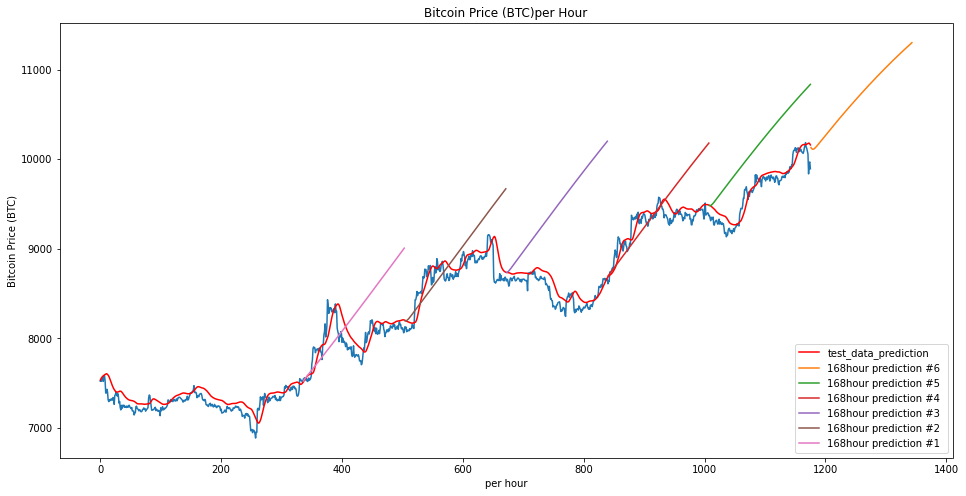

In [38]:
plt.figure(figsize = (16,8))
plt.plot(df2[len(df2)-lengthofperiod:])
plt.plot(test_predict[len(test_predict)-lengthofperiod:],color='r',label='test_data_prediction')
plt.plot(np.arange(1176,1344),final[0],label='168hour prediction #6 ')
plt.plot(np.arange(1008,1176),final[1],label='168hour prediction #5 ')
plt.plot(np.arange(840,1008),final[2],label='168hour prediction #4 ')
plt.plot(np.arange(672,840),final[3],label='168hour prediction #3 ')
plt.plot(np.arange(504,672),final[4],label='168hour prediction #2 ')
plt.plot(np.arange(336,504),final[5],label='168hour prediction #1 ')

plt.legend(loc='lower right',prop={'size': 10})
plt.xlabel('per hour')
plt.ylabel('Bitcoin Price (BTC)')
plt.title('Bitcoin Price (BTC)per Hour');